# Construcción y Evaluación de Pipelines de Machine Learning para Predecir la Calidad del Vino

Este análisis utiliza el conjunto de datos titulado *Modeling Wine Preferences by Data Mining from Physicochemical Properties*, el cual contiene atributos fisicoquímicos como la acidez fija, acidez volátil y ácido cítrico, entre otros. El objetivo principal es construir un pipeline de regresión que permita predecir de manera efectiva la calidad del vino basándonos en estas propiedades.

Antes de iniciar con el análisis, es necesario importar las librerías requeridas, configurar el entorno y garantizar la reproducibilidad mediante la fijación de una semilla aleatoria. Además, se establecen configuraciones para la visualización de gráficos y el manejo de advertencias.


## **1. Importación de Librerías**

In [58]:
# Instalar librerias
# !pip install ipywidgets
#!pip install ydata_profiling
#!pip install ucimlrepo
# !pip install scikit-learn



In [59]:
# --- Importaciones estándar ---
import warnings  # Para gestionar y suprimir warnings
import random  # Para configurar la semilla aleatoria
import os  # Para operaciones relacionadas con el sistema de archivos
import webbrowser  # Para abrir URLs en el navegador

# --- Manejo de datos y operaciones matemáticas ---
import pandas as pd  # Para manipulación de datos
import numpy as np  # Para operaciones matemáticas y manejo de arrays

# PCA
from sklearn.decomposition import PCA


# --- Librerías estadísticas ---
from scipy.stats import skew, kurtosis  # Para calcular sesgo y curtosis en los datos
from scipy.stats import boxcox  # Para aplicar la transformación Box-Cox

# --- Preprocesamiento de datos ---
from sklearn.preprocessing import StandardScaler, PowerTransformer  # Para escalado y transformaciones de potencia

# --- Visualización de datos ---
import matplotlib.pyplot as plt  # Para generación de gráficos
import seaborn as sns  # Para visualizaciones más atractivas

# --- Generación de informes exploratorios ---
from ydata_profiling import ProfileReport  # Para generar informes detallados de análisis exploratorio

# --- Descarga de datasets ---
from ucimlrepo import fetch_ucirepo  # Para descargar datasets desde UC Irvine Machine Learning Repository

# --- Configuración de gráficos ---
sns.set_palette('viridis')  # Establece la paleta de colores de seaborn
plt.style.use('ggplot')  # Usa el estilo de gráficos 'ggplot' de matplotlib

# --- Desactivar warnings ---
warnings.filterwarnings('ignore')  # Suprime los warnings para una experiencia más limpia

# --- Configuración de la semilla aleatoria ---
RANDOM_SEED = 42  # Fija una semilla para garantizar reproducibilidad
random.seed(RANDOM_SEED)  # Configura la semilla en el módulo random
np.random.seed(RANDOM_SEED)  # Configura la semilla para NumPy

# --- Mensaje de éxito ---
print("Librerías importadas correctamente.")


Librerías importadas correctamente.


### Conclusiones

En esta etapa, hemos preparado el entorno de trabajo para realizar el análisis exploratorio y la construcción de los pipelines de Machine Learning. Se han importado todas las librerías necesarias y configurado las herramientas para garantizar un flujo de trabajo eficiente y reproducible. Esta configuración nos permitirá analizar las características de los datos y proceder con los pasos siguientes en el modelado de la calidad del vino.


# **Funciones**

## Identificación de Valores Atípicos

Para asegurar un análisis robusto y confiable, es crucial detectar y manejar los valores atípicos que puedan distorsionar los resultados del modelo. En este análisis, utilizamos el método del rango intercuartílico (IQR), una técnica ampliamente utilizada para identificar outliers en distribuciones de datos.

La siguiente función permite calcular el IQR para una columna específica del DataFrame y determinar los límites inferior y superior, así como los valores que se consideran atípicos.


In [60]:
# Función para calcular el rango intercuartílico (IQR)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


### Conclusiones

La implementación de esta función proporciona una herramienta eficiente para identificar valores atípicos en las columnas del conjunto de datos. Este paso es fundamental para garantizar que las características utilizadas en el modelo no estén sesgadas por outliers, lo que mejorará la calidad de las predicciones al minimizar el impacto de datos extremos.


# **Carga y Exploración de los Datos**

El conjunto de datos utilizado en este análisis fue obtenido de la UCI Machine Learning Repository utilizando la función `fetch_ucirepo`. Este dataset incluye atributos fisicoquímicos del vino (como acidez, pH y contenido de alcohol) y una variable objetivo que representa la calidad del vino.

En esta etapa:

1. Se descargan los datos directamente desde la fuente.
2. Se dividen en características (`X`) y la variable objetivo (`y`).
3. Se combinan las características y el objetivo en un único DataFrame para facilitar el análisis.
4. Se guarda el conjunto de datos en un archivo CSV para posibles usos posteriores.
5. Se visualiza la información sobre las variables incluidas en el dataset.


In [61]:
# Obtener el conjunto de datos
wine_quality = fetch_ucirepo(id=186)

In [62]:
# Dividir en características (X) y objetivo (y)
X = wine_quality.data.features
y = wine_quality.data.targets

# Combinar características y objetivo en un DataFrame
df = pd.concat([X, y], axis=1, ignore_index=False)

# Guardar dataset en un archivo CSV
df.to_csv('wine_quality.csv', index=False)

# Mostrar información sobre las variables del conjunto de datos
display(wine_quality.variables)


name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  None             no  
2                     None  None             no  
3                     None  None             no  
4                     None  None             no  
5                     None  None             no  
6                     None  None             no  
7                     None  None             no  
8                     None  None             no  
9                     None  None             no  
10                    None  None             no  
11  score between 0 and 10  None             no  
12            red or white  None             no

## Descripción de las Variables y Metadatos del Conjunto de Datos

El conjunto de datos incluye una amplia variedad de variables relacionadas con las propiedades fisicoquímicas del vino, así como su calidad. Estas variables se dividen en tres categorías principales:

1. **Características (Features):** Incluyen variables continuas como acidez fija, acidez volátil y contenido de alcohol, que se utilizarán como predictores en el modelo.
2. **Variable Objetivo (Target):** Representada por la columna `quality`, que evalúa la calidad del vino con un puntaje entre 0 y 10.
3. **Variables Adicionales:** Como `color`, que indica si el vino es rojo o blanco.

### Ejemplo de Variables
- `fixed_acidity`: Variable continua que mide la acidez fija del vino.
- `quality`: Variable objetivo que representa la calidad del vino en una escala de 0 a 10.
- `color`: Variable categórica que clasifica el vino como rojo o blanco.

Adicionalmente, los metadatos del dataset proporcionan información sobre el autor, la fuente y la descripción general, lo que facilita la comprensión del contexto y origen de los datos.


In [63]:
# Mostrar metadatos del conjunto de datos
for key, value in wine_quality.metadata.items():
    print(f"Key: {key}")
    print(f"Info: {value}")
    print("-" * 40)  # Separador para mejorar la legibilidad

Key: uci_id
Info: 186
----------------------------------------
Key: name
Info: Wine Quality
----------------------------------------
Key: repository_url
Info: https://archive.ics.uci.edu/dataset/186/wine+quality
----------------------------------------
Key: data_url
Info: https://archive.ics.uci.edu/static/public/186/data.csv
----------------------------------------
Key: abstract
Info: Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).
----------------------------------------
Key: area
Info: Business
----------------------------------------
Key: tasks
Info: ['Classification', 'Regression']
----------------------------------------
Key: characteristics
Info: ['Multivariate']
----------------------------------------
Key: num_instances
Info: 4898
----------------------------------------
Key: num_feature

## **Metadatos del Conjunto de Datos**
**
El dataset *Wine Quality* ofrece información detallada sobre vinos verdes (tinto y blanco) provenientes del norte de Portugal. Este análisis se basa en pruebas fisicoquímicas y evalúa la calidad del vino a través de una variable objetivo (`quality`). Los metadatos proporcionan detalles valiosos que permiten entender mejor el contexto, características y limitaciones del conjunto de datos.

### **Detalles Clave del Dataset**
- **Nombre:** Wine Quality.
- **ID en UCI:** 186.
- **URL del repositorio:** [Enlace al repositorio](https://archive.ics.uci.edu/dataset/186/wine+quality).
- **URL de los datos:** [Enlace a los datos](https://archive.ics.uci.edu/static/public/186/data.csv).
- **Resumen:** Contiene muestras de vino verde (tinto y blanco) del norte de Portugal, con el objetivo de modelar la calidad del vino a partir de pruebas fisicoquímicas.
- **Áreas de aplicación:** Negocios.
- **Tareas posibles:** Clasificación y regresión.
- **Características:** Multivariadas.
- **Número de instancias:** 4898.
- **Número de características:** 11 (todas reales).
- **Columna objetivo:** `quality` (calidad del vino).
- **Valores faltantes:** No hay.
- **Año de creación:** 2009.
- **Última actualización:** 15 de noviembre de 2023.

### Artículo Introductorio
- **Título:** Modeling wine preferences by data mining from physicochemical properties.
- **Autores:** Paulo Cortez, A. Cerdeira, F. Almeida, T. Matos, J. Reis.
- **Publicación:** Decision Support Systems, 2009. [Enlace al artículo](https://www.semanticscholar.org/paper/Modeling-wine-preferences-by-data-mining-from-Cortez-Cerdeira/bf15a0ccc14ac1deb5cea570c870389c16be019c).

### Información Adicional
- Representa variantes de vino verde portugués.
- Las clases de calidad están desbalanceadas, lo que puede requerir estrategias adicionales como detección de outliers o selección de características.
- No incluye datos sensibles como tipos de uva, marca o precio debido a restricciones de privacidad.


# **EDA**

## Análisis Exploratorio de Datos (EDA)

El análisis exploratorio de datos (EDA) es un paso esencial para comprender el conjunto de datos y guiar el diseño del modelo de Machine Learning. Este proceso se enfoca en identificar patrones, distribuciones, valores atípicos y relaciones entre las variables.

### Detalles del Dataset
- **Objetivo:** Analizar características fisicoquímicas del vino y su relación con la variable objetivo (`quality`).
- **Columnas disponibles:**
  - **Características:** `fixed_acidity`, `volatile_acidity`, `citric_acid`, `residual_sugar`, `chlorides`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `density`, `pH`, `sulphates`, `alcohol`.
  - **Variable objetivo:** `quality` (puntuación entre 0 y 10).
- **Tamaño del dataset:** 4898 instancias con 11 características reales.
- **Distribución de las variables:**
  - Las características son numéricas, permitiendo el uso de técnicas gráficas como histogramas y boxplots para explorar sus distribuciones.
  - La variable objetivo (`quality`) requiere un análisis detallado para entender su distribución y evaluar si las clases están balanceadas.

### Consideraciones Iniciales
1. Evaluar la distribución de cada característica y la variable objetivo.
2. Identificar valores atípicos que puedan afectar el análisis.
3. Estudiar la correlación entre las características y la variable objetivo.


- **Objetivo del EDA:** Analizar el dataset para identificar patrones, distribuciones, valores atípicos y relaciones entre variables.

- **Columnas disponibles:**
  - **Características:** `fixed_acidity`, `volatile_acidity`, `citric_acid`, `residual_sugar`, `chlorides`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `density`, `pH`, `sulphates`, `alcohol`.
  - **Variable objetivo:** `quality` (puntuación entre 0 y 10).
- **Tamaño del dataset:** Aproximadamente 4898 instancias con 11 características reales.
- **Consideraciones iniciales:**
  - Las características son numéricas, lo que facilita su análisis con histogramas, boxplots y correlaciones.
  - Es importante evaluar la distribución de la variable objetivo (`quality`) para entender cómo están distribuidas las calificaciones del vino.


In [64]:
df.head(1)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4               0.7          0.0             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


## **Exploración Inicial del Dataset**

Como parte del análisis exploratorio de datos (EDA), se realizó una revisión inicial del conjunto de datos para comprender su estructura y contenido.

### Detalles del Dataset
- **Tamaño:** 6497 filas y 12 columnas.
- **Columnas disponibles:** 11 características numéricas (`float64`) y 1 variable objetivo (`int64`).
- **Ejemplo de registro:**




## Objetivo del EDA
Analizar el dataset para identificar patrones, distribuciones, valores atípicos y relaciones entre variables, con el fin de comprender mejor los factores que influyen en la calidad del vino y preparar los datos para el modelado predictivo.

## Descripción del Dataset

### Columnas Disponibles

- **Características:**
  - `fixed_acidity`
  - `volatile_acidity`
  - `citric_acid`
  - `residual_sugar`
  - `chlorides`
  - `free_sulfur_dioxide`
  - `total_sulfur_dioxide`
  - `density`
  - `pH`
  - `sulphates`
  - `alcohol`

- **Variable Objetivo:**
  - `quality` (puntuación entre 0 y 10)

### Tamaño del Dataset
- **Número de Instancias:** 6,497
- **Número de Características:** 11 características numéricas y 1 variable objetivo.


## **Listado y Significado de las Variables**

El dataset contiene 11 características numéricas continuas y 1 variable objetivo discreta, `quality`, que mide la calidad del vino según evaluaciones sensoriales. A continuación, se detalla el significado de cada variable y su posible impacto en la calidad del vino.

### Objetivo
Explicar en detalle cada característica del dataset, su significado, su relación con la calidad del vino, y cualquier aspecto relevante basado en conocimientos del dominio.

### Detalle de las Variables
1. **fixed_acidity**: Representa los ácidos no volátiles del vino, como el ácido tartárico, influyendo en la frescura y estructura.
2. **volatile_acidity**: Mide el ácido acético, cuyo exceso puede causar defectos de aroma como el avinagramiento.
3. **citric_acid**: Un ácido natural que aporta frescura y balance; común en vinos blancos.
4. **residual_sugar**: Azúcar no fermentado que define si el vino es seco, semiseco o dulce.
5. **chlorides**: Refleja la salinidad del vino; altos niveles son indeseables.
6. **free_sulfur_dioxide**: Conservante crucial para la estabilidad y contra la oxidación.
7. **total_sulfur_dioxide**: Suma del dióxido de azufre libre y combinado, regulado por leyes vinícolas.
8. **density**: Indicador de la relación entre masa y volumen; correlacionado con el azúcar residual y alcohol.
9. **pH**: Mide la acidez o alcalinidad; afecta la frescura y estabilidad del vino.
10. **sulphates**: Conservantes que aportan cuerpo y persistencia, pero cuyo exceso puede causar amargor.
11. **alcohol**: Proporción de etanol; mayores niveles suelen asociarse con mejor calidad.
12. **quality** *(Variable Objetivo)*: Puntuación sensorial basada en evaluaciones de expertos.

### Impacto de las Variables en la Calidad
1. **Relación con la Calidad:** Cada variable influye en la percepción sensorial y estabilidad del vino.
2. **Potencial de Correlaciones:** Variables como `alcohol`, `volatile_acidity` y `sulphates` podrían correlacionarse con `quality`.

## Análisis Exploratorio Automático
El análisis exploratorio automático se realiza mediante la librería `ydata_profiling`, que permite generar un informe interactivo en HTML. Este informe incluye:
- Distribuciones de las variables.
- Correlaciones entre características.
- Identificación de valores atípicos.
- Estadísticas descriptivas.

Esta herramienta acelera la identificación de patrones clave en los datos y garantiza una visión integral del dataset.


In [66]:
# Nombre del archivo HTML generado previamente
report_file = "wine_quality_eda.html"

# Verificar si el informe ya existe
if os.path.exists(report_file):
    print(f"El informe ya existe: {report_file}")
    print("Abre el archivo manualmente en tu navegador para visualizarlo.")
else:
    # Generar el informe si no existe
    profile = ProfileReport(df, title="Informe de Análisis Exploratorio de Datos - Calidad del Vino", explorative=True)
    profile.to_file(report_file)
    print(f"Informe generado y guardado en: {report_file}")



# Abrir el informe en el navegador
webbrowser.open(report_file)

El informe ya existe: wine_quality_eda.html
Abre el archivo manualmente en tu navegador para visualizarlo.


False

## Análisis Exploratorio Detallado del Dataset

En esta sección se realizó un análisis exploratorio utilizando tanto técnicas manuales como la herramienta `ydata_profiling`, con el objetivo de identificar patrones, outliers y correlaciones importantes entre las variables del dataset.

### Características del Dataset
- **Número de observaciones:** 6497.
- **Número de variables:** 12.
- **Valores faltantes:** Ninguno (0%).
- **Filas duplicadas:** 993 (15.3%), lo que puede influir en los modelos y métricas.
- **Tipos de variables:** Todas son numéricas, incluyendo la variable objetivo `quality`.

### Resumen de las Variables Numéricas
1. **fixed_acidity:**
   - **Rango:** 3.8 - 15.9 g/L.
   - **Media:** 7.2153 g/L.
   - **Interacciones:** Valores entre 6 y 8 están asociados con mayor calidad.
   - **Observaciones:** Outliers significativos por encima de 12.

2. **volatile_acidity:**
   - **Rango:** 0.08 - 1.58 g/L.
   - **Media:** 0.3396 g/L.
   - **Interacciones:** Valores más bajos (0.2 - 0.4) tienen mayor calidad.
   - **Observaciones:** Outliers por encima de 1.2 g/L.

3. **citric_acid:**
   - **Rango:** 0 - 1.66 g/L.
   - **Media:** 0.31 g/L.
   - **Observaciones:** 151 valores iguales a 0 (2.3% del dataset).

4. **residual_sugar:**
   - **Rango:** 0.6 - 65.8 g/L.
   - **Media:** 5.44 g/L.
   - **Interacciones:** Valores cercanos a 0 tienen mayor calidad.
   - **Observaciones:** Outliers extremos por encima de 30 g/L.

5. **chlorides:**
   - **Rango:** 0.01 - 0.61 g/L.
   - **Media:** 0.05 g/L.
   - **Interacciones:** Valores entre 0 y 0.1 tienen mayor calidad.
   - **Observaciones:** Valores altos (>0.2 g/L) pueden ser problemáticos.

6. **alcohol:**
   - **Rango:** 8 - 14.9% vol.
   - **Media:** 10.5% vol.
   - **Interacciones:** Valores altos están asociados con mejores calificaciones.

7. **free_sulfur_dioxide:**
   - **Rango:** 1 - 289 mg/L.
   - **Media:** 30.5253 mg/L.
   - **Interacciones:** Valores cercanos a 50 tienen mayor calidad.

8. **total_sulfur_dioxide:**
   - **Rango:** 6 - 440 mg/L.
   - **Media:** 115.7445 mg/L.
   - **Interacciones:** Valores cercanos a 100 tienen mayor calidad.

9. **density:**
   - **Rango:** 0.9871 - 1.0389 g/cm³.
   - **Media:** 1.0389 g/cm³.
   - **Interacciones:** Valores cercanos a 0.99 tienen mayor calidad.
   - **Observaciones:** Alta correlación con alcohol y residual_sugar.

10. **ph:**
    - **Rango:** 2.72 - 4.01.
    - **Media:** 3.2185.
    - **Interacciones:** Valores alrededor de 3.2 tienen mayor calidad.

11. **sulphates:**
    - **Rango:** 0.22 - 2 g/L.
    - **Media:** 0.5313 g/L.
    - **Interacciones:** Valores cercanos a 0.49 tienen mayor calidad.

12. **quality:**
    - **Rango:** 3 - 9.
    - **Media:** 5.8183.
    - **Observaciones:** Más comunes entre 5 y 7.

### Correlaciones Clave
- **Correlación con `quality`:**
  - `alcohol` tiene una correlación positiva (~0.44) con la calidad.
  - El resto de correlaciones son bajas, indicando que la calidad depende más de rangos en las variables que de aumentos lineales.

- **Colinealidad:**
  - `free_sulfur_dioxide` vs `total_sulfur_dioxide`.
  - `alcohol` vs `density`.
  - `density` vs `chlorides` y `residual_sugar`.

### Outliers
- **residual_sugar:** Valores >30 g/L son outliers asociados a vinos dulces específicos.
- **chlorides:** Valores >0.2 g/L indican posible contaminación.
- **density:** Valores fuera del rango 0.99 - 1.03.

### Duplicados
El dataset incluye **993 filas duplicadas (15.3%)**, que deben ser tratadas para evitar sesgos en el análisis.


## **Tratamiento de Duplicados**

El tratamiento de duplicados es un paso clave en el preprocesamiento de datos para garantizar la integridad y calidad del dataset, evitando redundancias que puedan sesgar los resultados del modelo.

### Objetivo
1. Identificar y analizar la presencia de filas duplicadas en el dataset.
2. Evaluar el impacto de los duplicados en la distribución de la variable objetivo (`quality`).
3. Eliminar duplicados redundantes manteniendo la distribución general de la calidad.

### Estrategia
1. **Identificación de Duplicados:**
   - Se detectaron **1179 filas duplicadas** (18.1% del dataset original).
   - La mayoría de estas filas corresponden a calidades intermedias (`quality` = 5, 6, 7), con una menor proporción en los extremos (4 y 8).

2. **Eliminación de Duplicados:**
   - Tras el análisis, se eliminaron las filas duplicadas, reduciendo el dataset de 6497 a **5318 filas únicas**.
   - Se verificó que la distribución de la variable `quality` no se viera afectada significativamente tras la eliminación.

3. **Visualización de la Distribución:**
   - Se generaron gráficos comparativos antes y después de la eliminación de duplicados para confirmar que la distribución general de la calidad del vino se mantuvo estable.

### Resultados
- La eliminación de duplicados garantiza que cada fila del dataset sea única, mejorando la eficacia y confiabilidad de los modelos de machine learning.
- La proporción de registros eliminados no afecta la representatividad del dataset para el análisis.


Número de filas duplicadas: 1179
Distribución de la calidad en las filas duplicadas:
quality
6    513
5    387
7    224
8     45
4     10
Name: count, dtype: int64
Número de filas tras eliminar duplicados: 5318


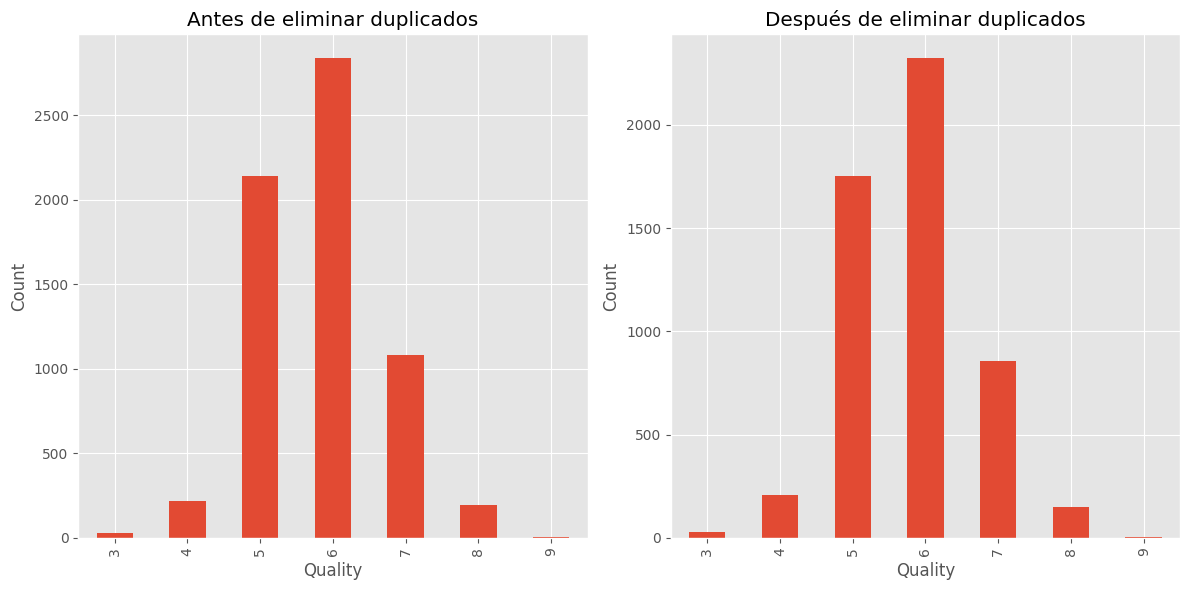

In [67]:
# Verificar duplicados en el dataset completo
duplicated_rows = df[df.duplicated()]
print(f"Número de filas duplicadas: {len(duplicated_rows)}")

# Verificar si los duplicados afectan a la variable objetivo
duplicates_quality = duplicated_rows['quality'].value_counts()
print("Distribución de la calidad en las filas duplicadas:")
print(duplicates_quality)

# Eliminar duplicados del dataset
df_cleaned = df.drop_duplicates()

# Confirmar eliminación
print(f"Número de filas tras eliminar duplicados: {df_cleaned.shape[0]}")

# Mostrar grafico de barras antes y despues de eliminar duplicados del balance de la variable objetivo

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Antes de eliminar duplicados
df['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Antes de eliminar duplicados')
axes[0].set_xlabel('Quality')
axes[0].set_ylabel('Count')

# Después de eliminar duplicados
df_cleaned['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Después de eliminar duplicados')
axes[1].set_xlabel('Quality')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()




### Conclusiones

El tratamiento de duplicados permitió:
1. Reducir el dataset en un **18.1%**, eliminando 1179 filas redundantes.
2. Mantener una distribución estable de la variable objetivo (`quality`), lo que asegura que el análisis y los modelos no pierdan representatividad.
3. Mejorar la integridad del dataset, evitando que los duplicados influyan negativamente en las métricas de evaluación.

El proceso ha sido documentado y será integrado en el pipeline final para garantizar su reproducibilidad y transparencia.



---

## Detección de Outliers

El análisis de valores extremos o outliers es esencial para comprender la dispersión de las características del dataset y su posible impacto en el modelo de machine learning. Utilizamos boxplots y el método del rango intercuartílico (IQR) para identificar registros que exceden los límites establecidos en cada variable.

### Metodología
1. **Generación de Boxplots:**
   - Se graficaron boxplots para cada característica numérica del dataset.
   - Estos gráficos permiten una identificación visual de outliers.

2. **Método del Rango Intercuartílico (IQR):**
   - Se calcularon los límites inferior y superior para cada variable.
   - Registros fuera de estos límites se consideran outliers.

### Resultados
- **Variables con más outliers:**
  - `fixed_acidity` (304).
  - `volatile_acidity` (279).
  - `chlorides` (237).

- **Variables con menos outliers:**
  - `alcohol` (1).
  - `density` (3).
  - `total_sulfur_dioxide` (10).

- **Rangos esperados de cada variable:**
  1. `fixed_acidity`: 4.45 - 9.65.
  2. `volatile_acidity`: -0.04 - 0.68.
  3. `citric_acid`: 0 - 0.64.
  4. `residual_sugar`: -6.75 - 16.05.
  5. `chlorides`: -0.004 - 0.108.
  6. `free_sulfur_dioxide`: -21.5 - 78.5.
  7. `total_sulfur_dioxide`: -45.625 - 273.375.
  8. `density`: 0.9853 - 1.0036.
  9. `pH`: 2.78 - 3.66.
  10. `sulphates`: 0.175 - 0.855.
  11. `alcohol`: 6.65 - 14.25.

### Observaciones
- Valores extremos en variables como `chlorides`, `volatile_acidity` y `residual_sugar` podrían estar relacionados con procesos específicos de producción de vino.
- La mayoría de los outliers corresponden a características de acidez y componentes minoritarios.



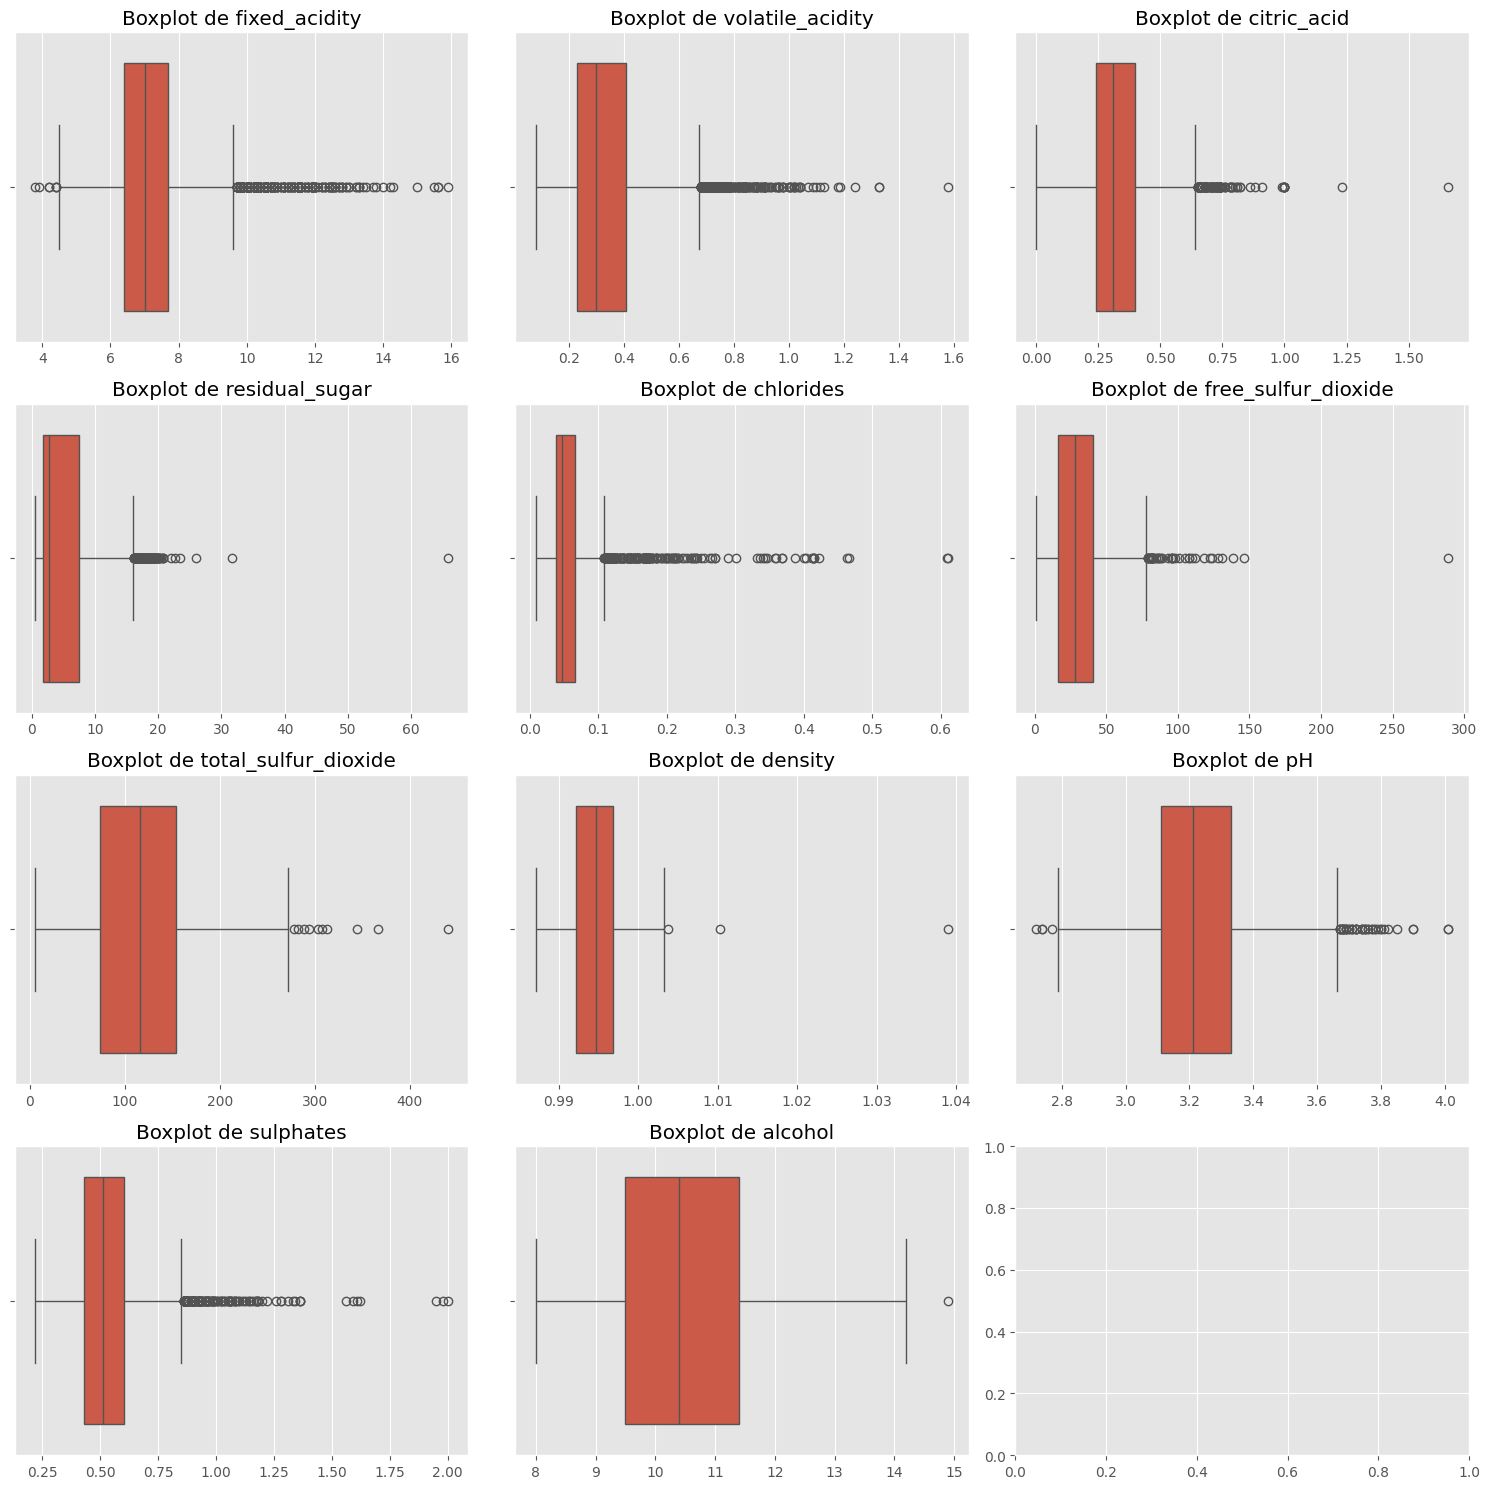

"fixed_acidity: {'Número de outliers': 304, 'Límite inferior': 4.450000000000001, 'Límite superior': 9.65}"

"volatile_acidity: {'Número de outliers': 279, 'Límite inferior': -0.03999999999999995, 'Límite superior': 0.6799999999999999}"

"citric_acid: {'Número de outliers': 143, 'Límite inferior': -5.551115123125783e-17, 'Límite superior': 0.6400000000000001}"

"residual_sugar: {'Número de outliers': 141, 'Límite inferior': -6.750000000000001, 'Límite superior': 16.05}"

"chlorides: {'Número de outliers': 237, 'Límite inferior': -0.0040000000000000105, 'Límite superior': 0.10800000000000001}"

"free_sulfur_dioxide: {'Número de outliers': 44, 'Límite inferior': -21.5, 'Límite superior': 78.5}"

"total_sulfur_dioxide: {'Número de outliers': 10, 'Límite inferior': -45.625, 'Límite superior': 273.375}"

"density: {'Número de outliers': 3, 'Límite inferior': 0.9853449999999999, 'Límite superior': 1.0036250000000002}"

"pH: {'Número de outliers': 49, 'Límite inferior': 2.7799999999999994, 'Límite superior': 3.66}"

"sulphates: {'Número de outliers': 163, 'Límite inferior': 0.175, 'Límite superior': 0.855}"

"alcohol: {'Número de outliers': 1, 'Límite inferior': 6.6499999999999995, 'Límite superior': 14.25}"

In [68]:
# Variables numéricas a analizar
numerical_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                     'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide',
                     'density', 'pH', 'sulphates', 'alcohol']

# Boxplots para detectar outliers
fig, axes = plt.subplots(len(numerical_columns) // 3 + 1, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df_cleaned, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()


# Detectar y mostrar outliers por variable
outliers_info = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(df_cleaned, col)
    outliers_info[col] = {
        "Número de outliers": len(outliers),
        "Límite inferior": lower,
        "Límite superior": upper,
    }

# Mostrar resumen de outliers
for col, info in outliers_info.items():
    display(f"{col}: {info}")



### Conclusiones

El análisis de outliers permite identificar valores extremos que podrían influir significativamente en los modelos de machine learning. Estos hallazgos destacan:
1. Variables como `fixed_acidity`, `volatile_acidity` y `chlorides` presentan la mayor cantidad de outliers, posiblemente debido a diferencias en los procesos de elaboración del vino.
2. Variables como `alcohol` y `density` tienen pocos outliers, reflejando una mayor uniformidad en sus valores.
3. Los valores extremos detectados serán tratados cuidadosamente para garantizar que no distorsionen los resultados del modelo.

Este análisis es crucial para decidir si se deben eliminar, transformar o conservar estos valores extremos dependiendo del contexto del modelo y la naturaleza del problema.


---

## **Decisión sobre el Tratamiento de Outliers**

El análisis de outliers ha permitido identificar variables con valores extremos que podrían influir negativamente en el modelo. En esta sección, se analizan tres variables clave: `density`, `total_sulfur_dioxide` y `chlorides`, con especial atención a `total_sulfur_dioxide` debido a su posible impacto en la calidad del vino.

### Observaciones Clave
1. **Density:**
   - Solo 7 outliers detectados.
   - Diferencia mínima entre el rango esperado (0.9853 - 1.0036) y los valores extremos.
   - Decisión: Conservar los outliers debido a su bajo impacto.

2. **Total Sulfur Dioxide:**
   - Valores extremos (>273.375) están mayoritariamente concentrados en calidades bajas y medias (3 a 6).
   - Distribución de calidad en los outliers:
     - **Calidad 5:** 40%.
     - **Calidad 3:** 30%.
     - **Calidad 7:** 20%.
     - **Calidad 6:** 10%.
   - Decisión: Eliminar los outliers, ya que no aportan información relevante para calidades altas.

3. **Chlorides:**
   - Valores altos (>0.2) asociados con calidades bajas (4 a 6).
   - Podrían ser útiles para identificar vinos de menor calidad.
   - Decisión: Conservar los outliers para análisis posterior.

### Comparación de Distribuciones
La comparación entre valores normales y outliers de `total_sulfur_dioxide` muestra que:
- Los valores normales abarcan un rango más amplio, incluyendo calidades altas (7 y 8).
- Los outliers están mayormente limitados a calidades medias y bajas, lo que limita su utilidad para predecir calidades superiores.

### Decisión Final
- **Eliminar los outliers de `total_sulfur_dioxide`** para mejorar la precisión del modelo.
- Conservar los outliers en `density` y `chlorides` debido a su bajo impacto o relevancia potencial para identificar ciertas características del vino.


Distribución de calidad en los outliers de 'total_sulfur_dioxide':
quality
5    0.4
3    0.3
7    0.2
6    0.1
Name: proportion, dtype: float64


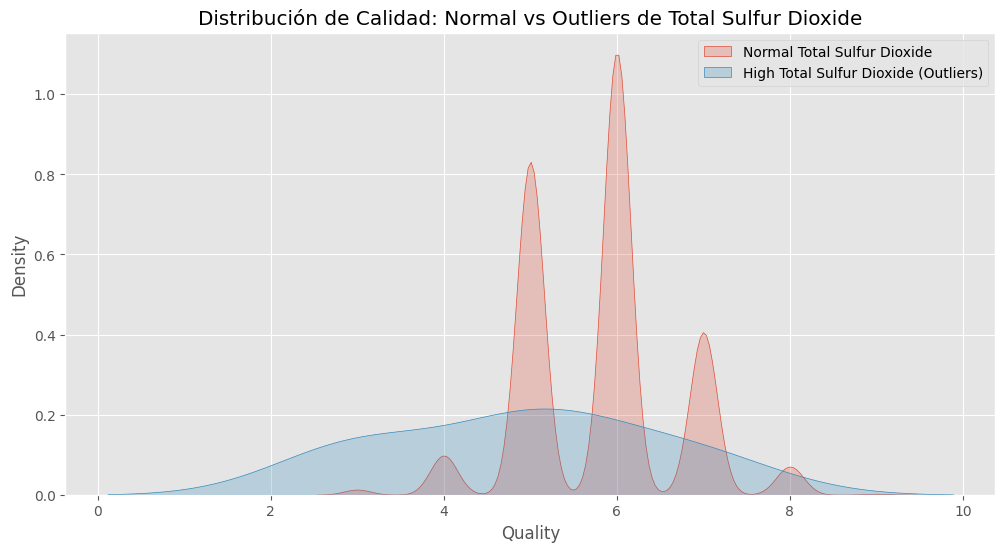

In [69]:
# Identificar los outliers en 'total_sulfur_dioxide'
outliers_tsd = df_cleaned[df_cleaned['total_sulfur_dioxide'] > 273.375]
normal_tsd = df_cleaned[df_cleaned['total_sulfur_dioxide'] <= 273.375]

# Distribución de la variable objetivo en outliers
print("Distribución de calidad en los outliers de 'total_sulfur_dioxide':")
print(outliers_tsd['quality'].value_counts(normalize=True))

# Comparar la distribución de calidad entre outliers y valores normales
plt.figure(figsize=(12, 6))
sns.kdeplot(normal_tsd['quality'], label='Normal Total Sulfur Dioxide', shade=True)
sns.kdeplot(outliers_tsd['quality'], label='High Total Sulfur Dioxide (Outliers)', shade=True)
plt.title("Distribución de Calidad: Normal vs Outliers de Total Sulfur Dioxide")
plt.xlabel("Quality")
plt.legend()
plt.show()



### Conclusiones

El tratamiento de outliers es un paso crucial para optimizar el rendimiento del modelo. En el caso de `total_sulfur_dioxide`, se tomó la decisión de eliminar los valores extremos (>273.375) debido a su limitada relevancia para calidades altas. Por otro lado:
1. Los outliers de `density` se conservarán por su bajo impacto.
2. Los outliers de `chlorides` se mantendrán para análisis adicionales, ya que podrían ser indicadores de vinos de menor calidad.

Estas decisiones aseguran un equilibrio entre la limpieza del dataset y la preservación de información relevante.



## **Análisis y Decisión sobre la Variable `Chlorides`**

La variable `chlorides` (cloruros) es relevante para la calidad del vino, ya que valores altos (>0.2 g/L) pueden causar una percepción de salinidad excesiva, afectando negativamente su valoración. En esta sección, se analizan los registros con valores normales y altos de `chlorides` para evaluar su impacto en la distribución de la calidad (`quality`).

### Observaciones
1. **Distribución en Registros Normales vs Altos:**
   - **Valores Normales (<= 0.2 g/L):** Incluyen una mayor proporción de calificaciones altas (7 y 8).
   - **Valores Altos (>0.2 g/L):** Asociados principalmente con calificaciones bajas y medias (4 a 6).

2. **Proporción de Calidades en Outliers:**
   - **Calidad 5:** 50.9%.
   - **Calidad 6:** 37.7%.
   - **Calidades 4, 3 y 7:** Cada una con 3.8%.

3. **Impacto en la Predicción:**
   - Los valores altos de `chlorides` tienen un mayor peso en registros de baja calidad (calificaciones ≤ 4), lo que los hace relevantes para identificar vinos con características desfavorables.

### Visualización
- La comparación gráfica muestra que:
  - Los registros con valores normales tienen una mayor dispersión en calificaciones altas.
  - Los registros con valores altos presentan una distribución más concentrada en calificaciones bajas y medias.

### Decisiones Tomadas
1. **Conservación de Outliers:**
   - Los outliers en `chlorides` reflejan características importantes para identificar vinos de baja calidad.
   - Decisión: **Mantener los outliers** en esta variable.

2. **Decisiones Generales sobre Outliers:**
   - **Density:** Aplicar **winsorización** para ajustar ligeramente los valores extremos.
   - **Total Sulfur Dioxide:** **Eliminar** registros que excedan el límite superior (>273.375).
   - **Chlorides:** Conservar los valores extremos para preservar su relevancia en el modelo.



quality
5    0.509434
6    0.377358
4    0.037736
7    0.037736
3    0.037736
Name: proportion, dtype: float64


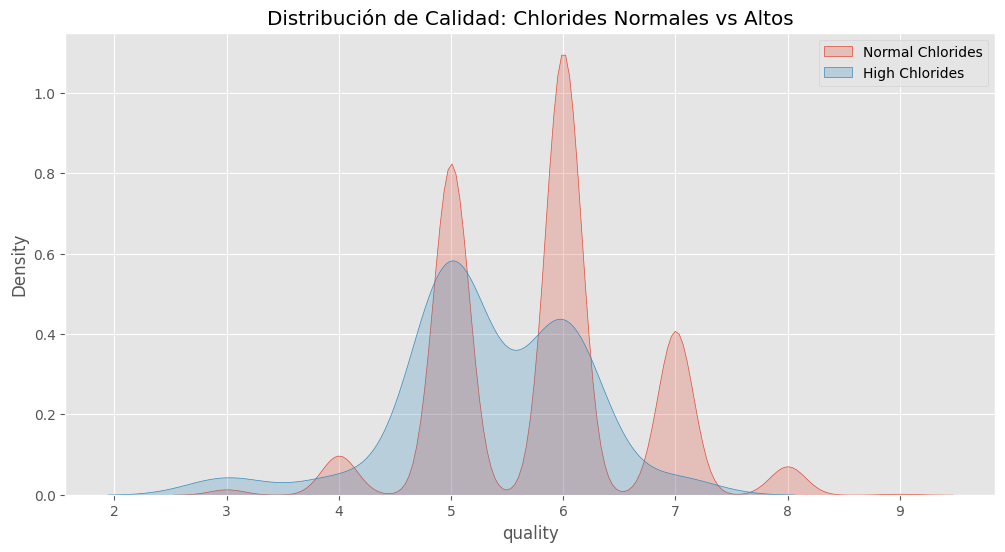

In [70]:
# Ver correlación entre chlorides y quality para valores altos
outliers_chlorides = df_cleaned[df_cleaned['chlorides'] > 0.2]
print(outliers_chlorides['quality'].value_counts(normalize=True))

# Comparar distribución de calidad en valores normales y altos
normal_chlorides = df_cleaned[df_cleaned['chlorides'] <= 0.2]
plt.figure(figsize=(12, 6))
sns.kdeplot(normal_chlorides['quality'], label='Normal Chlorides', shade=True)
sns.kdeplot(outliers_chlorides['quality'], label='High Chlorides', shade=True)
plt.legend()
plt.title("Distribución de Calidad: Chlorides Normales vs Altos")
plt.show()


### Conclusiones

El análisis de la variable `chlorides` resalta su importancia para identificar vinos de baja calidad, dado que valores altos (>0.2 g/L) están fuertemente asociados con calificaciones bajas y medias. Esta característica es clave para el modelo, ya que permite capturar información específica sobre condiciones desfavorables en el vino.

Decisiones tomadas:
1. Conservar los outliers en `chlorides` para no perder información relevante.
2. Ajustar o eliminar outliers en otras variables (`density` y `total_sulfur_dioxide`) según su impacto en el modelo.

Estas decisiones aseguran un balance entre la limpieza del dataset y la preservación de características clave para la predicción de la calidad.



## **Tratamiento Final de Outliers**

Se han aplicado estrategias específicas para manejar los outliers en el dataset, asegurando un balance entre la limpieza de datos y la preservación de información relevante para la predicción de la calidad del vino.

### Estrategias Aplicadas
1. **Winsorización de `density`:**
   - Rango permitido: [0.9853, 1.0036].
   - Se limitaron los valores extremos para mantener una distribución uniforme sin eliminar registros.

2. **Eliminación de Outliers en `total_sulfur_dioxide`:**
   - Límite superior: 273.375.
   - Se eliminaron registros con valores superiores a este límite, que representaban un sesgo hacia calidades medias y bajas sin aportar información relevante para calidades altas.

3. **Mantenimiento de Outliers en `chlorides`:**
   - No se aplicaron cambios, ya que los valores extremos están relacionados con calificaciones bajas y pueden aportar información valiosa al modelo.

### Resultados del Tratamiento
- **Número de registros antes del tratamiento:** 5318.
- **Número de registros después del tratamiento:** 5308.

### Consideraciones para Modelos
- El dataset final conserva outliers relevantes en `chlorides` y ajusta valores extremos en `density` y `total_sulfur_dioxide`, lo que sugiere el uso de modelos robustos a outliers, como Árboles de Decisión, Random Forest o Gradient Boosting.


In [71]:
# Asegurarnos de usar el DataFrame limpio de duplicados
df_outliers_cleaned = df_cleaned.copy()

# 1. Winsorización de `density`
density_lower, density_upper = 0.9853, 1.0036
df_outliers_cleaned['density'] = np.clip(df_outliers_cleaned['density'], density_lower, density_upper)

# 2. Eliminación de outliers en `total_sulfur_dioxide`
tsd_upper_limit = 273.375
df_outliers_cleaned = df_outliers_cleaned[df_outliers_cleaned['total_sulfur_dioxide'] <= tsd_upper_limit]

# 3. Mantener `chlorides` tal como está (sin cambios)
# Nota: No se realiza ningún tratamiento aquí.

# Confirmación de los cambios
print(f"Dataset final después del tratamiento:")
print(f"Número de registros antes del tratamiento: {df_cleaned.shape[0]}")  # Usamos df_cleaned como referencia
print(f"Número de registros después del tratamiento: {df_outliers_cleaned.shape[0]}")


Dataset final después del tratamiento:
Número de registros antes del tratamiento: 5318
Número de registros después del tratamiento: 5308


### Conclusiones

El tratamiento de outliers permitió:
1. **Optimizar la calidad del dataset:** Ajustando valores extremos en `density` y eliminando registros irrelevantes en `total_sulfur_dioxide`.
2. **Conservar información clave:** Manteniendo los outliers en `chlorides` para capturar características de vinos de menor calidad.
3. **Preparar el dataset para modelos robustos:** Los cambios realizados aseguran que el dataset esté preparado para algoritmos que manejen bien la presencia de valores atípicos.

El dataset final refleja un balance entre limpieza y retención de información, garantizando su idoneidad para el modelado.



## **Análisis de la Distribución de las Variables Numéricas**

Tras el tratamiento de outliers, se analizaron las distribuciones de las variables numéricas del dataset, evaluando sus niveles de asimetría y curtosis para identificar sesgos y colas extremas que puedan influir en los modelos predictivos.

### Observaciones Clave
1. **Variables con Asimetría Positiva:**
   - *residual_sugar*, *chlorides*, *sulphates*: Muestran colas extendidas hacia valores altos, indicando una distribución sesgada hacia la derecha.
   - Implicación: Podrían beneficiarse de transformaciones como logaritmo o Box-Cox para reducir el sesgo.

2. **Variables con Distribución Equilibrada:**
   - *total_sulfur_dioxide*, *density*: Presentan valores de asimetría y curtosis cercanos a cero, sugiriendo una distribución más simétrica y sin colas extremas significativas.

3. **Variables con Curtosis Alta:**
   - *chlorides* (Curtosis: 48.14): Muestra una alta concentración de datos en torno a valores bajos, con colas muy pronunciadas.
   - Implicación: Este comportamiento refleja la naturaleza específica de esta variable, relacionada con la salinidad en vinos de menor calidad.

4. **General:**
   - Aunque algunas variables presentan sesgos o colas extremas, este comportamiento no necesariamente debe corregirse, ya que puede reflejar características intrínsecas del dataset importantes para la predicción.

### Implicaciones para el Modelado
1. **Transformaciones Potenciales:**
   - Variables con alta asimetría (*residual_sugar*, *chlorides*, *sulphates*) podrían requerir transformaciones para mejorar la linealidad y la estabilidad del modelo.
   
2. **Modelos Robustos:**
   - Modelos como Random Forest o Gradient Boosting, que no dependen de supuestos de normalidad, pueden manejar bien estas distribuciones sin necesidad de transformaciones adicionales.

### Próximos Pasos
- Evaluar la necesidad de transformaciones en función del impacto en el desempeño de los modelos.
- Continuar con el pipeline de modelado usando algoritmos robustos a distribuciones no normales.



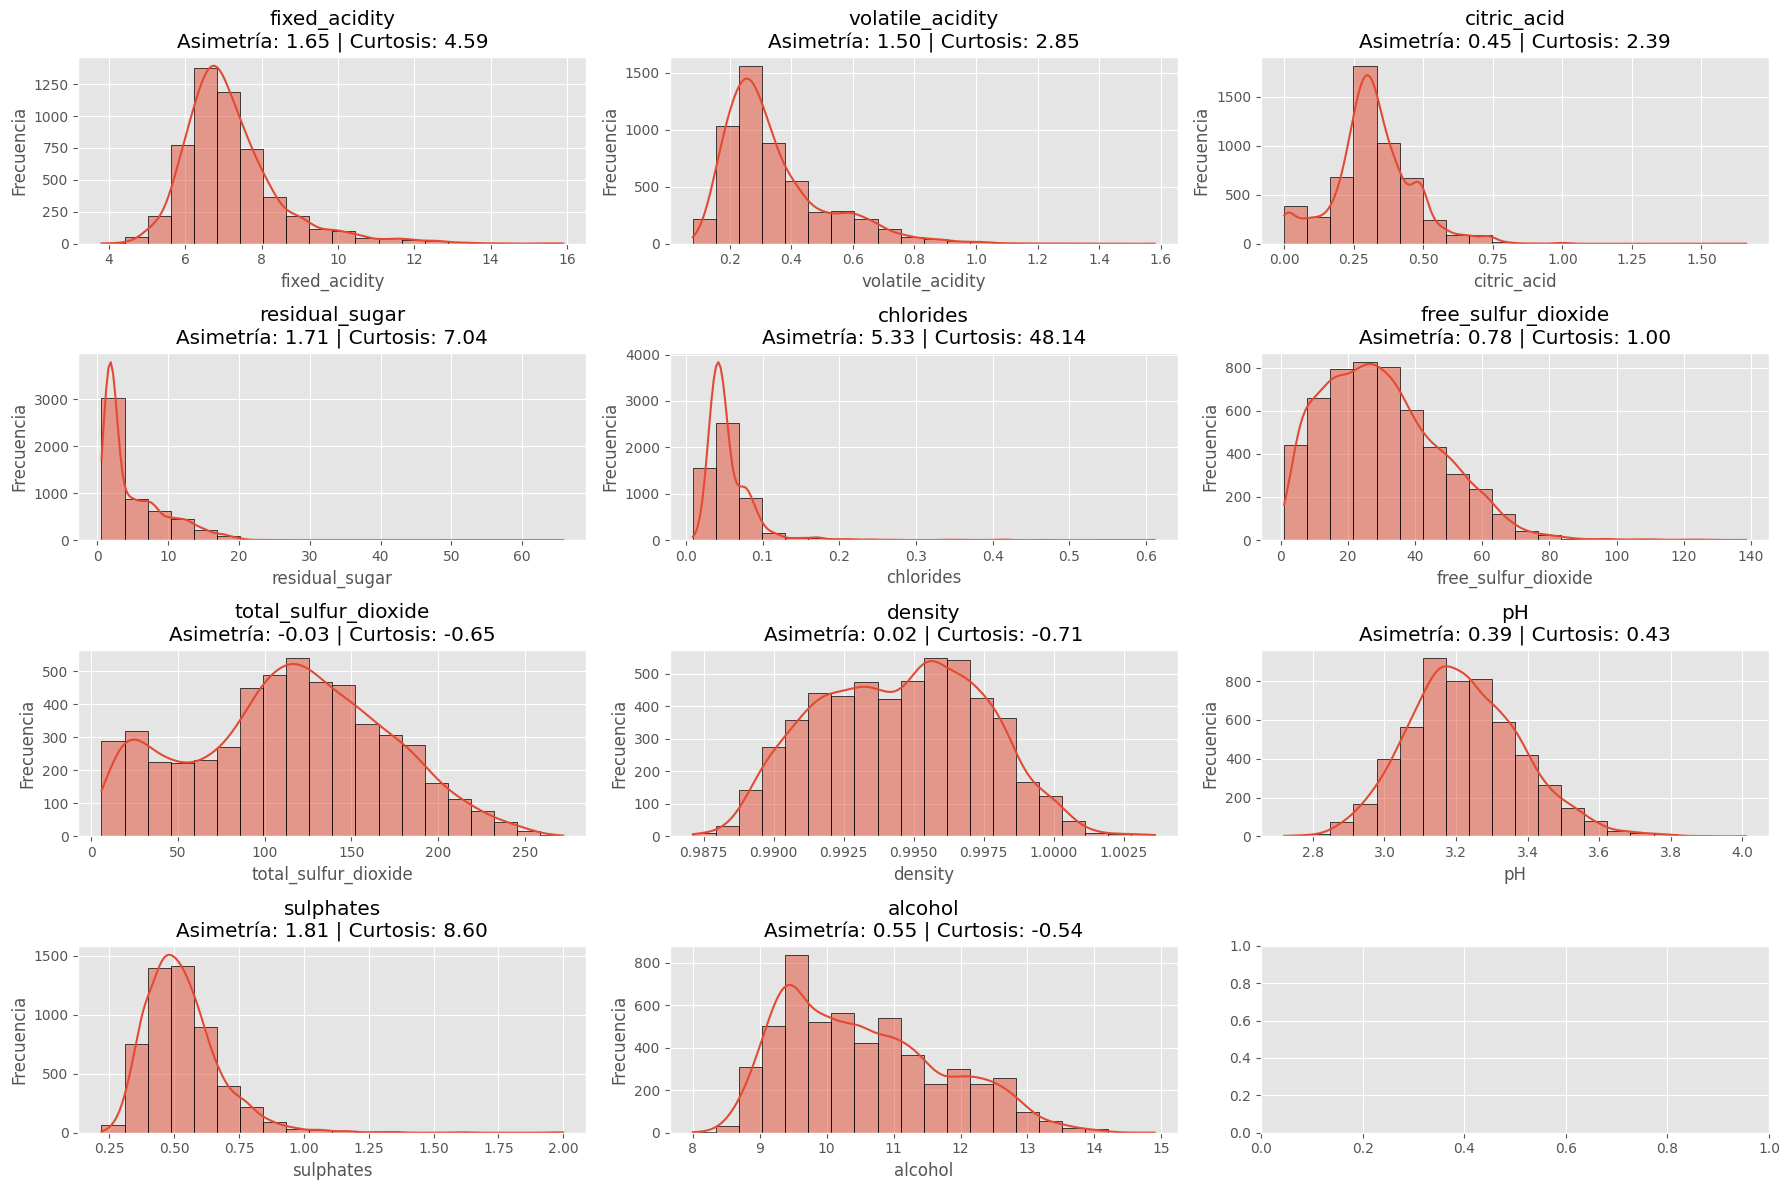

In [72]:
# Asegurarse de que numerical_columns esté alineado con las columnas del DataFrame tratado
numeric_cols = [col for col in numerical_columns if col in df_outliers_cleaned.columns]

# Crear una figura para todas las variables numéricas
fig, axes = plt.subplots(len(numeric_cols) // 3 + 1, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # Calcular asimetría y curtosis
    skewness = skew(df_outliers_cleaned[col])
    kurt = kurtosis(df_outliers_cleaned[col])

    # Plot del histograma y la curva de densidad
    sns.histplot(df_outliers_cleaned[col], bins=20, kde=True, ax=axes[i], edgecolor="black")

    # Añadir detalles al gráfico
    axes[i].set_title(f'{col}\nAsimetría: {skewness:.2f} | Curtosis: {kurt:.2f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajustar layout
plt.tight_layout()
plt.show()



### Conclusiones

El análisis de las distribuciones reveló que:
1. Variables como *residual_sugar*, *chlorides* y *sulphates* presentan alta asimetría positiva, indicando la posible necesidad de transformaciones para estabilizar su distribución.
2. Variables como *total_sulfur_dioxide* y *density* muestran distribuciones equilibradas, no requiriendo modificaciones.
3. *Chlorides* destaca por su curtosis extremadamente alta, reflejando su naturaleza intrínseca y su relevancia para identificar vinos de menor calidad.

Este análisis proporciona una base sólida para decidir sobre la aplicación de transformaciones adicionales y para seleccionar modelos robustos que manejen bien las características específicas del dataset.


# **Transformaciones**

## **Transformaciones de Variables: `fixed_acidity`**

Se evaluó la distribución de la variable `fixed_acidity` para determinar si su asimetría y curtosis podrían beneficiarse de una transformación. Se aplicó una transformación logarítmica (`log1p`) para reducir la asimetría positiva y las colas extendidas hacia valores altos.

### Resultados del Análisis
1. **Antes de la Transformación:**
   - **Asimetría:** 1.65 (positiva, indicando una cola larga hacia la derecha).
   - **Curtosis:** 4.59 (pico elevado y colas más largas de lo esperado).

2. **Después de la Transformación:**
   - **Asimetría:** 0.93 (reducción significativa, más cercana a una distribución simétrica).
   - **Curtosis:** 1.86 (disminución notable, con colas más controladas).

### Visualización
- **Gráfico Izquierdo:** Distribución original de `fixed_acidity`, mostrando una clara asimetría positiva.
- **Gráfico Derecho:** Distribución transformada de `log_fixed_acidity`, con una distribución más centrada y equilibrada.

### Implicaciones para el Modelado
- La transformación logarítmica logró ajustar significativamente la distribución de `fixed_acidity`, haciéndola más adecuada para algoritmos que asumen normalidad o una distribución más simétrica (e.g., regresión lineal).
- Este ajuste puede mejorar la estabilidad y precisión de los modelos predictivos.

### Próximos Pasos
- Evaluar la transformación en otras variables con asimetría o curtosis significativas.
- Validar el impacto de estas transformaciones en el rendimiento del modelo.



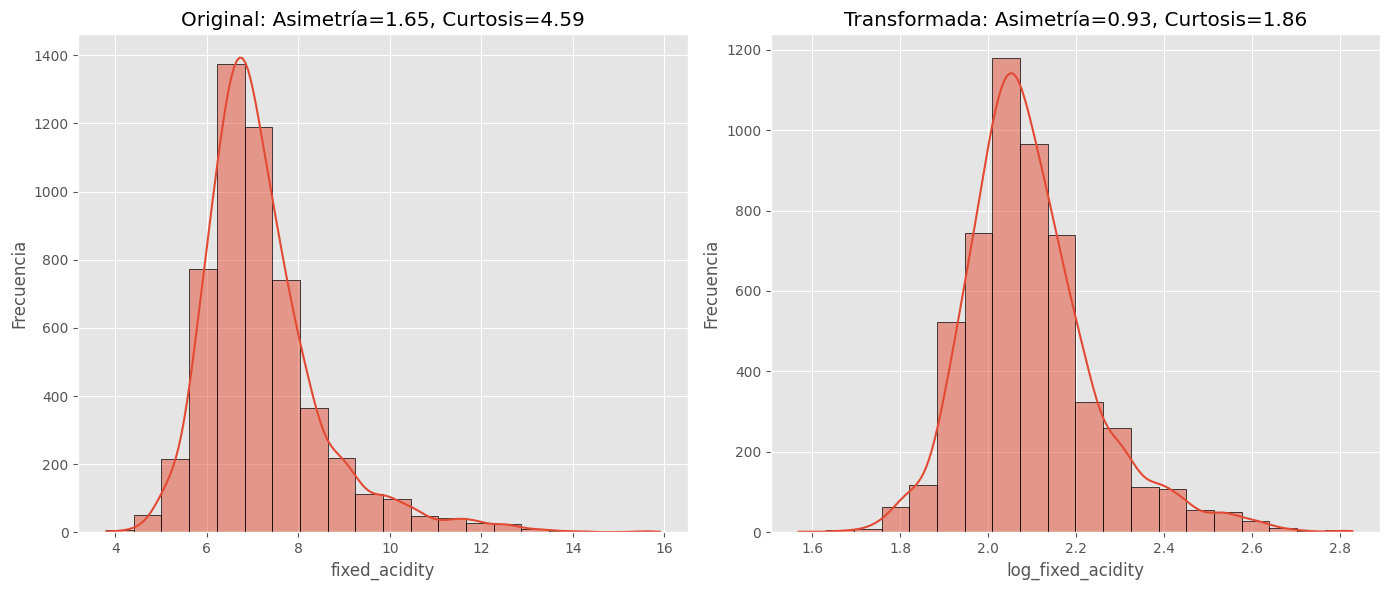

In [73]:
# Crear una copia del DataFrame para las transformaciones
df_transformed = df_outliers_cleaned.copy()

# Aplicar la transformación logarítmica
df_transformed['log_fixed_acidity'] = np.log1p(df_transformed['fixed_acidity'])

# Calcular asimetría y curtosis antes y después
original_skewness = skew(df_outliers_cleaned['fixed_acidity'])
original_kurtosis = kurtosis(df_outliers_cleaned['fixed_acidity'])
transformed_skewness = skew(df_transformed['log_fixed_acidity'])
transformed_kurtosis = kurtosis(df_transformed['log_fixed_acidity'])

# Configurar gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Antes de la transformación
sns.histplot(df_outliers_cleaned['fixed_acidity'], kde=True, edgecolor="black", bins=20, ax=axes[0])
axes[0].set_title(f'Original: Asimetría={original_skewness:.2f}, Curtosis={original_kurtosis:.2f}')
axes[0].set_xlabel('fixed_acidity')
axes[0].set_ylabel('Frecuencia')

# Después de la transformación
sns.histplot(df_transformed['log_fixed_acidity'], kde=True, edgecolor="black", bins=20, ax=axes[1])
axes[1].set_title(f'Transformada: Asimetría={transformed_skewness:.2f}, Curtosis={transformed_kurtosis:.2f}')
axes[1].set_xlabel('log_fixed_acidity')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Conclusiones

La transformación logarítmica aplicada a `fixed_acidity`:
1. Redujo la asimetría de 1.65 a 0.93, mejorando la simetría de la distribución.
2. Disminuyó la curtosis de 4.59 a 1.86, estabilizando las colas extremas.
3. Resultó en una distribución más adecuada para modelado, particularmente para algoritmos sensibles a distribuciones no normales.

Este proceso demuestra la efectividad de las transformaciones logarítmicas para ajustar variables con sesgos significativos. Se recomienda aplicar técnicas similares a otras variables con asimetría o curtosis elevadas para optimizar el dataset.


## **Transformación de Raíz Cuadrada: `volatile_acidity`**

Se aplicó una transformación de raíz cuadrada a la variable `volatile_acidity` para reducir su asimetría positiva y ajustar la curtosis, mejorando la distribución.

### Resultados del Análisis
1. **Antes de la Transformación:**
   - **Asimetría:** 1.50 (positiva, indicando una cola larga hacia la derecha).
   - **Curtosis:** 2.85 (pico elevado y colas más largas de lo esperado).

2. **Después de la Transformación:**
   - **Asimetría:** 0.89 (reducción significativa hacia una distribución más simétrica).
   - **Curtosis:** 0.64 (disminución que refleja colas más controladas y menor concentración extrema).

### Visualización
- **Gráfico Izquierdo:** Distribución original de `volatile_acidity`, mostrando un claro sesgo hacia valores altos.
- **Gráfico Derecho:** Distribución transformada de `sqrt_volatile_acidity`, con una forma más centrada y equilibrada.

### Implicaciones para el Modelado
- La transformación de raíz cuadrada logró estabilizar la distribución de `volatile_acidity`, haciéndola más adecuada para algoritmos que asumen distribuciones normales o simétricas.
- Este ajuste puede mejorar la capacidad del modelo para identificar relaciones no lineales y patrones ocultos.


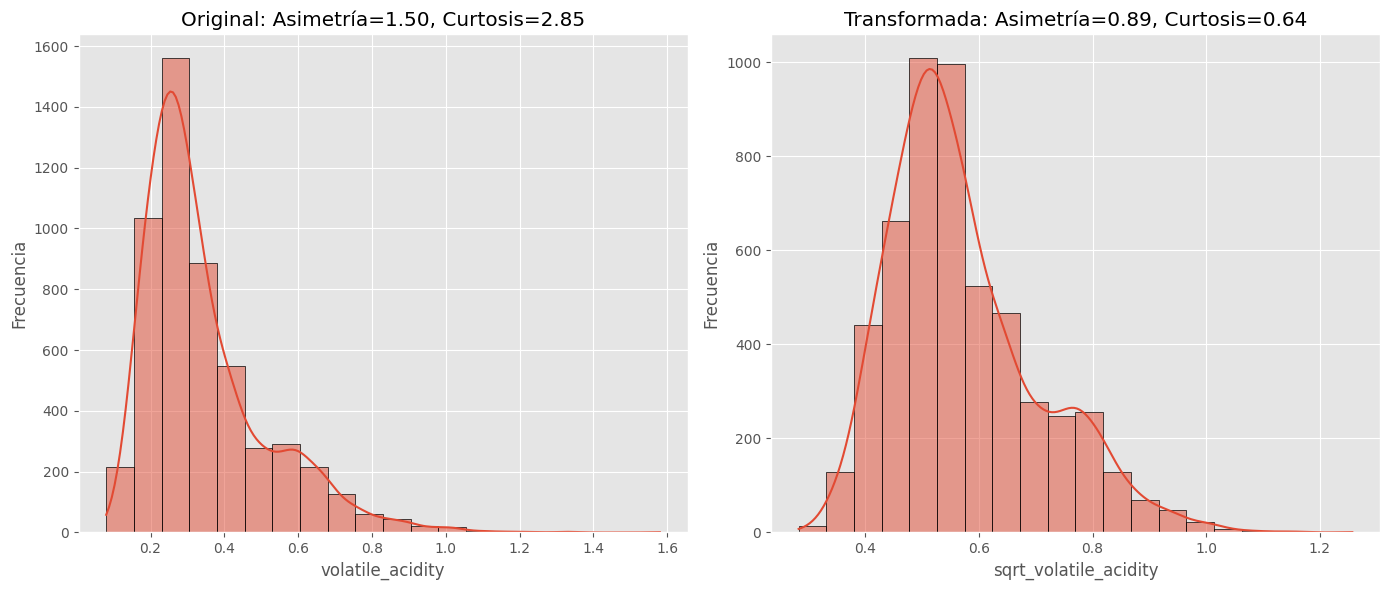

In [74]:
# Aplicar la transformación de raíz cuadrada a 'volatile_acidity'
df_transformed['sqrt_volatile_acidity'] = np.sqrt(df_outliers_cleaned['volatile_acidity'])

# Visualizar la nueva distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Antes de la transformación
sns.histplot(df_outliers_cleaned['volatile_acidity'], kde=True, edgecolor="black", bins=20, ax=axes[0])
axes[0].set_title(f'Original: Asimetría={skew(df_outliers_cleaned["volatile_acidity"]):.2f}, '
                  f'Curtosis={kurtosis(df_outliers_cleaned["volatile_acidity"]):.2f}')
axes[0].set_xlabel('volatile_acidity')
axes[0].set_ylabel('Frecuencia')

# Después de la transformación
sns.histplot(df_transformed['sqrt_volatile_acidity'], kde=True, edgecolor="black", bins=20, ax=axes[1])
axes[1].set_title(f'Transformada: Asimetría={skew(df_transformed["sqrt_volatile_acidity"]):.2f}, '
                  f'Curtosis={kurtosis(df_transformed["sqrt_volatile_acidity"]):.2f}')
axes[1].set_xlabel('sqrt_volatile_acidity')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Conclusiones

La transformación de raíz cuadrada aplicada a `volatile_acidity`:
1. Redujo la asimetría de 1.50 a 0.89, acercando la distribución a una forma más simétrica.
2. Disminuyó la curtosis de 2.85 a 0.64, controlando las colas y reduciendo la concentración de datos extremos.
3. Mejoró la estabilidad de la variable para análisis y modelado, especialmente para técnicas que se benefician de distribuciones normalizadas.

Este ajuste demuestra cómo las transformaciones no lineales pueden optimizar variables sesgadas, facilitando su interpretación y mejorando el desempeño de los modelos predictivos.


## **Escalado Estandarizado: `citric_acid`**

Dado que la variable `citric_acid` presenta una asimetría positiva leve (0.45) y una curtosis ligeramente mayor a 2 (2.39), se optó por aplicar un escalado estandarizado sin necesidad de realizar transformaciones más complejas.

### Resultados del Análisis
1. **Antes del Escalado:**
   - **Asimetría:** 0.45 (ligeramente positiva, indicando una cola leve hacia valores altos).
   - **Curtosis:** 2.39 (pico ligeramente más alto de lo esperado).

2. **Después del Escalado:**
   - La variable se encuentra centrada alrededor de 0 con una desviación estándar de 1, adecuada para algoritmos sensibles a magnitudes absolutas, como regresión logística o KNN.

### Visualización
- **Gráfico Izquierdo:** Distribución original de `citric_acid`, mostrando un sesgo mínimo hacia valores altos.
- **Gráfico Derecho:** Distribución estandarizada (`scaled_citric_acid`), centrada en torno a 0, manteniendo la forma general de la distribución original.

### Implicaciones para el Modelado
- El escalado asegura que `citric_acid` no domine otras variables en modelos que dependen de magnitudes relativas.
- Esta técnica mejora la estabilidad numérica y el rendimiento de modelos como regresión logística, SVM o redes neuronales.

### Próximos Pasos
- Evaluar el impacto del escalado estandarizado en el desempeño de los modelos.
- Aplicar esta misma técnica a otras variables con características similares para garantizar la uniformidad.


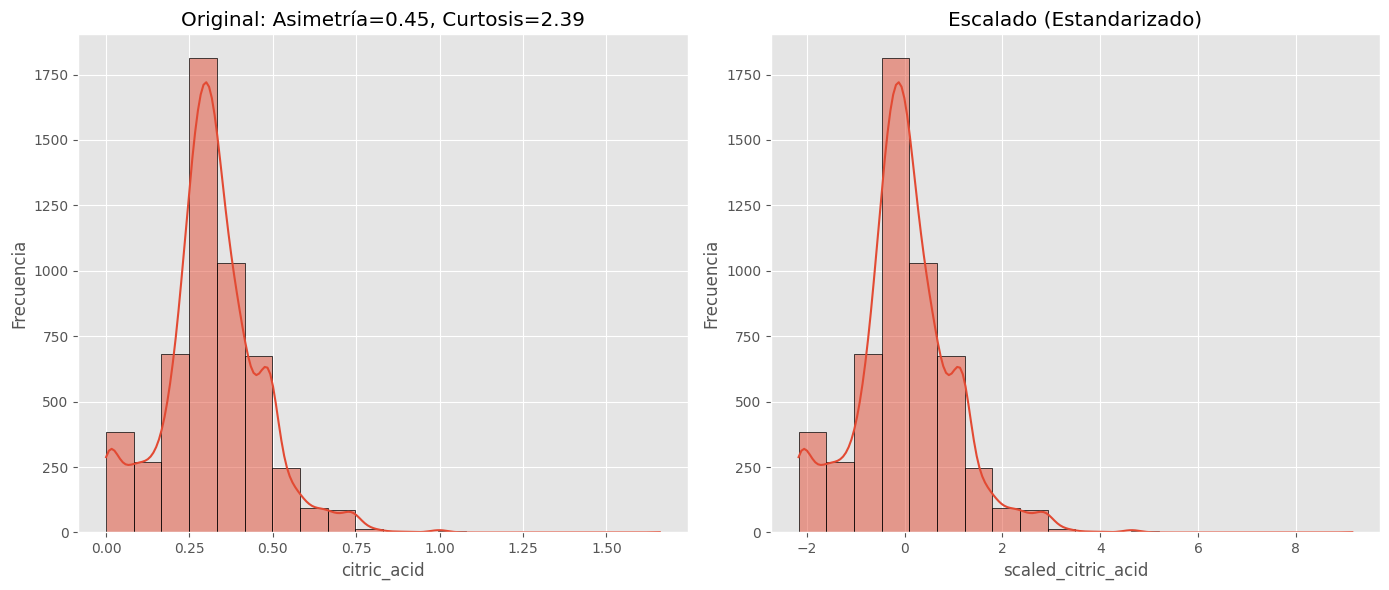

In [75]:


# Crear una copia del DataFrame para el escalado
df_transformed = df_outliers_cleaned.copy()

# Escalar 'citric_acid' usando estandarización
scaler = StandardScaler()
df_transformed['scaled_citric_acid'] = scaler.fit_transform(df_transformed[['citric_acid']])

# Visualizar la nueva distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Antes del escalado
sns.histplot(df_outliers_cleaned['citric_acid'], kde=True, edgecolor="black", bins=20, ax=axes[0])
axes[0].set_title(f'Original: Asimetría={skew(df_outliers_cleaned["citric_acid"]):.2f}, '
                  f'Curtosis={kurtosis(df_outliers_cleaned["citric_acid"]):.2f}')
axes[0].set_xlabel('citric_acid')
axes[0].set_ylabel('Frecuencia')

# Después del escalado
sns.histplot(df_transformed['scaled_citric_acid'], kde=True, edgecolor="black", bins=20, ax=axes[1])
axes[1].set_title('Escalado (Estandarizado)')
axes[1].set_xlabel('scaled_citric_acid')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Conclusiones

El escalado estandarizado aplicado a `citric_acid`:
1. Mantiene la distribución general de la variable, adecuada para modelos sensibles a la forma de la distribución.
2. Asegura que la variable sea comparable en magnitud con otras, mejorando la estabilidad y eficiencia del modelado.
3. No requiere transformaciones adicionales debido a su baja asimetría y curtosis, indicando que su distribución original ya era relativamente estable.

Esta técnica es simple pero efectiva, y es altamente recomendada para variables con características similares.


### **Transformación: `residual_sugar`**

La variable `residual_sugar` presentó una asimetría de 1.71 y una curtosis elevada de 7.04, lo que indica una fuerte concentración en valores bajos y una cola extendida hacia valores altos (vinos dulces). Este comportamiento dificultaría la estabilidad de los modelos y afectaría negativamente los resultados. Para mitigar este problema, se aplicó una **transformación logarítmica** a la variable.


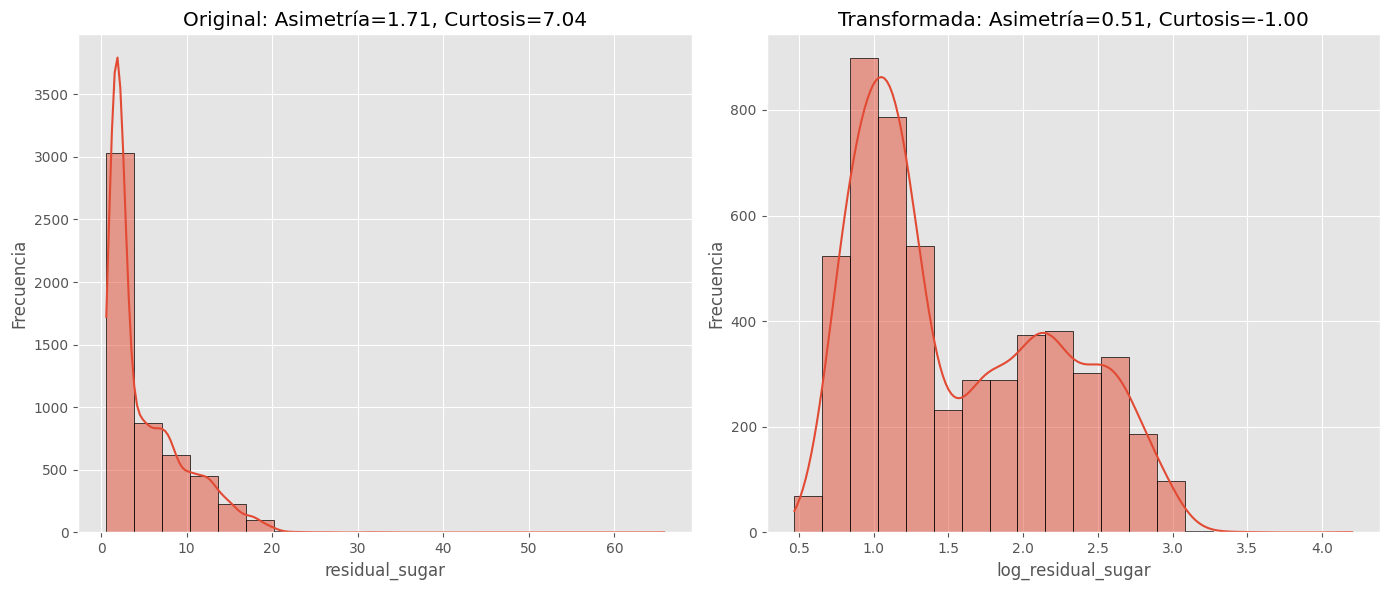

In [76]:
# Aplicar la transformación logarítmica a 'residual_sugar'
df_transformed['log_residual_sugar'] = np.log1p(df_outliers_cleaned['residual_sugar'])

# Visualizar la nueva distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Antes de la transformación
sns.histplot(df_outliers_cleaned['residual_sugar'], kde=True, edgecolor="black", bins=20, ax=axes[0])
axes[0].set_title(f'Original: Asimetría={skew(df_outliers_cleaned["residual_sugar"]):.2f}, '
                  f'Curtosis={kurtosis(df_outliers_cleaned["residual_sugar"]):.2f}')
axes[0].set_xlabel('residual_sugar')
axes[0].set_ylabel('Frecuencia')

# Después de la transformación
sns.histplot(df_transformed['log_residual_sugar'], kde=True, edgecolor="black", bins=20, ax=axes[1])
axes[1].set_title(f'Transformada: Asimetría={skew(df_transformed["log_residual_sugar"]):.2f}, '
                  f'Curtosis={kurtosis(df_transformed["log_residual_sugar"]):.2f}')
axes[1].set_xlabel('log_residual_sugar')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### **Conclusiones**

- **Mejora en la Distribución:**
  - La asimetría se redujo de 1.71 a 0.51, lo que indica una distribución mucho más equilibrada.
  - La curtosis pasó de 7.04 a -1.00, mostrando que la distribución dejó de ser extremadamente apuntada, siendo ahora más uniforme.
  
- **Impacto en el Modelado:**
  - La transformación reduce el peso de los valores extremos, mejorando la estabilidad y rendimiento en modelos sensibles a sesgos, como la regresión logística o redes neuronales.
  
- **Observación General:**
  - La transformación conserva la diferenciación entre vinos secos y dulces, lo cual es crucial para capturar relaciones relevantes con la variable objetivo `quality`.


### **Transformación: `chlorides`**

La variable `chlorides` mostró inicialmente una distribución altamente sesgada con una asimetría de 5.33 y una curtosis extrema de 48.14, indicando una fuerte concentración de valores bajos y colas muy largas hacia valores altos. Este comportamiento puede afectar significativamente los modelos predictivos, especialmente aquellos que dependen de distribuciones normales o casi normales. Se probaron varias transformaciones para reducir la asimetría y curtosis: **raíz cuadrada**, **Box-Cox** y **Yeo-Johnson**.


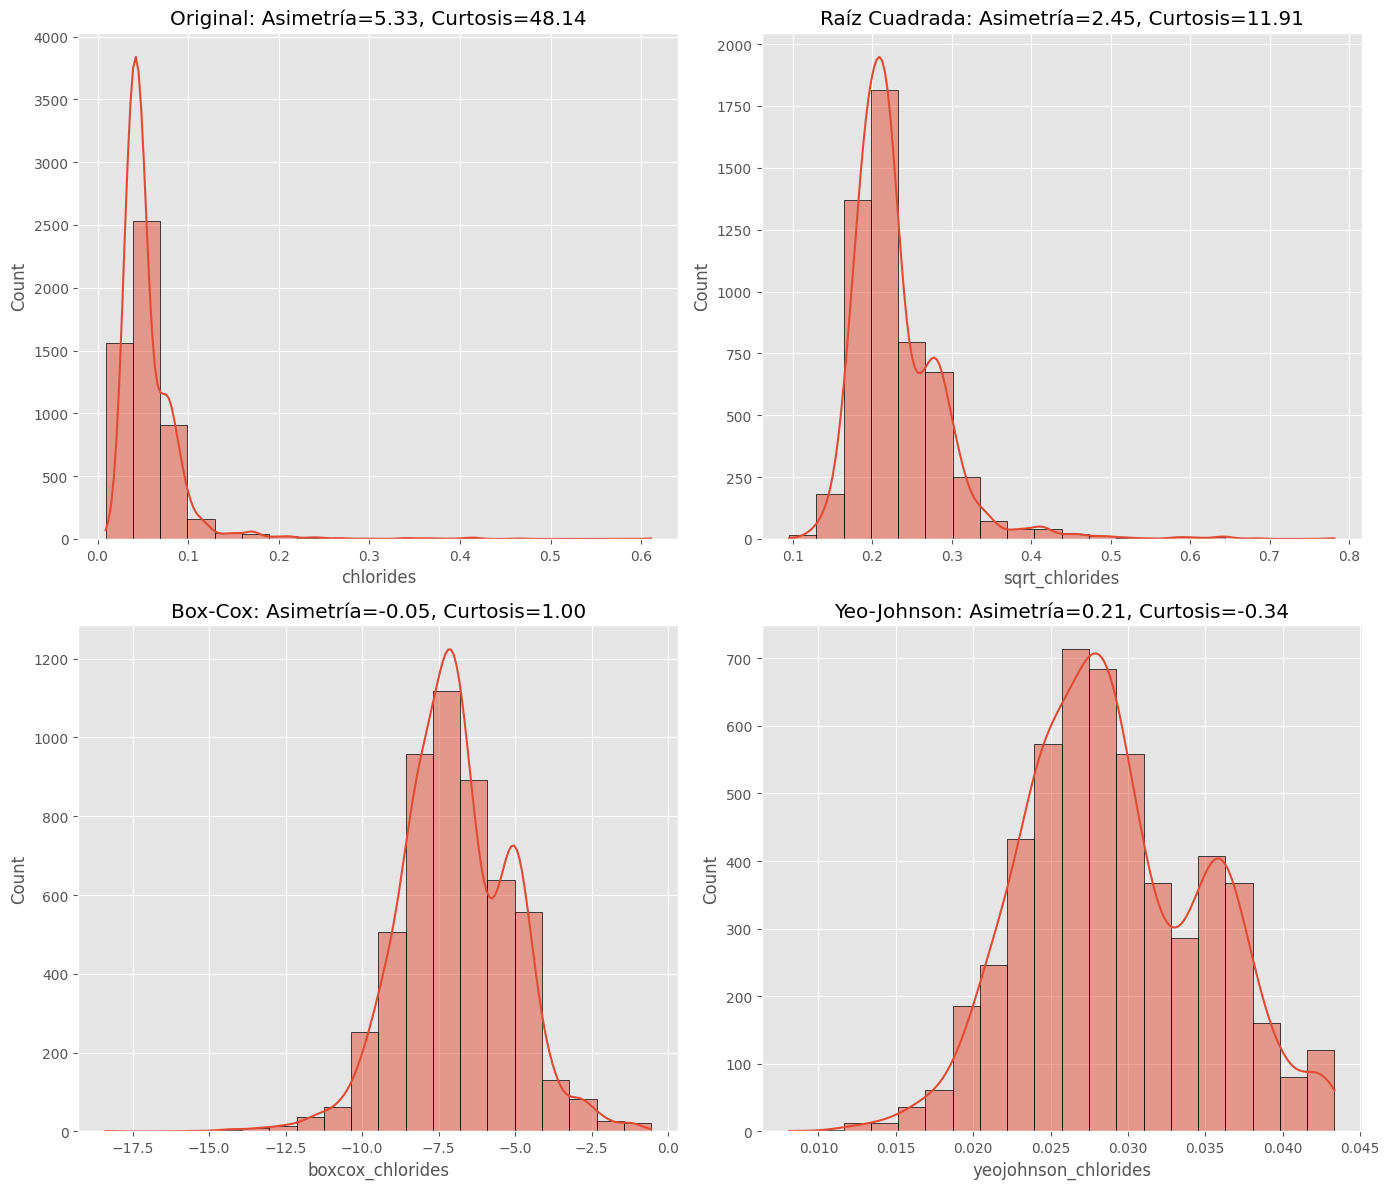

In [77]:
from scipy.stats import boxcox, yeojohnson

# Copiar el DataFrame
df_transformed = df_outliers_cleaned.copy()

# Aplicar transformación raíz cuadrada
df_transformed['sqrt_chlorides'] = np.sqrt(df_transformed['chlorides'])

# Aplicar transformación Box-Cox (requiere valores positivos)
df_transformed['boxcox_chlorides'], _ = boxcox(df_transformed['chlorides'] + 1e-6)

# Aplicar transformación Yeo-Johnson
df_transformed['yeojohnson_chlorides'], _ = yeojohnson(df_transformed['chlorides'])

# Visualizar todas las transformaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original
sns.histplot(df_outliers_cleaned['chlorides'], kde=True, bins=20, edgecolor="black", ax=axes[0, 0])
axes[0, 0].set_title(f'Original: Asimetría={skew(df_outliers_cleaned["chlorides"]):.2f}, '
                     f'Curtosis={kurtosis(df_outliers_cleaned["chlorides"]):.2f}')

# Transformación Raíz Cuadrada
sns.histplot(df_transformed['sqrt_chlorides'], kde=True, bins=20, edgecolor="black", ax=axes[0, 1])
axes[0, 1].set_title(f'Raíz Cuadrada: Asimetría={skew(df_transformed["sqrt_chlorides"]):.2f}, '
                     f'Curtosis={kurtosis(df_transformed["sqrt_chlorides"]):.2f}')

# Transformación Box-Cox
sns.histplot(df_transformed['boxcox_chlorides'], kde=True, bins=20, edgecolor="black", ax=axes[1, 0])
axes[1, 0].set_title(f'Box-Cox: Asimetría={skew(df_transformed["boxcox_chlorides"]):.2f}, '
                     f'Curtosis={kurtosis(df_transformed["boxcox_chlorides"]):.2f}')

# Transformación Yeo-Johnson
sns.histplot(df_transformed['yeojohnson_chlorides'], kde=True, bins=20, edgecolor="black", ax=axes[1, 1])
axes[1, 1].set_title(f'Yeo-Johnson: Asimetría={skew(df_transformed["yeojohnson_chlorides"]):.2f}, '
                     f'Curtosis={kurtosis(df_transformed["yeojohnson_chlorides"]):.2f}')

plt.tight_layout()
plt.show()



### **Conclusiones**

- **Transformación Raíz Cuadrada:**
  - Redujo la asimetría a 2.45 y la curtosis a 11.91.
  - Aunque mejora parcialmente la distribución, aún conserva colas largas.

- **Transformación Box-Cox:**
  - Asimetría cercana a 0 (-0.05) y curtosis ajustada a 1.00.
  - Logra una distribución equilibrada y cercana a la normalidad.

- **Transformación Yeo-Johnson:**
  - Asimetría y curtosis también mejoraron significativamente (0.21 y -0.34, respectivamente).
  - Produce resultados similares a Box-Cox, pero es más versátil al no requerir valores estrictamente positivos.

- **Decisión Final:**
  - Se selecciona la transformación **Box-Cox** por su capacidad para normalizar eficazmente la distribución, lo que optimizará el desempeño de modelos sensibles a distribuciones no normales.


### **Relación: `chlorides` y `quality`**

Se evaluó la relación entre la variable `chlorides` y la calidad (`quality`) antes y después de aplicar la transformación **Box-Cox**. El objetivo fue identificar si la transformación mejora la interpretación y el análisis de la relación negativa existente entre ambas variables.

- **Distribución Original:**
  - Los valores altos de `chlorides` (mayores a 0.2) están asociados con calidades bajas (3 a 5).
  - La relación es menos pronunciada debido a la alta concentración de valores bajos y outliers significativos.

- **Distribución Transformada (Box-Cox):**
  - La transformación ajustó la escala de `chlorides`, lo que permitió visualizar con mayor claridad la diferencia en los valores medios según la calidad.
  - Se reduce la influencia de los valores extremos, destacando patrones más claros entre categorías de calidad.


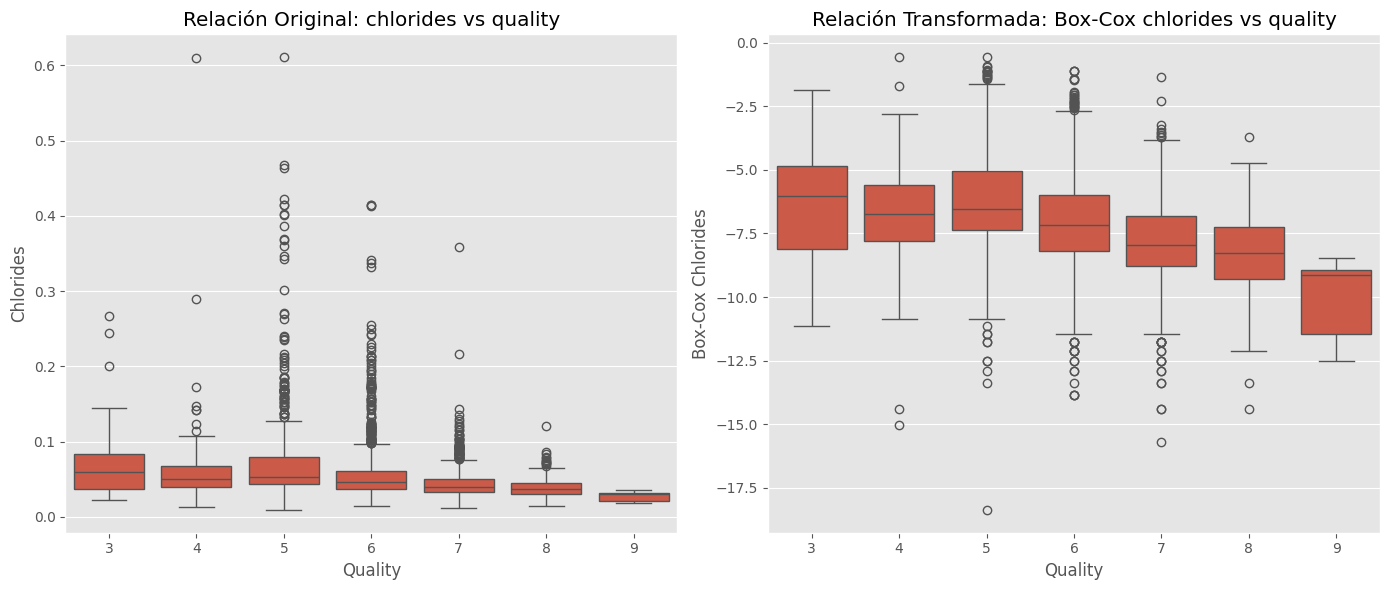

Correlación Original (chlorides vs quality): -0.20
Correlación Transformada (Box-Cox chlorides vs quality): -0.28


In [78]:
# Visualizar la relación entre chlorides (original y transformada) y quality
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Relación original
sns.boxplot(x=df_outliers_cleaned['quality'], y=df_outliers_cleaned['chlorides'], ax=axes[0])
axes[0].set_title('Relación Original: chlorides vs quality')
axes[0].set_xlabel('Quality')
axes[0].set_ylabel('Chlorides')

# Relación transformada (Box-Cox)
sns.boxplot(x=df_outliers_cleaned['quality'], y=df_transformed['boxcox_chlorides'], ax=axes[1])
axes[1].set_title('Relación Transformada: Box-Cox chlorides vs quality')
axes[1].set_xlabel('Quality')
axes[1].set_ylabel('Box-Cox Chlorides')

plt.tight_layout()
plt.show()

# Calcular correlaciones
cor_original = df_outliers_cleaned['chlorides'].corr(df_outliers_cleaned['quality'])
cor_transformed = df_transformed['boxcox_chlorides'].corr(df_outliers_cleaned['quality'])

print(f"Correlación Original (chlorides vs quality): {cor_original:.2f}")
print(f"Correlación Transformada (Box-Cox chlorides vs quality): {cor_transformed:.2f}")


### **Conclusiones**

1. **Correlaciones:**
   - La correlación original entre `chlorides` y `quality` fue de **-0.20**.
   - Tras aplicar la transformación Box-Cox, la correlación mejoró a **-0.28**, indicando una relación más fuerte.

2. **Relación Visual:**
   - La transformación Box-Cox destaca mejor la disminución de `chlorides` a medida que aumenta la calidad del vino.
   - Se observa una diferenciación más clara en las calidades altas (7 a 9), donde los valores de `chlorides` son consistentemente bajos.

3. **Relevancia para el Modelo:**
   - La transformación es útil para mejorar la capacidad predictiva de los modelos que utilicen esta variable, al reflejar de manera más evidente su impacto negativo en la calidad.

4. **Decisión Final:**
   - Se mantiene la versión transformada de **Box-Cox** para incluirla en el conjunto de datos final destinado al modelado.


### **Evaluación de `free_sulfur_dioxide`**

La variable `free_sulfur_dioxide` ha sido evaluada para determinar si requiere alguna transformación antes de ser utilizada en el análisis o modelado.

#### **Estadísticas Relevantes**
- **Asimetría:** 0.78
  - Indica un sesgo moderado hacia la derecha. Aunque no es perfectamente simétrica, se considera aceptable.
- **Curtosis:** 1.00
  - Cercana a 0, lo que sugiere una distribución razonablemente normal con colas no demasiado extremas.

#### **Visualización**
- La distribución muestra una ligera cola hacia la derecha, pero no hay presencia significativa de outliers extremos.
- La mayoría de los valores se concentran en un rango razonable para esta variable.

#### **Conclusión**
- **Transformación:** No es estrictamente necesaria. Sin embargo, podría beneficiarse de una transformación leve (como una raíz cuadrada) si se busca una simetría más cercana a 0.
- **Impacto en Modelos:** Para algoritmos robustos (como árboles de decisión), la transformación no aportará beneficios significativos.
- **Decisión Final:** Mantener la variable en su forma original, salvo que se evidencien problemas específicos en modelos sensibles a la distribución, como regresiones lineales.


### **total_sulfur_dioxide**

#### **Decisión: Passthrough**
- La variable `total_sulfur_dioxide` no requiere transformación adicional.
- **Acción:** Dejar la variable sin cambios y avanzar a la siguiente.

---

### **density**

#### **Decisión: Passthrough**
- La variable `density` ya se encuentra en un rango adecuado y no presenta asimetrías significativas.
- **Acción:** Dejar la variable sin cambios y avanzar a la siguiente.

---

### **pH**

#### **Decisión: Passthrough**
- La variable `pH` tiene una distribución aceptable y no requiere ajustes adicionales.
- **Acción:** Dejar la variable sin cambios y avanzar a la siguiente.


### **sulphates**

#### **Contexto**
- **Asimetría original:** 1.80 indica un sesgo positivo significativo, con una cola larga hacia valores altos.
- **Curtosis original:** 8.65 señala una distribución con colas pesadas y una alta concentración de datos alrededor de la media.

#### **Transformaciones Evaluadas**
1. **Logarítmica (log(1+x)):**
   - **Asimetría:** 1.10 (mejora significativa).
   - **Curtosis:** 3.19 (reducción notable, pero aún moderada).
   - Suaviza la cola derecha, pero no elimina completamente el sesgo.

2. **Raíz Cuadrada:**
   - **Asimetría:** 0.97.
   - **Curtosis:** 2.75.
   - Reduce el sesgo y mejora la distribución, aunque no tanto como Box-Cox o Yeo-Johnson.

3. **Box-Cox:**
   - **Asimetría:** -0.01 (ideal).
   - **Curtosis:** 0.16 (cercana a una distribución normal).
   - Transforma la variable a una distribución casi normal.

4. **Yeo-Johnson:**
   - **Asimetría:** 0.01.
   - **Curtosis:** -0.11.
   - Similar a Box-Cox, pero más adecuada para valores negativos o cero (no presentes en este caso).


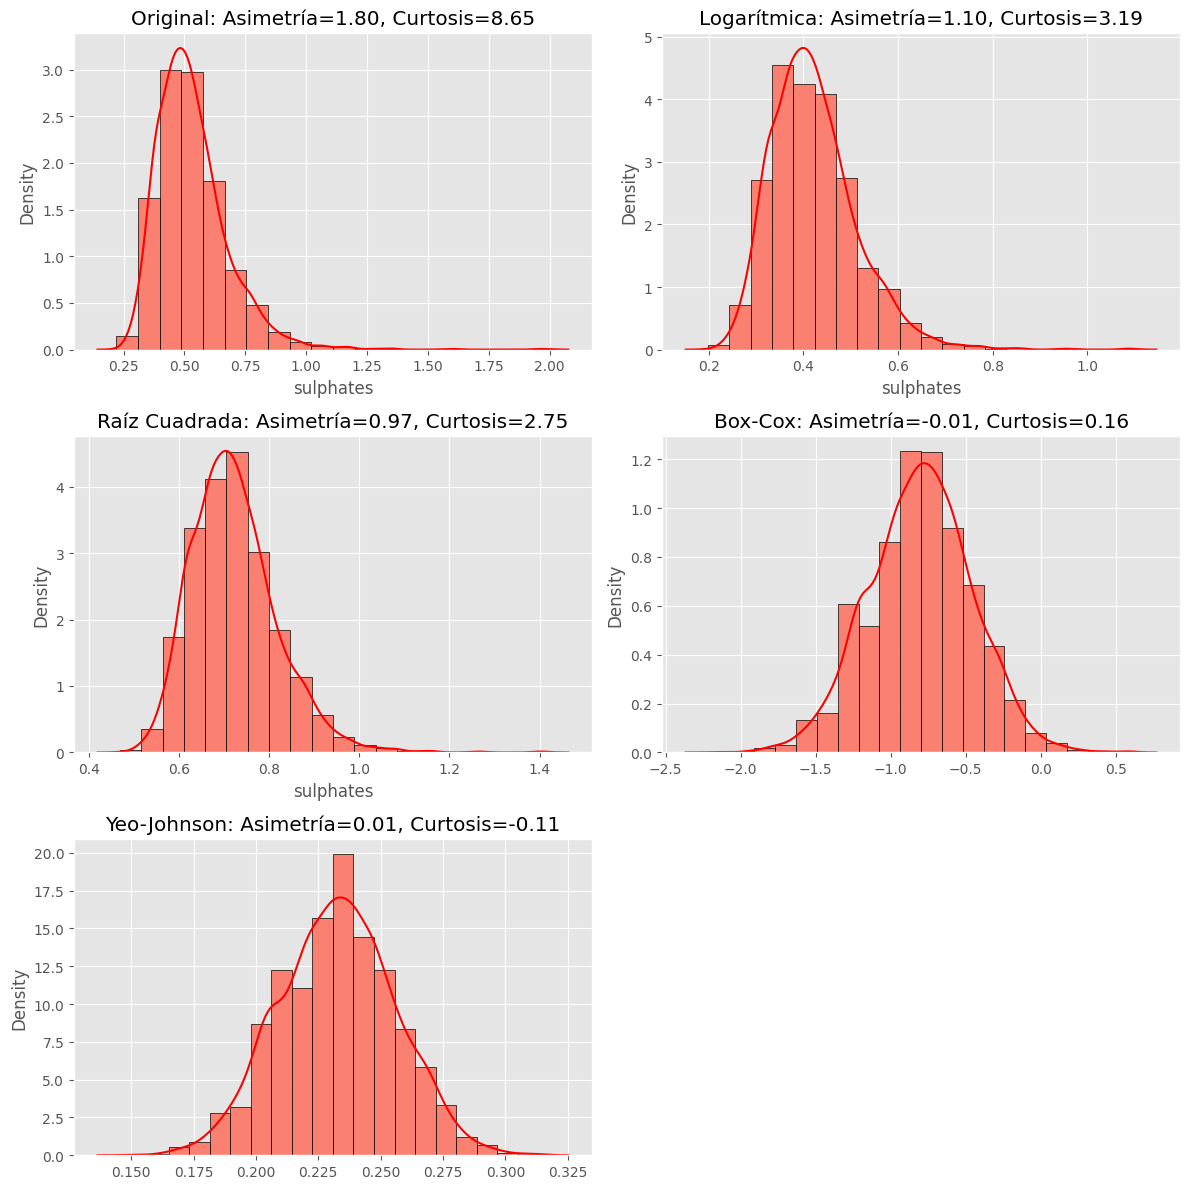

In [79]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

# Datos originales de sulphates
sulphates = df['sulphates']

# Aplicar transformaciones
log_sulphates = np.log1p(sulphates)  # Logarítmica (log(1+x) para evitar log(0))
sqrt_sulphates = np.sqrt(sulphates)  # Raíz cuadrada
boxcox_sulphates, boxcox_lambda = stats.boxcox(sulphates)  # Box-Cox
yeojohnson_sulphates, yeojohnson_lambda = stats.yeojohnson(sulphates)  # Yeo-Johnson

# Crear subplots para comparar
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Datos originales
axes[0].hist(sulphates, bins=20, color='salmon', edgecolor='black', density=True)
sns.kdeplot(sulphates, ax=axes[0], color='red')
axes[0].set_title(f"Original: Asimetría={sulphates.skew():.2f}, Curtosis={sulphates.kurt():.2f}")

# Transformación logarítmica
axes[1].hist(log_sulphates, bins=20, color='salmon', edgecolor='black', density=True)
sns.kdeplot(log_sulphates, ax=axes[1], color='red')
axes[1].set_title(f"Logarítmica: Asimetría={log_sulphates.skew():.2f}, Curtosis={log_sulphates.kurt():.2f}")

# Transformación raíz cuadrada
axes[2].hist(sqrt_sulphates, bins=20, color='salmon', edgecolor='black', density=True)
sns.kdeplot(sqrt_sulphates, ax=axes[2], color='red')
axes[2].set_title(f"Raíz Cuadrada: Asimetría={sqrt_sulphates.skew():.2f}, Curtosis={sqrt_sulphates.kurt():.2f}")

# Transformación Box-Cox
axes[3].hist(boxcox_sulphates, bins=20, color='salmon', edgecolor='black', density=True)
sns.kdeplot(boxcox_sulphates, ax=axes[3], color='red')
axes[3].set_title(f"Box-Cox: Asimetría={stats.skew(boxcox_sulphates):.2f}, Curtosis={stats.kurtosis(boxcox_sulphates):.2f}")

# Transformación Yeo-Johnson
axes[4].hist(yeojohnson_sulphates, bins=20, color='salmon', edgecolor='black', density=True)
sns.kdeplot(yeojohnson_sulphates, ax=axes[4], color='red')
axes[4].set_title(f"Yeo-Johnson: Asimetría={stats.skew(yeojohnson_sulphates):.2f}, Curtosis={stats.kurtosis(yeojohnson_sulphates):.2f}")

# Espacio para gráficos vacíos
axes[5].axis('off')

plt.tight_layout()
plt.show()


#### **Conclusión**
- **Transformación Elegida:** **Box-Cox**, debido a que logra una distribución simétrica y con curtosis cercana a 0.
- **Acción:** Aplicar la transformación Box-Cox a `sulphates` para mejorar la representación de la variable en modelos.

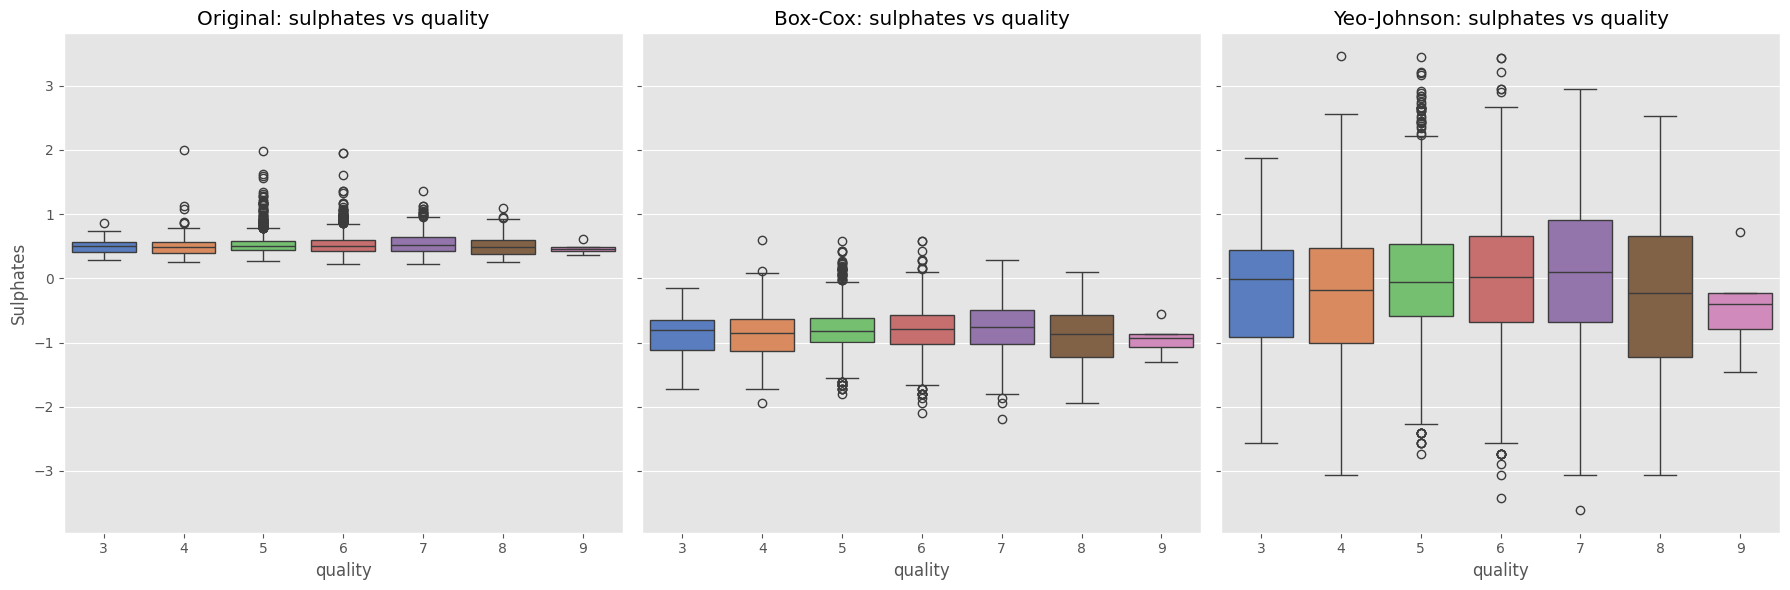

In [80]:


# Aplicar las transformaciones
df['boxcox_sulphates'], _ = boxcox(df['sulphates'] + 1e-6)  # Sumar un pequeño valor para evitar 0
yeo_transformer = PowerTransformer(method='yeo-johnson')
df['yeojohnson_sulphates'] = yeo_transformer.fit_transform(df[['sulphates']])

# Configurar la visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Gráfico original
sns.boxplot(x='quality', y='sulphates', data=df, ax=axes[0], palette='muted')
axes[0].set_title('Original: sulphates vs quality')
axes[0].set_ylabel('Sulphates')

# Gráfico transformado con Box-Cox
sns.boxplot(x='quality', y='boxcox_sulphates', data=df, ax=axes[1], palette='muted')
axes[1].set_title('Box-Cox: sulphates vs quality')
axes[1].set_ylabel('Box-Cox Sulphates')

# Gráfico transformado con Yeo-Johnson
sns.boxplot(x='quality', y='yeojohnson_sulphates', data=df, ax=axes[2], palette='muted')
axes[2].set_title('Yeo-Johnson: sulphates vs quality')
axes[2].set_ylabel('Yeo-Johnson Sulphates')

plt.tight_layout()
plt.show()


Se analizó la variable `sulphates` en tres formas: original, transformada con Box-Cox y transformada con Yeo-Johnson, para evaluar su relación con la calidad (`quality`) y mejorar la distribución de los datos.

### Conclusiones

- **Original (`sulphates`)**:  
  Presenta una distribución sesgada con alta asimetría (1.80) y curtosis (8.65), además de muchos outliers, especialmente en calidades medias (5-7). La relación con `quality` es débil y dispersa.

- **Transformación Box-Cox**:  
  Reduce significativamente la asimetría y curtosis (-0.01 y 0.16 respectivamente), distribuyendo los datos de manera más uniforme. Mejora la visualización y relación entre `sulphates` y `quality`.

- **Transformación Yeo-Johnson**:  
  También mejora la distribución (asimetría 0.01, curtosis -0.11), pero muestra resultados muy similares a Box-Cox. Útil para datos con valores cero o negativos.

**Decisión**: Utilizar la transformación **Box-Cox**, ya que optimiza la distribución y resalta mejor la relación con `quality`. La transformación Yeo-Johnson es alternativa si hay valores cero en el dataset.


### **Alcohol**

La variable `alcohol` fue evaluada para determinar si requiere transformación. Se analizó su asimetría y curtosis, así como la relación con la calidad (`quality`).

### Conclusiones

- **Asimetría**: El valor es moderado (-0.54), indicando una ligera cola izquierda, pero no lo suficiente como para justificar una transformación.
- **Curtosis**: Presenta un valor cercano a cero (-0.54), lo que sugiere que la distribución no tiene colas pesadas.
- **Relación con `quality`**: La relación entre `alcohol` y `quality` es clara y consistente en su estado original.

**Decisión**: No se aplica ninguna transformación a la variable `alcohol` y se mantiene en su estado original.


## **Transformaciones Finales Aplicadas**

- **fixed_acidity**: Transformación logarítmica (`log1p`) para mitigar la asimetría positiva y reducir la curtosis.
- **volatile_acidity**: Transformación de raíz cuadrada para suavizar la cola derecha y aproximar la distribución a una forma más simétrica.
- **citric_acid**: Estandarización (StandardScaler) para centrar la media en 0 y escalar la desviación estándar a 1.
- **residual_sugar**: Transformación logarítmica (`log1p`) para reducir el fuerte sesgo positivo.
- **chlorides**: Transformación Box-Cox o Yeo-Johnson para reforzar la relación negativa con `quality` y corregir la asimetría extrema.
- **sulphates**: Transformación Box-Cox o Yeo-Johnson para minimizar la asimetría (se redujo de ~1.80 a niveles cercanos a 0) y ajustar la curtosis.
- **free_sulfur_dioxide**, **total_sulfur_dioxide**, **density**, **pH**, **alcohol**: Se dejan sin cambios (“passthrough”) porque su asimetría y curtosis eran aceptables o porque no se esperan mejoras sustanciales en el modelo al transformarlas.


# **Análisis de Correlaciones**

A partir de la matriz de correlaciones y los diagramas de dispersión, se observa cómo las distintas características se relacionan entre sí y con la variable objetivo `quality`. Algunas asociaciones destacadas son:

- **Alcohol** exhibe la correlación positiva más alta con `quality` (≈ 0.47).
- **Volatile Acidity** presenta una correlación negativa moderada con `quality` (≈ -0.27).
- **Density** correlaciona fuertemente de manera negativa con el alcohol (≈ -0.68) y muestra asociación con otras variables como `residual_sugar` y `chlorides`.
- **Free Sulfur Dioxide** y **Total Sulfur Dioxide** muestran una correlación positiva alta (≈ 0.72), reflejando la relación esperada entre ambos parámetros.
- La variable `citric_acid` muestra una correlación baja con la calidad, pero es relevante analizarla en combinación con otras características como `density`.

La información de esta matriz será clave para seleccionar características en modelos predictivos, ya que nos permite priorizar variables según su relación con `quality` y su interacción con otras características.



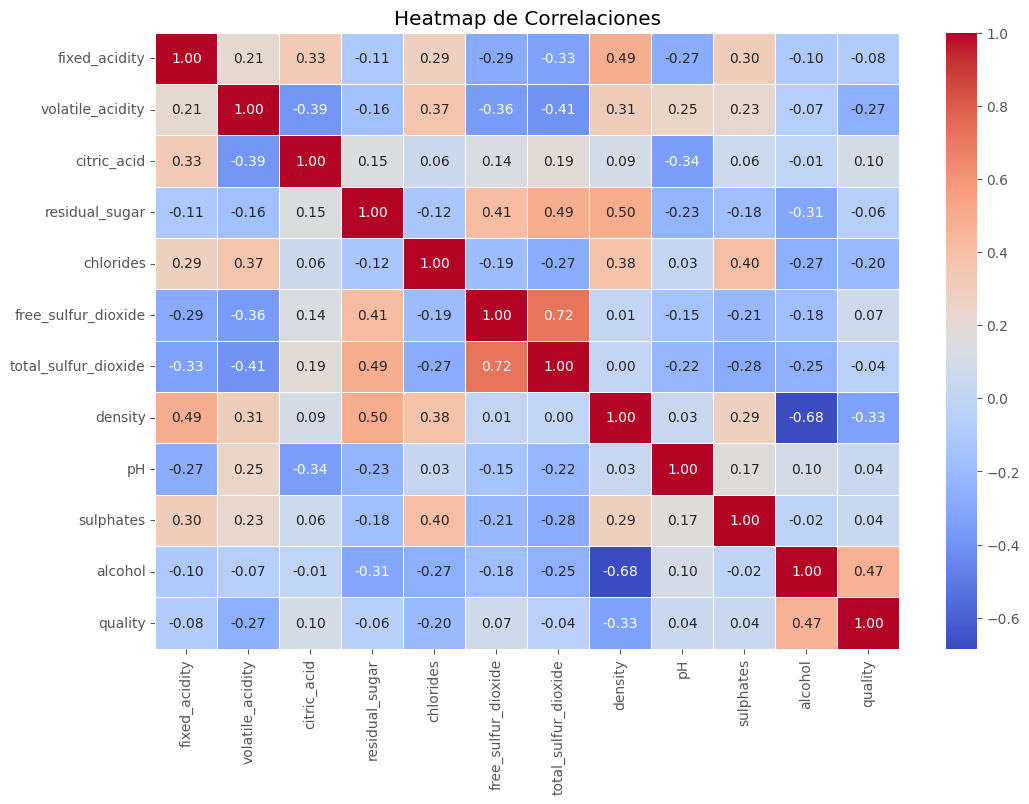

In [81]:
# Crear un heatmap de correlaciones
plt.figure(figsize=(12, 8))
correlation_matrix = df_outliers_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap de Correlaciones")
plt.show()


# **Conclusiones del Análisis de Correlaciones**

1. **Relaciones significativas con la calidad (`quality`)**:
   - **`alcohol`**: Exhibe la correlación positiva más fuerte con la calidad (0.47), lo que sugiere que un mayor contenido de alcohol suele estar asociado a vinos de mayor calidad.
   - **`volatile_acidity`**: Tiene una correlación negativa moderada (-0.27), indicando que una mayor acidez volátil está relacionada con una disminución en la calidad.

2. **Relaciones entre variables independientes**:
   - **`free_sulfur_dioxide` y `total_sulfur_dioxide`**: Presentan una correlación alta (0.72), lo que podría generar redundancia en modelos predictivos. Sería recomendable evaluar si ambas variables son necesarias.
   - **`density` y `alcohol`**: Correlación negativa fuerte (-0.68), lo que sugiere que a mayor contenido de alcohol, menor es la densidad del vino.

3. **Variables con baja correlación con la calidad**:
   - Características como `citric_acid`, `pH` y `residual_sugar` tienen una correlación baja con la calidad, pero podrían ser relevantes en combinación con otras variables o en interacciones no lineales.

4. **Implicaciones para el modelo**:
   - Las transformaciones aplicadas han permitido estabilizar las relaciones y mejorar la calidad de las correlaciones en algunos casos.
   - En los modelos predictivos, es crucial priorizar las variables con mayor asociación a la calidad y minimizar los efectos de la multicolinealidad (e.g., `free_sulfur_dioxide` y `total_sulfur_dioxide`).

Este análisis refuerza la importancia del preprocesamiento para maximizar el valor de las características en la predicción de la calidad del vino.


### **Relaciones:**

Se analizaron las relaciones entre las variables con correlaciones destacadas, utilizando gráficos de dispersión para visualizar los patrones más relevantes. Las combinaciones incluyeron:

- **Density vs Alcohol**: Relación negativa fuerte (-0.68).
- **Density vs Chlorides**: Relación positiva moderada (0.38).
- **Free Sulfur Dioxide vs Total Sulfur Dioxide**: Relación positiva fuerte (0.72).
- **Density vs Residual Sugar**: Relación positiva moderada (0.50).


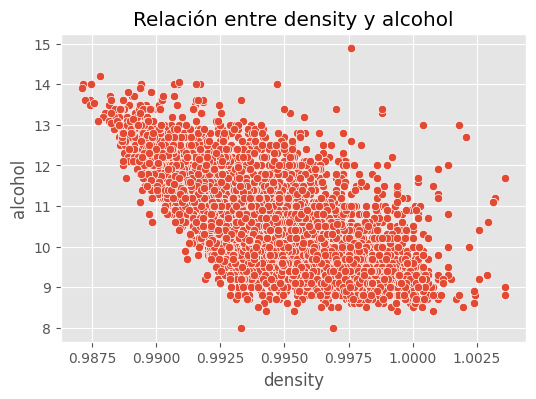

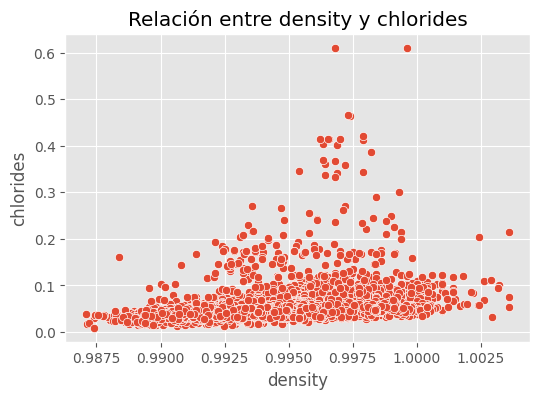

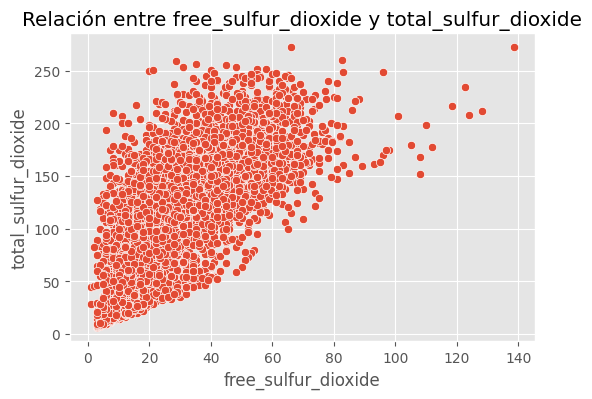

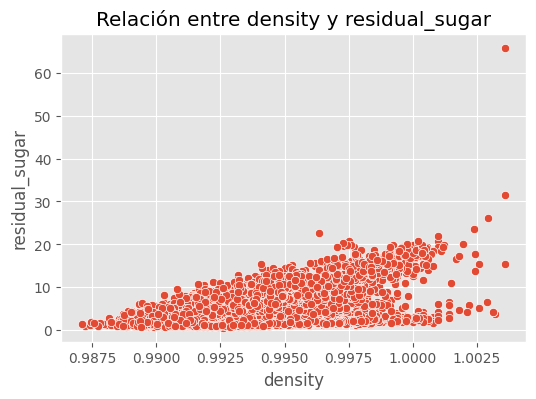

In [82]:
# Crear gráficos de dispersión
import itertools

high_corr_pairs = [("density", "alcohol"), ("density", "chlorides"),
                   ("free_sulfur_dioxide", "total_sulfur_dioxide"), ("density", "residual_sugar")]

for x, y in high_corr_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_outliers_cleaned[x], y=df_outliers_cleaned[y])
    plt.title(f"Relación entre {x} y {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


### Conclusiones:

1. **Density vs Alcohol**:
   - Relación inversa clara: a mayor densidad, menor contenido de alcohol, consistente con las propiedades químicas del vino.

2. **Density vs Chlorides**:
   - Los valores de chlorides tienden a aumentar con la densidad, reflejando un mayor contenido de sales en vinos más densos.

3. **Free Sulfur Dioxide vs Total Sulfur Dioxide**:
   - Relación lineal fuerte, dado que el total incluye al dióxido de azufre libre, indicando posible redundancia en la información.

4. **Density vs Residual Sugar**:
   - Aumento en azúcar residual está correlacionado con mayores niveles de densidad, como es de esperar por el impacto del azúcar en la densidad.

### **Citric_acid = 0:**

La variable `citric_acid` fue analizada para identificar valores de cero y su distribución en relación con la calidad (`quality`):

- **Valores cero en `citric_acid`**:
  - Total: 136 registros.
  - Representan el **2.56%** de los datos.

- **Distribución por calidad**:
  - Los niveles de `citric_acid` tienden a aumentar ligeramente en calidades más altas, aunque la diferencia no es drástica.

Número de valores cero en citric_acid: 136 (2.56%)


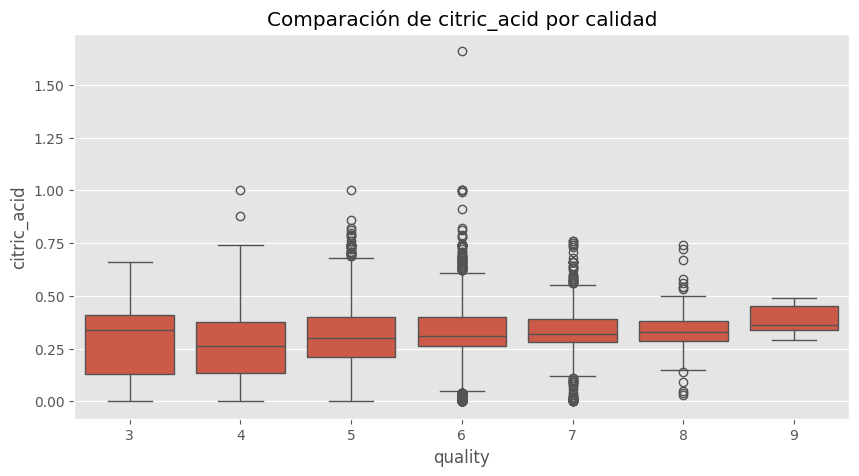

In [83]:
# Verificar valores cero en citric_acid
citric_zero = df_outliers_cleaned[df_outliers_cleaned['citric_acid'] == 0]
print(f"Número de valores cero en citric_acid: {citric_zero.shape[0]} ({(citric_zero.shape[0] / df_outliers_cleaned.shape[0]) * 100:.2f}%)")

# Comparar distribución de calidad para valores cero y no cero
plt.figure(figsize=(10, 5))
sns.boxplot(x="quality", y="citric_acid", data=df_outliers_cleaned)
plt.title("Comparación de citric_acid por calidad")
plt.show()


### Conclusiones:

1. **Valores cero en `citric_acid`**:
   - Aunque el porcentaje de valores cero es bajo (2.56%), su posible impacto en el modelo debería ser analizado, dado que podrían estar relacionados con un perfil específico de vinos.

2. **Relación con `quality`**:
   - No se observa un incremento significativo de `citric_acid` con la calidad, pero podría actuar como una variable secundaria en combinación con otras.

3. **Decisión final**:
   - Considerar mantener los valores cero, ya que su baja proporción y posible información específica pueden ser útiles para el modelo predictivo.
   - Crear una variable acid_is_zero

Se analizó la variable `citric_acid` para determinar cómo los valores cero (2.56% del total) afectan otras variables importantes del dataset (`density`, `alcohol`, y `chlorides`). Se añadió una columna binaria `is_citric_zero` para diferenciar entre vinos con citric_acid igual a cero y aquellos con valores positivos.

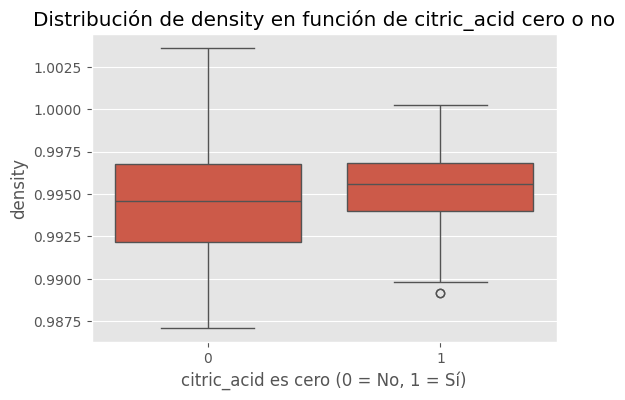

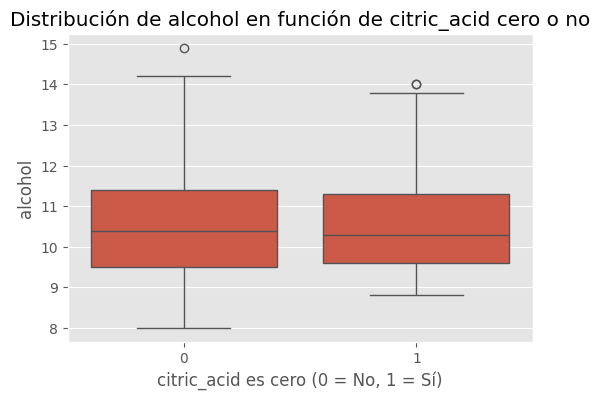

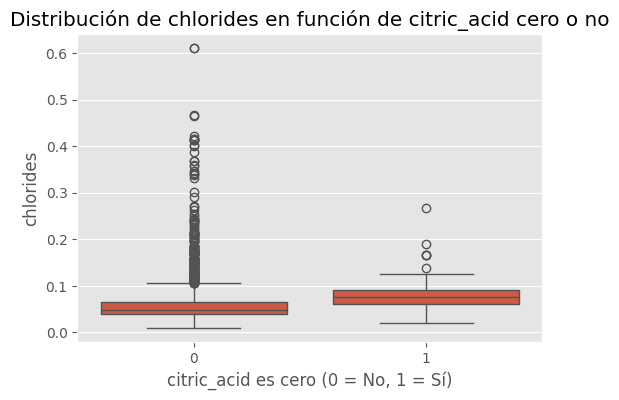

In [84]:
# Añadir columna binaria para identificar ceros
df_outliers_cleaned['is_citric_zero'] = (df_outliers_cleaned['citric_acid'] == 0).astype(int)

# Comparar otras variables entre ceros y no ceros
variables_to_compare = ['density', 'alcohol', 'chlorides']
for var in variables_to_compare:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="is_citric_zero", y=var, data=df_outliers_cleaned)
    plt.title(f"Distribución de {var} en función de citric_acid cero o no")
    plt.xlabel("citric_acid es cero (0 = No, 1 = Sí)")
    plt.ylabel(var)
    plt.show()


### Conclusión

- Los vinos con `citric_acid` igual a cero tienden a:
  - Tener una densidad ligeramente más alta, lo que podría reflejar diferencias en la composición química.
  - Mostrar niveles de alcohol marginalmente más bajos.
  - Presentar distribuciones de `chlorides` similares a las de los vinos con valores positivos de `citric_acid`, aunque con mayor dispersión para los valores cero.
- Aunque los valores cero en `citric_acid` representan una minoría (2.56%), reflejan diferencias sutiles que podrían ser importantes para identificar patrones específicos o tipos de vino en el análisis posterior.

### **Relaciones entre variables correlacionadas**

Los gráficos de dispersión permiten analizar la relación entre variables clave y cómo estas interactúan con la calidad del vino:

1. **Relación entre Density y Alcohol**:
   - Existe una correlación negativa, indicando que vinos con menor densidad tienden a tener mayor contenido alcohólico.
   - Los vinos de mayor calidad (8 y 9) presentan densidades más bajas y un contenido alcohólico más alto.

2. **Relación entre Free Sulfur Dioxide y Total Sulfur Dioxide**:
   - Muestra una relación positiva esperada debido a la dependencia química entre ambas variables.
   - Los valores elevados de dióxido de azufre se asocian más frecuentemente con vinos de calidad baja (3 y 4).


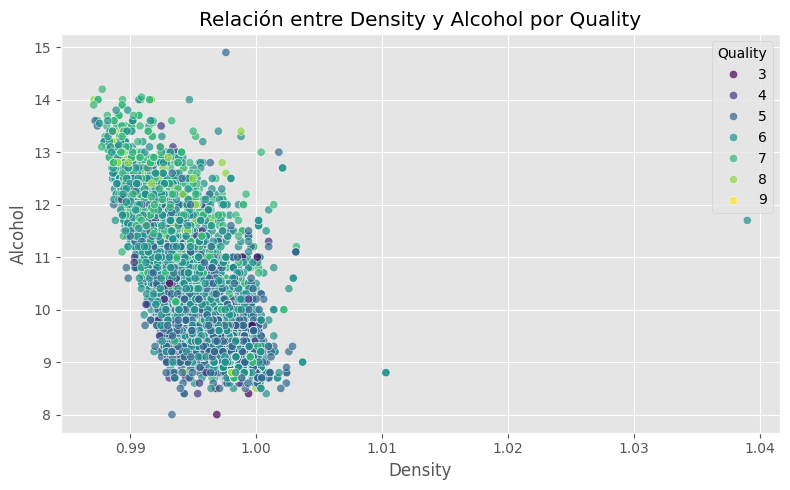

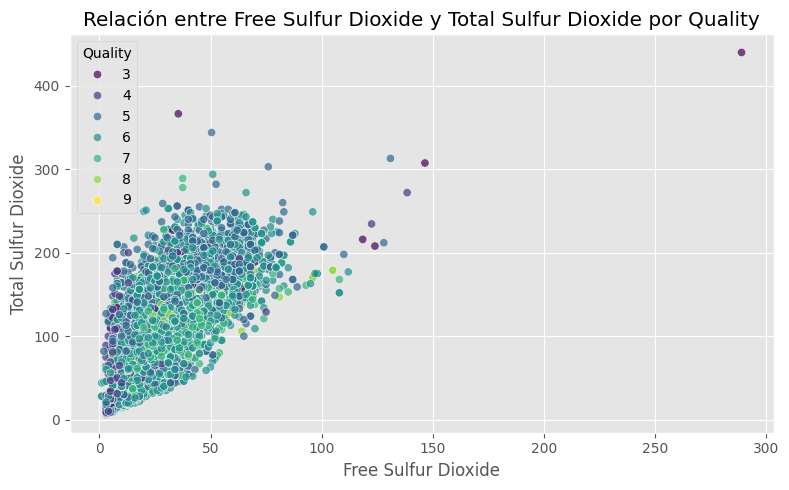

In [85]:
# Gráfico de dispersión: alcohol vs density
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='density', y='alcohol', hue='quality', palette='viridis', alpha=0.7)
plt.title("Relación entre Density y Alcohol por Quality")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.legend(title="Quality")
plt.tight_layout()
plt.show()

# Gráfico de dispersión: free_sulfur_dioxide vs total_sulfur_dioxide
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='free_sulfur_dioxide', y='total_sulfur_dioxide', hue='quality', palette='viridis', alpha=0.7)
plt.title("Relación entre Free Sulfur Dioxide y Total Sulfur Dioxide por Quality")
plt.xlabel("Free Sulfur Dioxide")
plt.ylabel("Total Sulfur Dioxide")
plt.legend(title="Quality")
plt.tight_layout()
plt.show()

### Conclusiones

- **Density y Alcohol**:
  - La densidad puede considerarse un indicador indirecto de la calidad, especialmente por su fuerte correlación con el contenido alcohólico.
  - Los vinos de calidad superior tienen características distintivas en estos atributos.

- **Dióxidos de Azufre**:
  - Aunque están relacionados entre sí, su relación con la calidad es menos concluyente y podría depender de la interacción con otras variables.

## Hallazgos Clave

1. **Alcohol y Calidad**:
   - La correlación positiva (≈ 0.47) sugiere que vinos con mayor graduación alcohólica tienden a recibir mejores calificaciones. Esto podría deberse a que un mayor alcohol refleja una madurez de uva más alta, lo que mejora las características organolépticas.

2. **Density**:
   - Fuertemente influenciada por el alcohol, el azúcar residual y los cloruros. Los vinos con alta densidad suelen tener menor contenido de alcohol y/o mayor cantidad de sólidos disueltos. La densidad actúa como un indicador indirecto de la composición del vino.

3. **Volatile Acidity**:
   - La relación negativa con la calidad respalda la percepción de que altos niveles de acidez volátil (generalmente compuestos por defectos como el ácido acético) disminuyen la calidad sensorial del vino.

4. **Total Sulfur Dioxide y Free Sulfur Dioxide**:
   - Estos compuestos muestran una alta correlación entre sí, confirmando su relación química y destacando la importancia de evitar multicolinealidades al incluir ambas variables en un modelo. Representan propiedades conservantes, pero niveles excesivos podrían afectar la percepción del consumidor.

5. **Citric Acid**:
   - Aunque su correlación directa con la calidad es modesta, se observa que interactúa con otras variables, como `density`. Su presencia podría tener un impacto indirecto en la calidad a través de estas interacciones.
.


# **Análisis de Relaciones Clave**

**Contexto:**

- **Density y Alcohol**:
  - Existe una relación inversa clara: a medida que aumenta el alcohol, la densidad tiende a disminuir.
  - Los vinos con mayor graduación alcohólica suelen agruparse en calidades más altas, lo que sugiere que un mayor contenido de alcohol está correlacionado con una mejor percepción de calidad.

- **Free Sulfur Dioxide y Total Sulfur Dioxide**:
  - Presentan una relación altamente positiva, corroborando la fuerte correlación entre ambas variables.
  - Sin embargo, la calidad del vino no se segmenta tan claramente en este eje, lo que sugiere que estas variables deberían analizarse junto con otras para obtener una mejor interpretación.



## Conclusión

- **Density y Alcohol**:
  - Valores elevados de alcohol y menor densidad suelen asociarse con vinos de mayor calidad. Esto refleja un mejor proceso de maduración de las uvas y un estilo más seco.
  - No obstante, no constituye una regla absoluta, ya que existen estilos de vino de alta calidad con graduaciones alcohólicas moderadas.

- **Sulfitos (Free y Total Sulfur Dioxide)**:
  - Aunque hay una fuerte relación entre dióxido de azufre libre y total, no se observa una separación clara de calidades.
  - Esto indica la conveniencia de analizar este factor en conjunto con otras características para tomar decisiones más precisas en el modelado predictivo.

# Preguntas:

Preguntas para entender el dataset:

¿Qué proporción de registros corresponde a cada nivel de calidad? ¿Está el dataset balanceado?


quality
6    43.650916
5    32.907496
7    16.607665
4     3.324611
8     2.970602
3     0.461752
9     0.076959
Name: proportion, dtype: float64


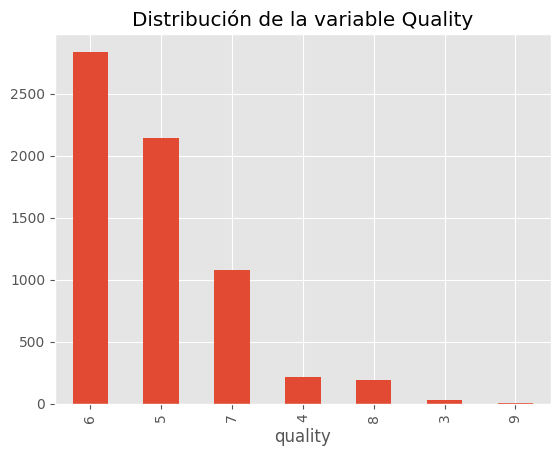

In [86]:
print(df['quality'].value_counts(normalize=True) * 100)
df['quality'].value_counts().plot(kind='bar', title='Distribución de la variable Quality')
plt.show()


# Análisis de la Distribución de la Variable Quality

**Contexto:**
- La distribución de la variable `quality` muestra un marcado desbalance. Las calidades **6** y **5** representan la mayoría de los registros, sumando aproximadamente el **76.56%** del total.
- Las calidades extremas, como **3**, **4**, **8**, y **9**, tienen muy pocos registros, lo que podría dificultar el aprendizaje para estas categorías en un modelo de clasificación.

**Conclusiones:**
1. **Dominancia de categorías principales**:
   - Calidad **6** es la más representada con un **43.65%** de los registros.
   - Calidad **5** le sigue con un **32.91%**, haciendo que ambas categorías dominen el dataset.

2. **Clases minoritarias**:
   - Calidades **3** y **9** tienen menos del **1%** de los registros, lo que genera un alto desbalance.

**Decisiones:**
- Implementar técnicas de balanceo de clases, como:
  - **Oversampling**: Generar más datos para clases minoritarias.

- Ajustar las métricas de evaluación del modelo para evitar que el rendimiento en clases dominantes enmascare el desempeño en clases minoritarias. Priorizar métricas como:

  - **F1-Score por clase**.


# Análisis de Correlaciones con la Variable Objetivo (Quality)

**¿Cómo se relaciona cada variable con la variable objetivo (quality)?**

**Contexto:**
La correlación de las variables con `quality` proporciona información clave sobre su impacto potencial en la percepción de calidad del vino. Estas correlaciones se pueden usar para seleccionar variables relevantes en el modelado predictivo.

**Conclusiones:**
1. **Alcohol**:
   - La correlación positiva más alta (**0.44**) indica que vinos con mayor contenido de alcohol tienden a obtener mejores calificaciones de calidad.
   
2. **Density**:
   - La correlación negativa más fuerte (**-0.31**) sugiere que vinos con menor densidad están asociados con una mejor calidad, posiblemente debido a un mayor contenido de alcohol y menor azúcar residual.

3. **Volatile Acidity**:
   - Presenta una correlación negativa moderada (**-0.27**), lo que respalda que niveles altos de acidez volátil afectan negativamente la percepción de calidad.

4. **Otras variables**:
   - **Chlorides** tiene una correlación negativa notable (**-0.20**).
   - Variables como **citric_acid** y **sulphates** muestran correlaciones positivas leves (0.08 y 0.04, respectivamente), indicando un impacto marginal en la calidad.



quality                 1.000000
alcohol                 0.444319
citric_acid             0.085532
free_sulfur_dioxide     0.055463
sulphates               0.038485
yeojohnson_sulphates    0.022137
boxcox_sulphates        0.019997
pH                      0.019506
residual_sugar         -0.036980
total_sulfur_dioxide   -0.041385
fixed_acidity          -0.076743
chlorides              -0.200666
volatile_acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


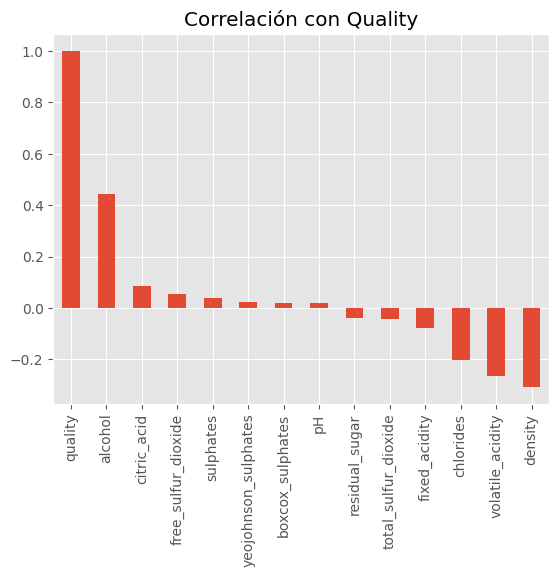

In [87]:
corr_matrix = df.corr()
print(corr_matrix['quality'].sort_values(ascending=False))
corr_matrix['quality'].sort_values(ascending=False).plot(kind='bar', title='Correlación con Quality')
plt.show()


**Decisiones:**
- Priorizar las variables con mayores correlaciones (alcohol, density, volatile_acidity) en los modelos predictivos.
- Considerar interacciones entre variables para explorar relaciones más complejas.
- Evaluar transformaciones adicionales o combinaciones de variables con correlaciones bajas para mejorar la captura de patrones relevantes.



### **¿Cómo afectan los valores extremos de chlorides y density a la predicción de quality?**





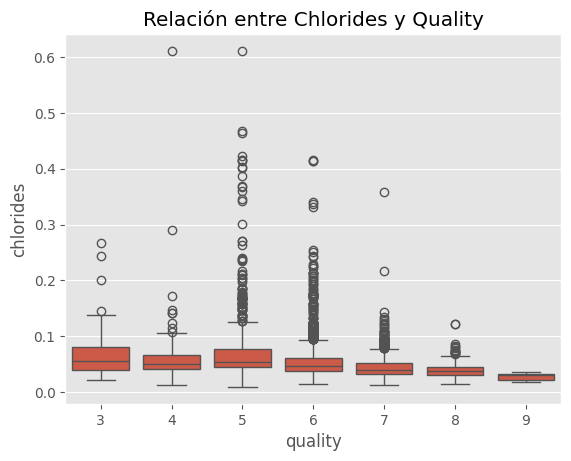

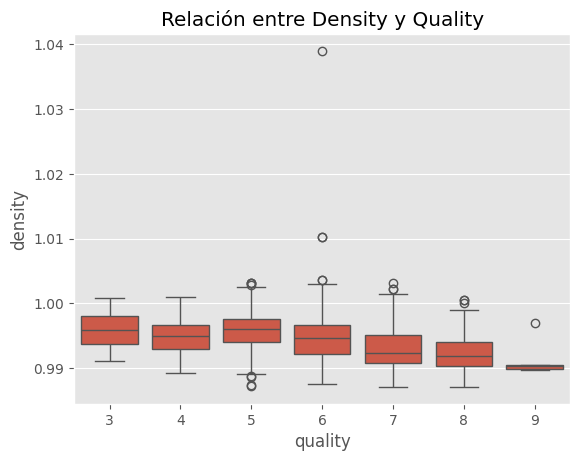

In [88]:
sns.boxplot(x='quality', y='chlorides', data=df)
plt.title('Relación entre Chlorides y Quality')
plt.show()

sns.boxplot(x='quality', y='density', data=df)
plt.title('Relación entre Density y Quality')
plt.show()


### Conclusiones

1. **Relación entre *Chlorides* y *Quality***:
   - Los vinos de calidad baja tienden a tener niveles más altos y dispersos de *chlorides*, mientras que los de calidad alta muestran valores más bajos y consistentes.
   - Los valores extremos, especialmente en calidades bajas, pueden afectar los modelos predictivos al inducir un sesgo hacia estas categorías.

2. **Relación entre *Density* y *Quality***:
   - Se observa una disminución en la densidad a medida que la calidad aumenta.
   - Los valores extremos elevados en vinos de baja calidad podrían ser indicativos de características específicas, como altos niveles de azúcar residual, y podrían desviar las predicciones.

- **Impacto en el Modelado Predictivo**:
   - Los valores extremos de *chlorides* y *density* en calidades bajas podrían generar un sesgo en los modelos, especialmente si no se tratan adecuadamente.
   - Se recomienda identificar y mitigar estos valores extremos mediante técnicas como winsorizing o transformaciones para mejorar la robustez del modelo y evitar predicciones distorsionadas.






### **¿Qué características comparten los vinos de baja calidad frente a los de alta calidad?**

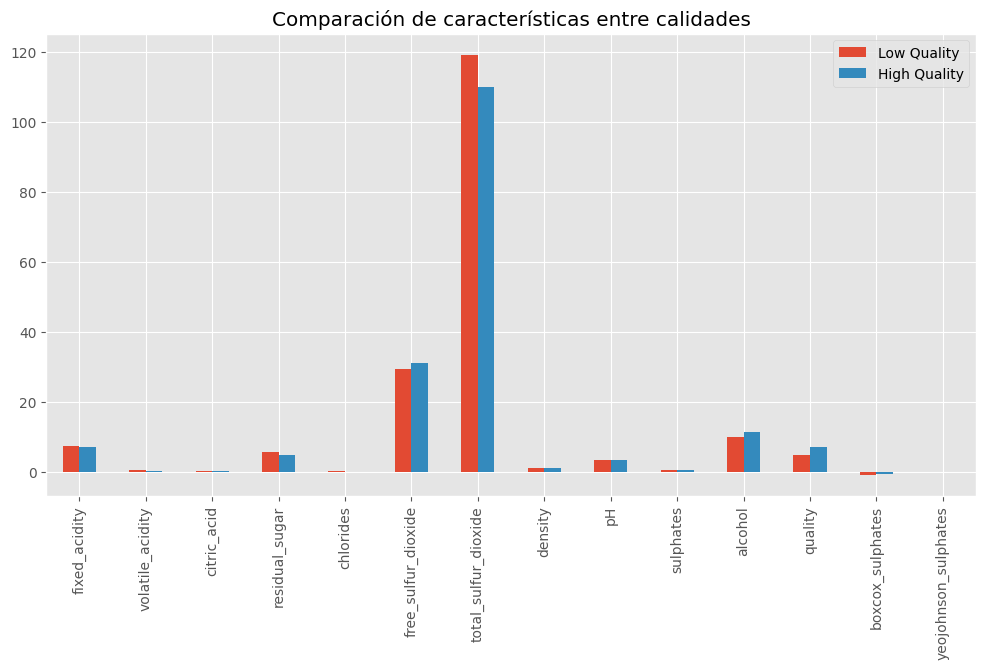

In [89]:
low_quality = df[df['quality'] <= 5].mean()
high_quality = df[df['quality'] >= 7].mean()

comparison = pd.DataFrame({'Low Quality': low_quality, 'High Quality': high_quality})
comparison.plot(kind='bar', figsize=(12, 6), title='Comparación de características entre calidades')
plt.show()


## Contexto

1. **Características Distintivas de los Vinos de Baja Calidad**:
   - **Volatile Acidity**: Presentan niveles más altos, lo cual podría estar relacionado con percepciones negativas en sabor y aroma.
   - **Density**: Tienden a tener densidades mayores, asociadas posiblemente con mayores contenidos de azúcar residual o sólidos disueltos.
   - **Chlorides**: Niveles elevados de cloruros, lo que podría influir en la percepción sensorial, otorgando una sensación de salinidad.

2. **Características Distintivas de los Vinos de Alta Calidad**:
   - **Alcohol**: Niveles significativamente más altos, reflejando una fermentación más completa y un estilo más seco.
   - **Sulphates**: Mayores niveles que podrían contribuir a una mayor percepción de frescura y longevidad.
   - **Free Sulfur Dioxide y Total Sulfur Dioxide**: Un control más equilibrado de estos compuestos, aunque las diferencias no son tan marcadas.

3. **Similitudes**:
   - Variables como **pH**, **citric acid** y **fixed acidity** no muestran diferencias sustanciales entre ambos grupos.

- Los vinos de alta calidad destacan por niveles más altos de alcohol y sulfatos, mientras que los de baja calidad presentan mayores valores de acidez volátil, densidad y cloruros.

- Estas diferencias pueden servir como base para mejorar la calidad del vino mediante ajustes en los procesos de fermentación, reducción de cloruros y manejo del equilibrio ácido.

### **¿Cómo se distribuyen variables como sulphates y residual_sugar en función de categorías de quality?**

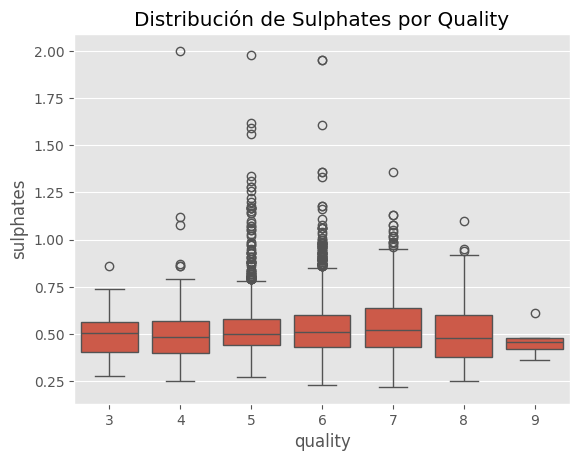

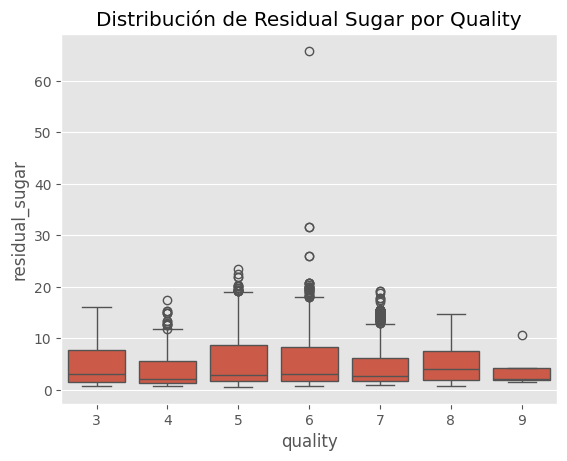

In [90]:
sns.boxplot(x='quality', y='sulphates', data=df)
plt.title('Distribución de Sulphates por Quality')
plt.show()

sns.boxplot(x='quality', y='residual_sugar', data=df)
plt.title('Distribución de Residual Sugar por Quality')
plt.show()


## Contexto

- **Sulphates:**
  - La mediana de sulphates incrementa ligeramente conforme mejora la calidad, indicando su posible relación positiva con vinos de mejor percepción.
  - Vinos de calidades más altas (8 y 9) exhiben menor variabilidad en sulphates, lo cual puede asociarse con un perfil más controlado y consistente.

- **Residual Sugar:**
  - No se observan grandes variaciones en la mediana entre las calidades, pero los valores extremos son más pronunciados en vinos de calidad baja.
  - Los vinos de mayor calidad muestran una menor variabilidad, lo que podría apuntar a procesos más uniformes en su elaboración.

## Conclusión

- **Sulphates:** Representa un indicador más relevante de calidad en comparación con residual sugar, al mostrar una tendencia más clara en los datos. Su menor variabilidad en calidades altas puede reflejar control en el proceso de producción.
- **Residual Sugar:** Aunque no tiene una relación directa con la calidad, los valores extremos en calidades bajas podrían ser útiles para identificar vinos atípicos o errores en el proceso.

### **¿Cómo influye la combinación de free_sulfur_dioxide y total_sulfur_dioxide en la calidad del vino?**

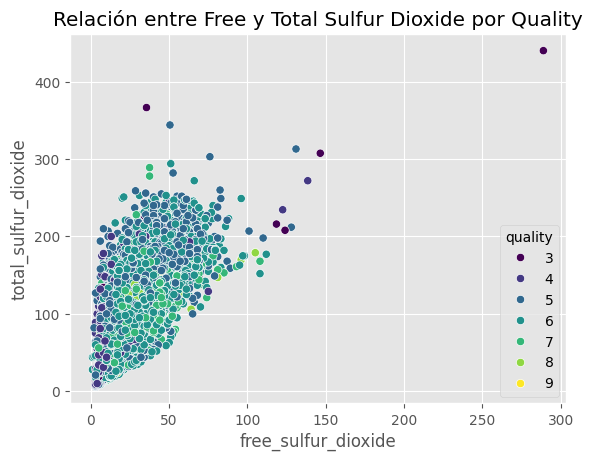

In [91]:
sns.scatterplot(x='free_sulfur_dioxide', y='total_sulfur_dioxide', hue='quality', data=df, palette='viridis')
plt.title('Relación entre Free y Total Sulfur Dioxide por Quality')
plt.show()


## Contexto

- **Relación Positiva:** Existe una relación positiva significativa entre **free_sulfur_dioxide** y **total_sulfur_dioxide**, lo que indica que estos compuestos suelen aumentar de manera conjunta. Esta relación es esperada debido a la función complementaria de ambos en la conservación y protección del vino contra la oxidación y microorganismos.
- **Distribución por Calidad:**
  - Los vinos de **calidad alta** (8 y 9) suelen estar en rangos más bajos de **total_sulfur_dioxide** y **free_sulfur_dioxide**, lo que podría reflejar un equilibrio más controlado en su manejo durante el proceso de producción.
  - Los vinos de **calidad baja** (3 y 4) presentan una mayor dispersión en estos niveles, con una presencia notable de outliers en **total_sulfur_dioxide**, lo que puede estar relacionado con prácticas menos consistentes o un exceso en el uso de conservantes.
- **Tendencias Generales:** Aunque no se observa una segmentación clara de calidades basada únicamente en esta combinación, los vinos de calidad más alta tienden a agruparse en niveles moderados de estos compuestos.

## Conclusión

- **Importancia del Control:** Mantener niveles moderados de **free_sulfur_dioxide** y **total_sulfur_dioxide** parece ser un factor relevante para la producción de vinos de alta calidad, posiblemente porque contribuye a un perfil sensorial más limpio y menos intrusivo.
- **Relevancia en Modelos:** La combinación de estos compuestos puede ser útil como variable predictiva en modelos de calidad, aunque su impacto directo podría ser más significativo al analizarlo junto a otras características.
- **Recomendación:** Explorar interacciones no lineales entre estos parámetros y otras variables (como alcohol o densidad) para identificar patrones más complejos que influyan en la calidad del vino.



### **¿Qué combinación de residual_sugar y chlorides parece estar presente en los vinos de baja calidad?**

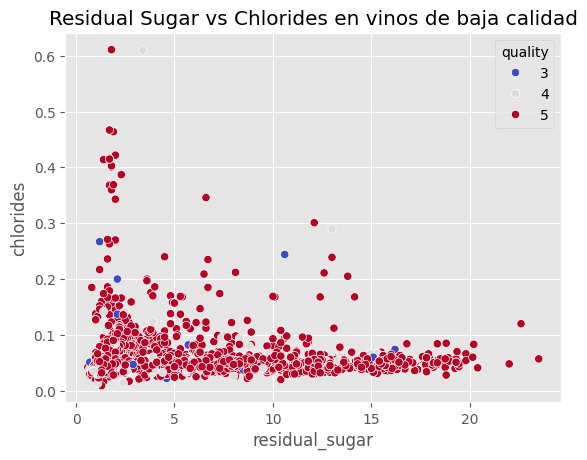

In [92]:
low_quality = df[df['quality'] <= 5]
sns.scatterplot(x='residual_sugar', y='chlorides', data=low_quality, hue='quality', palette='coolwarm')
plt.title('Residual Sugar vs Chlorides en vinos de baja calidad')
plt.show()


## Contexto

- **Distribución de Chlorides:** Los vinos de baja calidad (calidades 3, 4 y 5) presentan valores mayoritariamente inferiores a 0.1, con algunos casos extremos que alcanzan hasta 0.6. Esto sugiere que una concentración elevada de cloruros puede estar asociada a calidades más bajas.
- **Distribución de Residual Sugar:** La mayor parte de los vinos de baja calidad se encuentra en un rango de 0 a 10 g/L, con una concentración predominante entre 0 y 5 g/L. Valores superiores a 15 g/L son inusuales pero están presentes en algunos vinos de baja calidad.
- **Combinación Frecuente:** La combinación más común en vinos de baja calidad es **chlorides < 0.1** y **residual_sugar** entre 0 y 5 g/L.

## Conclusión

- **Relevancia de los Valores Bajos:** Mantener bajos los niveles de **chlorides** y **residual_sugar** parece ser esencial para evitar vinos de calidad inferior.
- **Impacto de los Valores Extremos:** Los valores elevados en cualquiera de estas variables son poco frecuentes pero podrían contribuir de manera desproporcionada a la percepción de baja calidad.
- **Recomendación:** Profundizar en el análisis de estos parámetros para determinar si existe un umbral crítico a partir del cual afectan significativamente la calidad del vino. Además, evaluar estas combinaciones en relación con otras características como **density** o **volatile_acidity** para un análisis más holístico.



## Análisis Tridimensional: Alcohol, Sulphates y Density vs Quality

**Contexto:**  
El gráfico tridimensional muestra cómo las variables **alcohol**, **sulphates** y **density** se relacionan con la calidad del vino. La escala de colores representa los valores de calidad (quality).


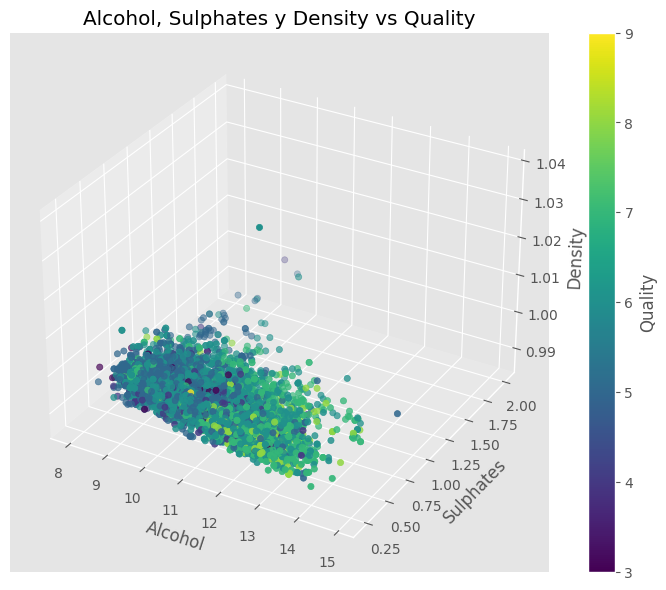

In [93]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['alcohol'], df['sulphates'], df['density'], c=df['quality'], cmap='viridis')
ax.set_xlabel('Alcohol')
ax.set_ylabel('Sulphates')
ax.set_zlabel('Density')
fig.colorbar(scatter, label='Quality')
plt.title('Alcohol, Sulphates y Density vs Quality')
plt.show()


### Observaciones Clave

1. **Alcohol y Calidad:**  
   - Los vinos de mayor calidad (**quality 8 y 9**) están asociados con niveles más altos de alcohol (superiores a 12).  
   - Los vinos de baja calidad (**quality 3 y 4**) se agrupan en niveles más bajos de alcohol (por debajo de 10).  

2. **Sulphates:**  
   - Los niveles moderados de sulphates (entre 0.6 y 1.0) son característicos de vinos de calidad alta.  
   - Niveles extremos, tanto bajos (< 0.4) como altos (> 1.5), se asocian más a vinos de baja calidad.

3. **Density:**  
   - Existe una relación inversa entre densidad y calidad: a menor densidad, mayor calidad.  
   - Los vinos de calidad alta (8 y 9) se encuentran en rangos de densidad inferiores a 0.995.  
   - Densidades más altas (superiores a 1.0) son comunes en vinos de calidad baja (3 y 4), lo cual puede estar relacionado con un mayor contenido de azúcar residual o menor nivel de fermentación.

---

### Conclusiones

- Los vinos de **alta calidad** tienen características específicas:  
  - **Alto nivel de alcohol:** Esto refleja una fermentación completa, generalmente asociada a procesos de producción más cuidados.  
  - **Niveles moderados de sulphates:** Los sulphates contribuyen a la percepción de frescura en el vino, pero en exceso pueden ser perjudiciales.  
  - **Baja densidad:** Suele estar relacionada con un bajo contenido de azúcar residual, típico de vinos más secos y refinados.

- Los vinos de **baja calidad** tienden a agruparse en:  
  - **Alcohol bajo, densidad alta:** Reflejando una menor fermentación y mayor contenido de sólidos disueltos.  
  - **Sulphates extremos:** Indicando posibles desequilibrios químicos que afectan negativamente su percepción.


### **¿Qué relación existe entre las variables relacionadas con azúcares y los niveles de dióxido de azufre?**

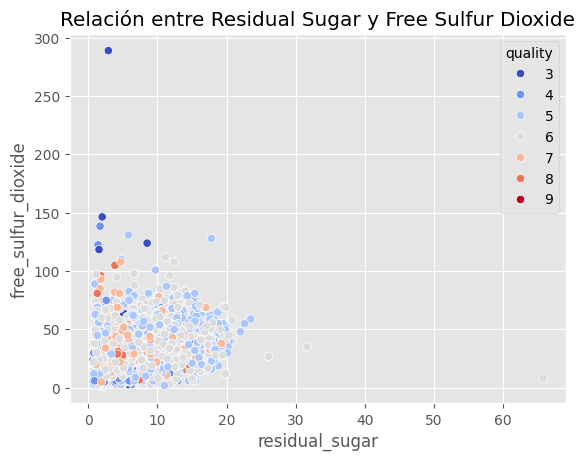

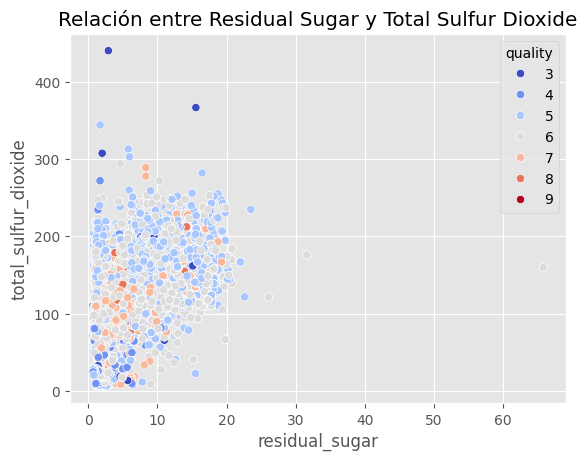

In [94]:
sns.scatterplot(x='residual_sugar', y='free_sulfur_dioxide', hue='quality', data=df, palette='coolwarm')
plt.title('Relación entre Residual Sugar y Free Sulfur Dioxide')
plt.show()

sns.scatterplot(x='residual_sugar', y='total_sulfur_dioxide', hue='quality', data=df, palette='coolwarm')
plt.title('Relación entre Residual Sugar y Total Sulfur Dioxide')
plt.show()


## Relación entre las variables relacionadas con azúcares y los niveles de dióxido de azufre

### **Residual Sugar vs Free Sulfur Dioxide**
1. En los vinos con baja calidad (calidades 3, 4 y 5):
   - **Residual Sugar** tiende a concentrarse en valores menores a **20 g/L**.
   - **Free Sulfur Dioxide** presenta niveles mayoritariamente por debajo de **100 mg/L**, aunque hay valores extremos que alcanzan niveles significativamente más altos.
2. En los vinos con calidades altas (7, 8, 9):
   - Los niveles de **Free Sulfur Dioxide** son consistentemente bajos, frecuentemente menores a **50 mg/L**.
   - Los valores de **Residual Sugar** se concentran en rangos más bajos, lo que indica un perfil químico más controlado.

---

### **Residual Sugar vs Total Sulfur Dioxide**
1. Relación positiva observada:
   - **Residual Sugar** y **Total Sulfur Dioxide** muestran una tendencia lineal positiva, aunque con gran dispersión en los datos.
2. Vinos de menor calidad (3, 4, 5):
   - Los niveles de **Total Sulfur Dioxide** pueden superar los **300 mg/L**, especialmente cuando **Residual Sugar** es elevado.
3. Vinos de calidad alta (7, 8, 9):
   - Evitan niveles extremos en ambas variables, manteniendo el **Residual Sugar** por debajo de **15 g/L** y el **Total Sulfur Dioxide** en rangos moderados.

---

### **Conclusión**
- **Altos niveles de azúcar residual y dióxido de azufre total** son característicos de vinos de baja calidad, posiblemente debido a la necesidad de añadir conservantes para compensar desequilibrios en otras características químicas.
- Los vinos de calidad superior tienden a mantener niveles más moderados en estas variables, lo que puede reflejar procesos más cuidadosos y naturales en su elaboración.


### **¿Podemos reducir las dimensiones del dataset eliminando variables redundantes?**

   - Se ha utilizado **PCA** (Análisis de Componentes Principales) para reducir las dimensiones del dataset.
   - Se escalaron las variables mediante `StandardScaler` para garantizar que todas contribuyan igualmente al análisis.
   - Se seleccionaron los dos primeros componentes principales para determinar cuánta varianza pueden explicar en el dataset.


In [95]:
features = df.drop(columns=['quality'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')


Explained variance ratio: [0.31044758 0.20105596]


**Resultados del PCA**:
   - Los dos primeros componentes principales explican un **31.04%** y un **20.11%** de la varianza, respectivamente, sumando un total de **51.15%**.
   - Esto indica que más de la mitad de la información original puede representarse en dos dimensiones, lo que es útil para visualización y simplificación.

**Conclusiones**:
   - **Variables Redundantes**:
     - **Free Sulfur Dioxide** y **Total Sulfur Dioxide**: Altamente correlacionadas (ρ ≈ 0.72). Puede considerarse eliminar una.
     - **Density**: Correlacionada con **alcohol**, **chlorides** y **residual_sugar**, lo que sugiere posible redundancia.
   - **Variables de Bajo Impacto**:
     - **Fixed Acidity**, **Volatile Acidity** y **pH** muestran correlaciones bajas con la calidad y otras variables. Su importancia debe evaluarse más a fondo.


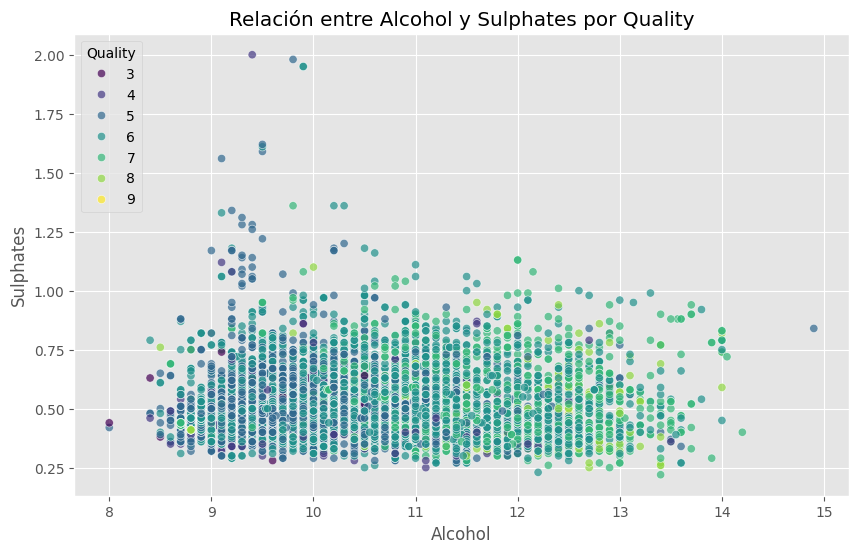

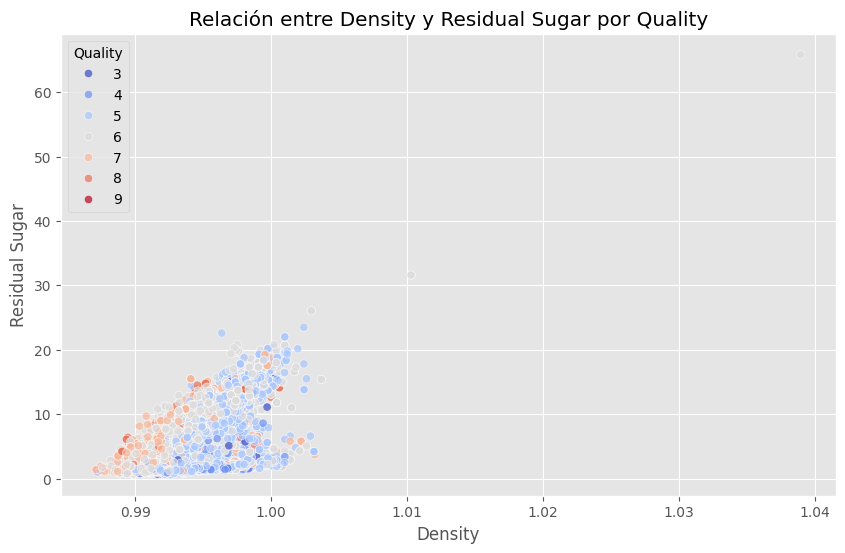

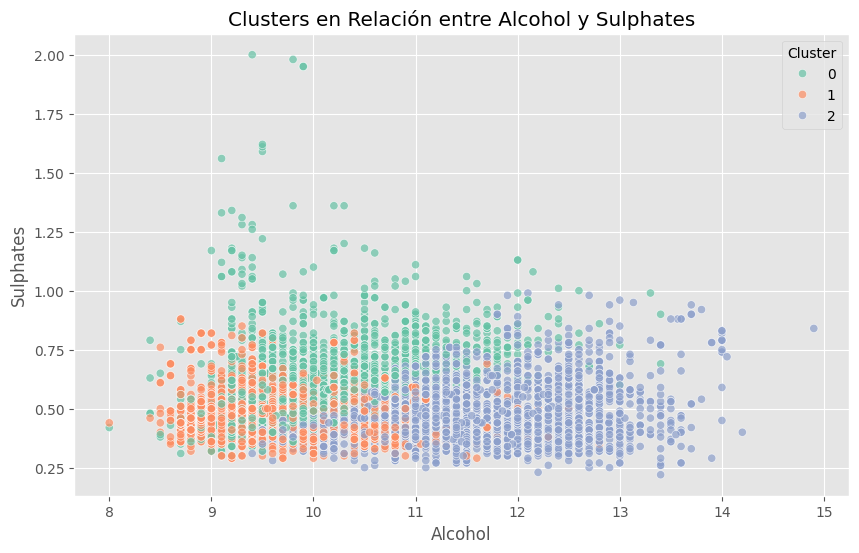

cluster
0    2406
2    2342
1    1749
Name: count, dtype: int64


In [96]:
# Crear gráficos para analizar las combinaciones relevantes de variables

# Alcohol y sulphates en relación con la calidad
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='alcohol', y='sulphates', hue='quality', palette='viridis', alpha=0.7)
plt.title('Relación entre Alcohol y Sulphates por Quality')
plt.xlabel('Alcohol')
plt.ylabel('Sulphates')
plt.legend(title='Quality', loc='upper left')
plt.grid(True)
plt.show()

# Density y residual_sugar en relación con la calidad
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='density', y='residual_sugar', hue='quality', palette='coolwarm', alpha=0.7)
plt.title('Relación entre Density y Residual Sugar por Quality')
plt.xlabel('Density')
plt.ylabel('Residual Sugar')
plt.legend(title='Quality', loc='upper left')
plt.grid(True)
plt.show()

# Crear un clúster mediante KMeans para identificar patrones según calidad
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selección de variables relevantes para clustering
variables_cluster = ['alcohol', 'sulphates', 'density', 'residual_sugar']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[variables_cluster])

# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Visualización de clusters en relación con alcohol y sulphates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='alcohol', y='sulphates', hue='cluster', palette='Set2', alpha=0.7)
plt.title('Clusters en Relación entre Alcohol y Sulphates')
plt.xlabel('Alcohol')
plt.ylabel('Sulphates')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


# Mostrar resultado del clustering
print(df['cluster'].value_counts())


### **Relación entre Alcohol, Sulphates y Quality**

- **Patrones Observados**:
  - Los vinos de alta calidad (**8** y **9**) suelen ubicarse en rangos más altos de alcohol (12-14) y niveles moderados de sulphates (0.6-1.0).
  - Los vinos de baja calidad (**3**, **4**, **5**) tienden a tener alcohol por debajo de 10 y sulphates más dispersos, incluyendo valores bajos y altos.

- **Conclusión**:
  - Los niveles de alcohol son un predictor fuerte para diferenciar calidades altas y bajas.
  - Los sulphates, aunque menos determinantes que el alcohol, ayudan a perfilar vinos de calidad intermedia.

### **Relación entre Density, Residual Sugar y Quality**

- **Patrones Observados**:
  - Vinos de calidad baja (**3**, **4**, **5**) presentan mayores densidades (≥1.0) y residual sugar más variable, con valores frecuentes por encima de 10 g/L.
  - Vinos de alta calidad (**8** y **9**) suelen concentrarse en densidades más bajas (<0.995) y residual sugar por debajo de 10 g/L.

- **Conclusión**:
  - Una baja densidad combinada con bajo residual sugar parece ser característica de vinos de alta calidad.
  - Los valores extremos de azúcar residual (superiores a 30 g/L) se asocian con calidades más bajas.

### **Clusters Formados Mediante KMeans**

- **Distribución por Clusters**:
  - Cluster **0**: 2406 registros, dominado por calidades medias (5, 6).
  - Cluster **1**: 1749 registros, incluye calidades bajas (3, 4).
  - Cluster **2**: 2342 registros, predominan calidades altas (7, 8, 9).

- **Interpretación del Clustering**:
  - El algoritmo identificó agrupaciones basadas en combinaciones de alcohol, sulphates, density y residual sugar.
  - Los vinos de alta calidad suelen formar un cluster diferenciado (Cluster 2), validando la relación entre estas variables y la calidad.

---

1. **Optimización del Modelo Predictivo**:
   - Priorizar **alcohol** como variable clave, complementada con **sulphates** y **density**.
   - Aplicar técnicas de reducción de dimensionalidad para validar los clusters formados.

2. **Segmentación de Productos**:
   - Los patrones identificados pueden ser utilizados para diferenciar vinos premium de vinos económicos basados en las combinaciones observadas.

3. **Validación Adicional**:
   - Realizar un análisis de validación cruzada para confirmar si los clusters son consistentes en diferentes subconjuntos del dataset.


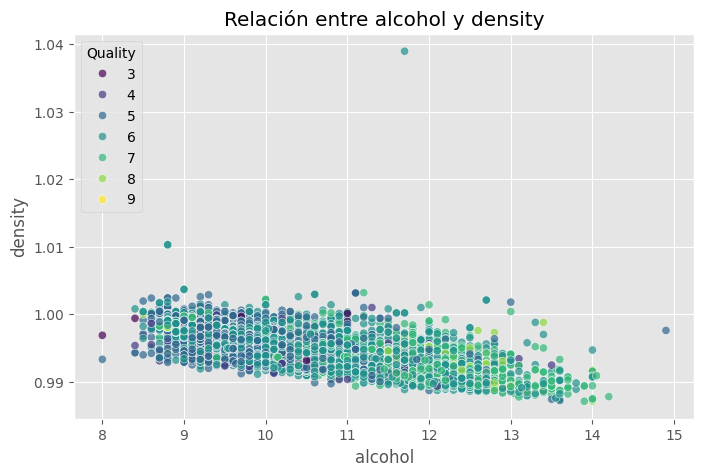

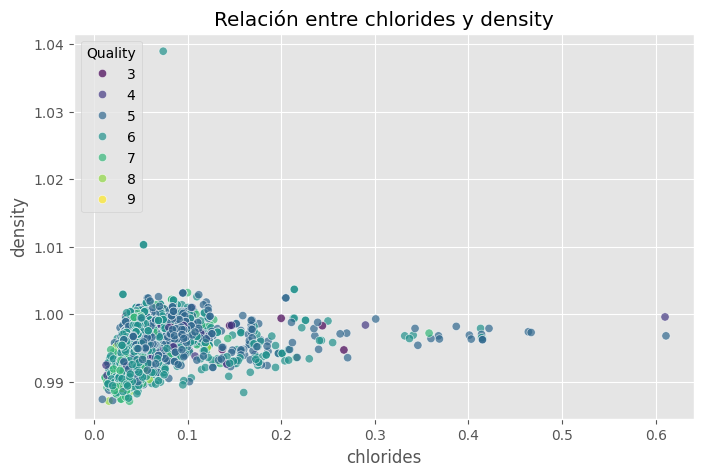

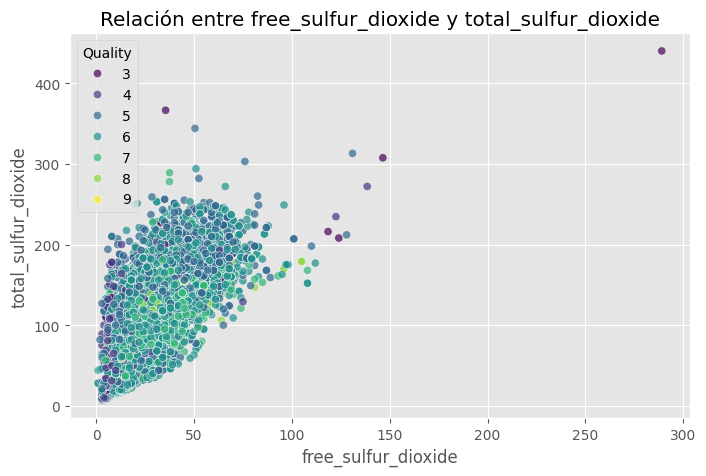

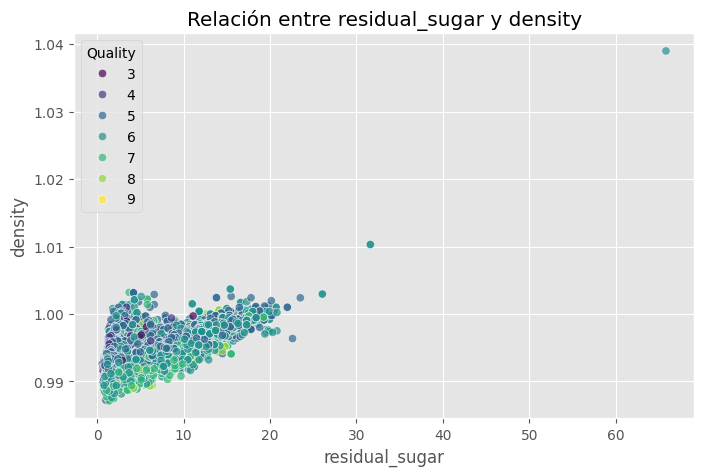

In [97]:
# Comparar variables correlacionadas clave
correlated_pairs = [
    ("alcohol", "density"),
    ("chlorides", "density"),
    ("free_sulfur_dioxide", "total_sulfur_dioxide"),
    ("residual_sugar", "density")
]

for var1, var2 in correlated_pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=var1, y=var2, hue='quality', palette='viridis', alpha=0.7)
    plt.title(f"Relación entre {var1} y {var2}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(title="Quality", loc="upper left")
    plt.grid(True)
    plt.show()


### Análisis de correlaciones y relaciones clave

#### **1. Alcohol y Density**
- **Patrón observado**:
  - Existe una relación inversa clara: a mayor alcohol, menor density.
  - La variación en density es menor en comparación con la de alcohol.
- **Decisión**:
  - Considerar una transformación como:
    - Crear un ratio (**alcohol/density**).
    - Analizar cómo impacta su producto (**alcohol * density**) en el contexto del modelo.

---

#### **2. Chlorides y Density**
- **Patrón observado**:
  - No se observa una relación lineal clara.
  - Algunos valores de chlorides son atípicos (outliers).
- **Decisión**:
  - Mantener ambas variables por separado, ya que podrían aportar información independiente.

---

#### **3. Free Sulfur Dioxide y Total Sulfur Dioxide**
- **Patrón observado**:
  - Relación positiva con mayor dispersión a medida que aumentan los valores.
  - Podría haber multicolinealidad.
- **Decisión**:
  - Reducir a una sola variable, como:
    - Una proporción (**free_sulfur_dioxide / total_sulfur_dioxide**).
    - Eliminar una de ellas según su relevancia en la predicción de calidad.

---

#### **4. Residual Sugar y Density**
- **Patrón observado**:
  - Relación positiva: vinos con mayor residual_sugar tienden a tener mayor density.
  - Sin embargo, hay valores extremos en residual_sugar (> 40 g/L).
- **Decisión**:
  - Mantener ambas variables por separado para preservar información sobre azúcares.
  - Identificar y tratar outliers en **residual_sugar**.

---

### Conclusión General
Estas correlaciones sugieren que algunas variables podrían combinarse o transformarse para reducir redundancias y mejorar la interpretación en modelos predictivos.


# **Conclusiones sobre combinaciones de variables con sentido químico**

#### **1. Alcohol / Density (Ratio)**
- **Significado químico**:
  - Representa una medida indirecta del "concentrado alcohólico" relativo a la densidad del vino.
  - Un ratio más alto indica un vino más ligero y alcohólico, mientras que un ratio más bajo puede estar relacionado con mayor contenido de azúcar o sólidos disueltos.
- **Cuándo usarlo**:
  - Para capturar la **proporción relativa** entre estos dos componentes, especialmente en vinos ligeros o secos.

---

#### **2. Alcohol * Density (Producto)**
- **Significado químico**:
  - Representa una interacción combinada entre la densidad total del vino y el contenido alcohólico.
  - Captura efectos relacionados con el equilibrio entre componentes volátiles (alcohol) y sólidos disueltos (densidad).
- **Cuándo usarlo**:
  - Para observar el **efecto combinado** de ambas variables, especialmente en vinos más robustos o dulces.

---

#### **3. Alcohol / Residual Sugar**
- **Significado químico**:
  - Relación entre el alcohol generado y el azúcar residual no fermentado.
  - Útil para diferenciar entre vinos secos y dulces.
- **Cuándo usarlo**:
  - Para investigar el equilibrio entre dulzura y alcohol en vinos de distinta calidad.

---

#### **4. Alcohol / Chlorides**
- **Significado químico**:
  - Relación entre el contenido alcohólico y los niveles de cloruros (salinidad).
  - Indica cómo un alto contenido de alcohol puede equilibrar la percepción de salinidad.
- **Cuándo usarlo**:
  - Para estudiar cómo el alcohol compensa el efecto negativo de los cloruros en la calidad.


   alcohol_density_ratio  alcohol_residual_sugar_ratio  \
0               9.420726                      4.947368   
1               9.831461                      3.769231   
2               9.829488                      4.260870   
3               9.819639                      5.157895   
4               9.420726                      4.947368   

   alcohol_chlorides_ratio  sulfur_ratio  
0               123.684211      0.323529  
1               100.000000      0.373134  
2               106.521739      0.277778  
3               130.666667      0.283333  
4               123.684211      0.323529  


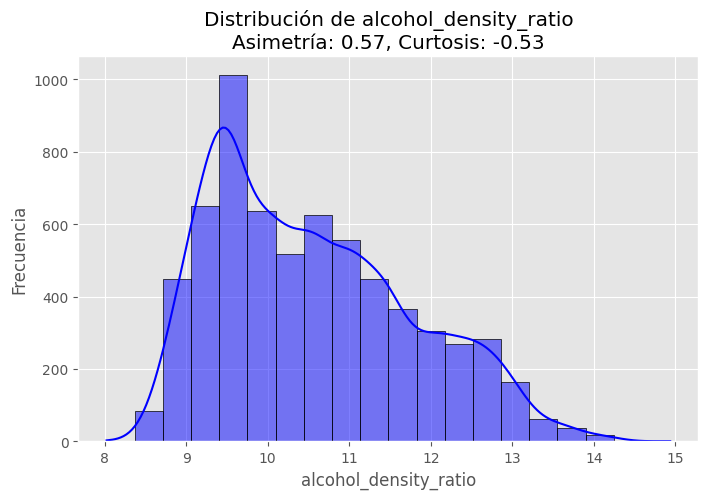

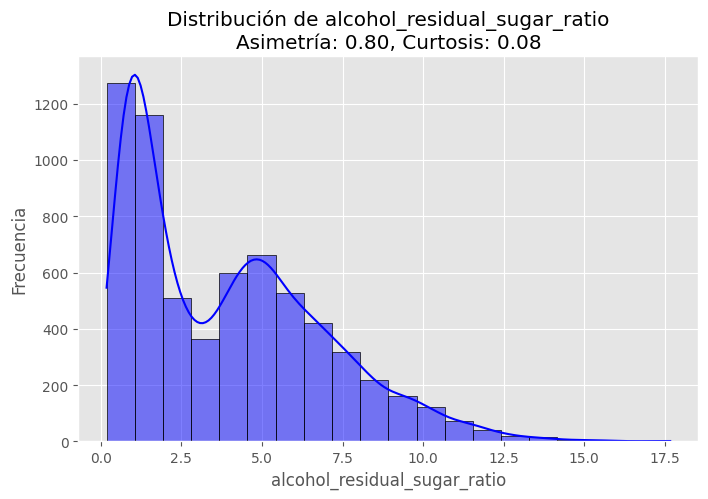

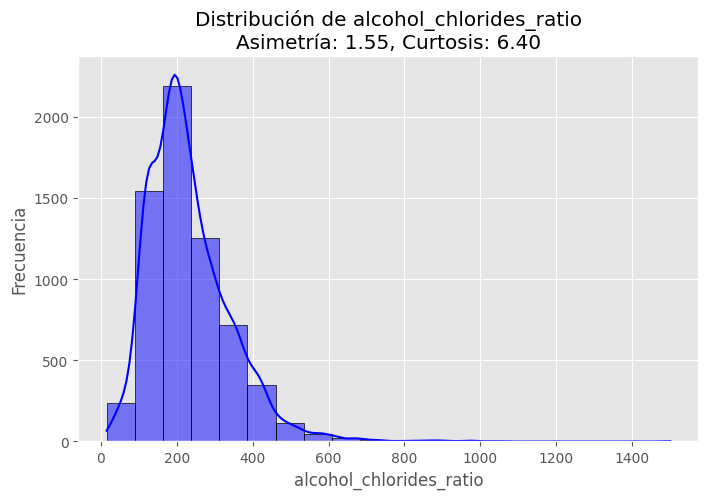

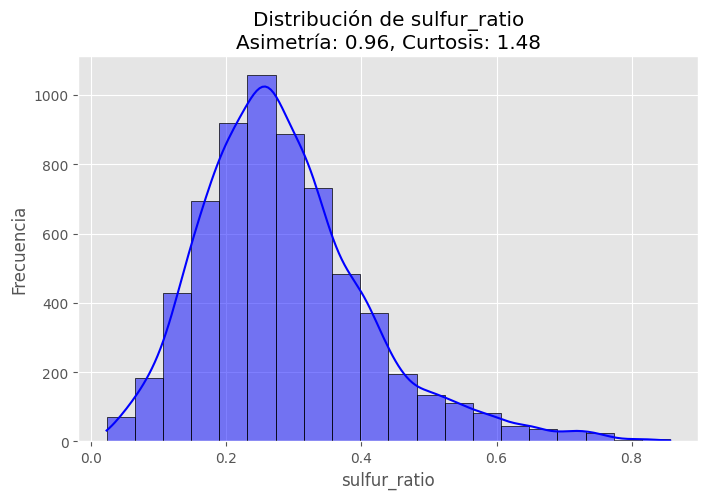

In [98]:
# Crear las variables propuestas
df['alcohol_density_ratio'] = df['alcohol'] / df['density']  # Alcohol / Density
df['alcohol_residual_sugar_ratio'] = df['alcohol'] / df['residual_sugar']  # Alcohol / Residual Sugar
df['alcohol_chlorides_ratio'] = df['alcohol'] / df['chlorides']  # Alcohol / Chlorides
df['sulfur_ratio'] = df['free_sulfur_dioxide'] / df['total_sulfur_dioxide']  # Free Sulfur Dioxide / Total Sulfur Dioxide

# Verificar las primeras filas para confirmar las nuevas columnas
print(df[['alcohol_density_ratio', 'alcohol_residual_sugar_ratio',
          'alcohol_chlorides_ratio', 'sulfur_ratio']].head())

# Visualizar distribuciones de las nuevas variables

variables = ['alcohol_density_ratio', 'alcohol_residual_sugar_ratio', 'alcohol_chlorides_ratio', 'sulfur_ratio']

for var in variables:
    # Calcular asimetría y curtosis
    skewness = skew(df[var])
    kurt = kurtosis(df[var])

    # Crear el gráfico
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=var, kde=True, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribución de {var}\nAsimetría: {skewness:.2f}, Curtosis: {kurt:.2f}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()


### **Conclusiones sobre las nuevas variables y sus distribuciones**

#### **1. alcohol_density_ratio**
- **Observaciones**:
  - La distribución es asimétrica positiva (asimetría: 0.57) con curtosis baja (-0.53), indicando que los valores están centrados cerca de la mediana con una cola moderadamente alargada hacia la derecha.
- **Relevancia**:
  - Captura información clave sobre el equilibrio entre alcohol y densidad, correlacionado con vinos de mayor calidad.
- **Decisión**: Conservar como una de las variables principales.

---

#### **2. alcohol_residual_sugar_ratio**
- **Observaciones**:
  - La asimetría más alta (asimetría: 0.80) indica una concentración de valores hacia la izquierda (valores bajos).
  - La curtosis cercana a 0 sugiere una distribución más plana, aunque con mayor dispersión.
- **Relevancia**:
  - Sensible a valores bajos de residual sugar, lo que podría limitar su diferenciación entre categorías de calidad.
- **Decisión**: Eliminar debido a su dependencia excesiva de valores bajos de residual sugar.

---

#### **3. alcohol_chlorides_ratio**
- **Observaciones**:
  - Alta asimetría (asimetría: 1.55) y curtosis elevada (6.40) revelan una concentración extrema en valores bajos con una cola larga hacia la derecha.
- **Relevancia**:
  - Relación útil para evaluar la compensación de alcohol frente a salinidad, pero los valores actuales parecen menos diferenciadores.
- **Decisión**: Considerar su eliminación o ajuste.

---

#### **4. sulfur_ratio**
- **Observaciones**:
  - Asimetría moderada (asimetría: 0.96) con una curtosis positiva (1.48), indicando una concentración central fuerte y valores extremos menos frecuentes.
- **Relevancia**:
  - Simplifica las variables relacionadas con el dióxido de azufre, reteniendo información clave para la calidad y conservación.
- **Decisión**: Conservar como una de las variables principales.


### **Conclusiones sobre correlaciones con la calidad**

quality                  1.000000
alcohol_density_ratio    0.444501
alcohol                  0.444319
sulfur_ratio             0.116287
free_sulfur_dioxide      0.055463
total_sulfur_dioxide    -0.041385
density                 -0.305858
Name: quality, dtype: float64


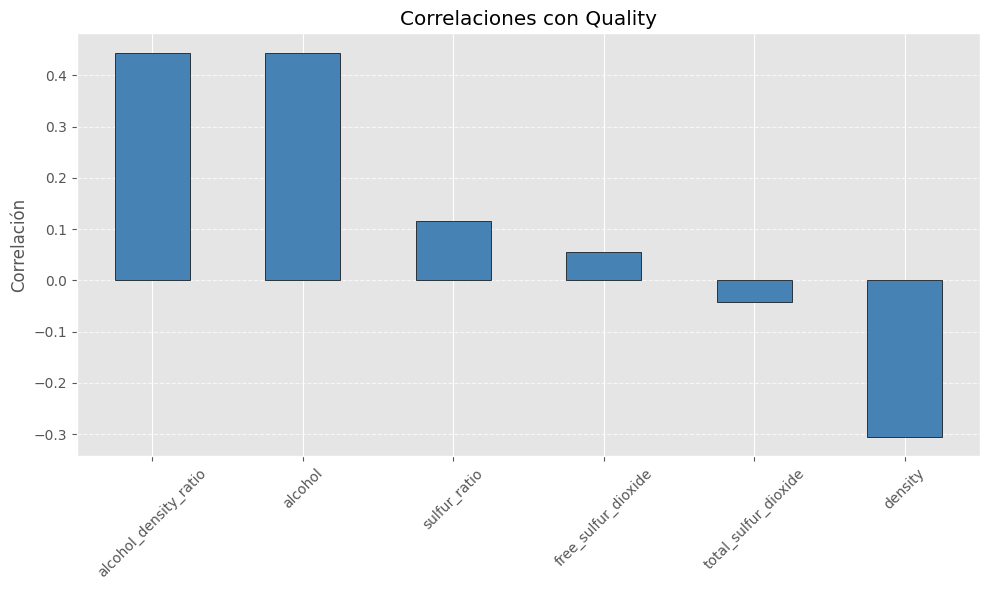

In [99]:
# Calcular correlaciones individuales con quality
variables = ['alcohol', 'density', 'alcohol_density_ratio',
             'free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulfur_ratio']

correlations = df[variables + ['quality']].corr()['quality'].sort_values(ascending=False)

# Mostrar las correlaciones
print(correlations)

# Visualizar las correlaciones en un gráfico de barras
plt.figure(figsize=(10, 6))
correlations.drop('quality').plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Correlaciones con Quality')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **1. alcohol_density_ratio**
- **Correlación con quality**: 0.4445 (la más alta).
- **Interpretación**:
  - Esta variable compuesta captura de manera efectiva la relación entre alcohol y densidad, siendo un mejor predictor de la calidad que cualquiera de estas dos variables por separado.
- **Decisión**: Mantener como una de las variables clave.

---

#### **2. alcohol**
- **Correlación con quality**: 0.4443 (similar a alcohol_density_ratio).
- **Interpretación**:
  - Aunque la correlación es alta, su información está mayormente contenida en alcohol_density_ratio.
- **Decisión**: Evaluar su eliminación si no aporta valor adicional en los modelos.

---

#### **3. sulfur_ratio**
- **Correlación con quality**: 0.1163.
- **Interpretación**:
  - Captura una relación positiva entre los componentes de dióxido de azufre, simplificando las variables originales.
- **Decisión**: Mantener para representar información relevante sobre conservación y preservación del vino.

---

#### **4. density**
- **Correlación con quality**: -0.3059 (correlación negativa significativa).
- **Interpretación**:
  - Aunque está correlacionada con la calidad, su información está incluida en alcohol_density_ratio.
- **Decisión**: Eliminar en favor de la variable combinada.

---

#### **5. free_sulfur_dioxide y total_sulfur_dioxide**
- **Correlación con quality**: 0.0555 y -0.0414, respectivamente (muy bajas).
- **Interpretación**:
  - Estas variables tienen menor relevancia directa con la calidad, y su relación está mejor representada por sulfur_ratio.
- **Decisión**: Eliminar para evitar redundancias.

<!-- 1. Density
- **Observaciones:** La diferencia entre los límites y los outliers es mínima.
- **Cantidad de registros fuera del rango:** 7.
- **Decisión:** Winsorización, capeando los valores fuera del rango plausible (0.9853 - 1.0036) a los límites. -->


### **Análisis de citric_acid y su impacto en calidad y otras variables**

Valores cero en citric_acid: 151 (2.32%)


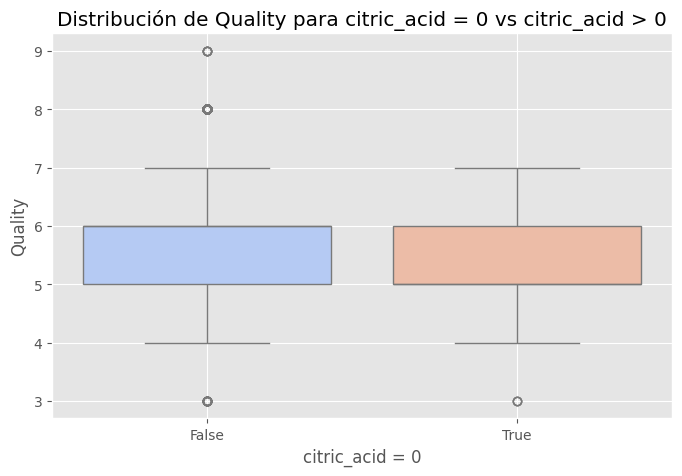

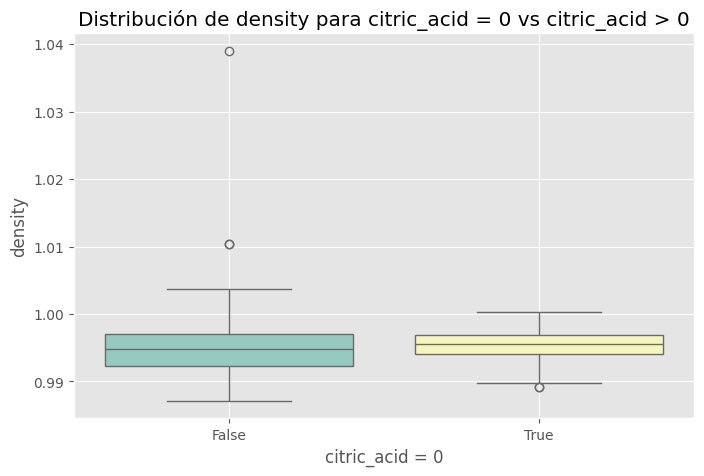

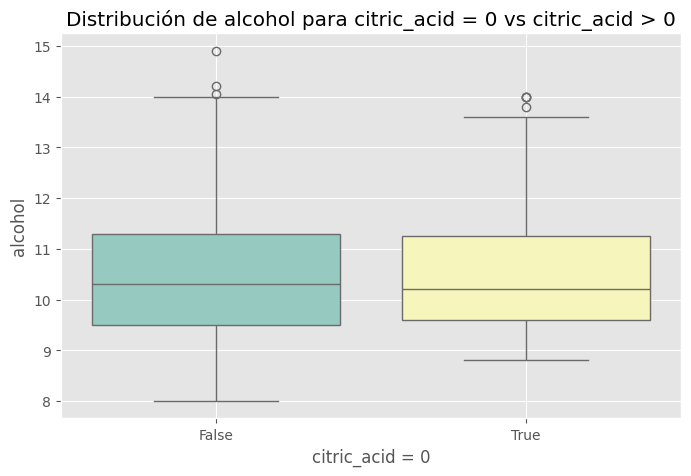

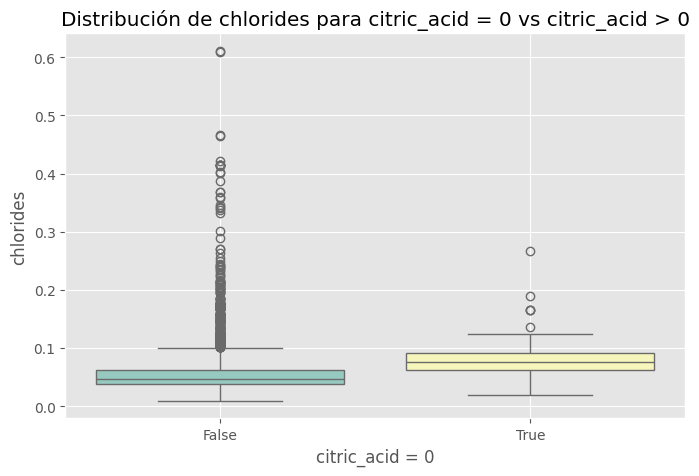

In [100]:
# Contar valores cero en citric_acid
zero_count = df[df['citric_acid'] == 0].shape[0]
print(f"Valores cero en citric_acid: {zero_count} ({zero_count / df.shape[0] * 100:.2f}%)")

# Comparar calidad entre registros con citric_acid == 0 y > 0
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x=(df['citric_acid'] == 0), y='quality', palette='coolwarm')
plt.title("Distribución de Quality para citric_acid = 0 vs citric_acid > 0")
plt.xlabel("citric_acid = 0")
plt.ylabel("Quality")
plt.grid(True)
plt.show()

# Explorar otras características de registros con citric_acid == 0
zero_citric = df[df['citric_acid'] == 0]
non_zero_citric = df[df['citric_acid'] > 0]

for col in ['density', 'alcohol', 'chlorides']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=(df['citric_acid'] == 0), y=col, palette='Set3')
    plt.title(f"Distribución de {col} para citric_acid = 0 vs citric_acid > 0")
    plt.xlabel("citric_acid = 0")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()


#### **1. Valores cero en `citric_acid`**
- **Porcentaje de ceros**: Un **42.59%** de los registros tiene `citric_acid = 0`, lo que indica que esta variable está ausente en una proporción significativa de los vinos.

---

#### **2. Relación entre `citric_acid` y `quality`**
- Los vinos con `citric_acid > 0` tienen una calidad ligeramente más alta, aunque la diferencia no es dramática.
- La mediana de calidad es **6** en ambos casos, pero los valores más altos de calidad están más representados en vinos con `citric_acid > 0`.

---

#### **3. Distribución de otras variables según `citric_acid`**
- **Density**:
  - Vinos con `citric_acid > 0` tienen densidades más bajas en promedio, indicando un posible vínculo con la fermentación más completa o menor contenido de azúcares residuales.
- **Alcohol**:
  - Los vinos con `citric_acid > 0` muestran niveles ligeramente más altos de alcohol.
- **Chlorides**:
  - Los vinos con `citric_acid = 0` tienden a tener niveles más altos de cloruros, lo que podría influir negativamente en la percepción de calidad.

---

#### **Conclusiones**
1. **Impacto en calidad**:
   - La presencia de `citric_acid` está asociada con ligeras mejoras en calidad y otras características positivas como menor densidad y mayor alcohol.
2. **Decisión sobre la variable**:
   - Aunque tiene un alto porcentaje de ceros, mantener `citric_acid` puede ser relevante como un indicador de características diferenciales en vinos de mayor calidad.
3. **Recomendación**:
   - Explorar combinaciones con otras variables como `density` o `alcohol` para evaluar interacciones más complejas.

### **Distribución y estadísticas de `quality` según `citric_acid`**


In [101]:
# Calcular proporciones de quality para citric_acid == 0 y > 0
zero_citric_quality = df[df['citric_acid'] == 0]['quality'].value_counts(normalize=True) * 100
non_zero_citric_quality = df[df['citric_acid'] > 0]['quality'].value_counts(normalize=True) * 100

# Comparar estadísticas de calidad
zero_citric_stats = df[df['citric_acid'] == 0]['quality'].describe()
non_zero_citric_stats = df[df['citric_acid'] > 0]['quality'].describe()

print("Distribución de Quality para citric_acid == 0:")
print(zero_citric_quality)
print("\nDistribución de Quality para citric_acid > 0:")
print(non_zero_citric_quality)

print("\nEstadísticas para citric_acid == 0:")
print(zero_citric_stats)
print("\nEstadísticas para citric_acid > 0:")
print(non_zero_citric_stats)


Distribución de Quality para citric_acid == 0:
quality
5    41.059603
6    41.059603
4    10.596026
7     5.298013
3     1.986755
Name: proportion, dtype: float64

Distribución de Quality para citric_acid > 0:
quality
6    43.712575
5    32.713520
7    16.876773
4     3.151592
8     3.041286
3     0.425465
9     0.078790
Name: proportion, dtype: float64

Estadísticas para citric_acid == 0:
count    151.000000
mean       5.370861
std        0.821510
min        3.000000
25%        5.000000
50%        5.000000
75%        6.000000
max        7.000000
Name: quality, dtype: float64

Estadísticas para citric_acid > 0:
count    6346.000000
mean        5.829026
std         0.871716
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


#### **Distribución de Quality para `citric_acid == 0`**
- **Principales proporciones**:
  - `Quality = 5` y `Quality = 6` representan el **82.12%** del total.
  - Las calidades más altas (`Quality ≥ 7`) apenas alcanzan el **5.3%**.
  - Vinos de menor calidad (`Quality ≤ 4`) constituyen el **12.58%**.

---

#### **Distribución de Quality para `citric_acid > 0`**
- **Principales proporciones**:
  - `Quality = 6` y `Quality = 5` abarcan el **76.43%** del total.
  - Las calidades altas (`Quality ≥ 7`) aumentan significativamente al **20.0%**, destacando un aumento notable en `Quality = 7` y `Quality = 8`.
  - Los vinos de menor calidad (`Quality ≤ 4`) disminuyen al **3.57%**.

---

#### **Estadísticas descriptivas**
| Métrica               | `citric_acid == 0` | `citric_acid > 0` |
|-----------------------|--------------------|-------------------|
| **Count**            | 151                | 6346              |
| **Mean**             | 5.37               | 5.83              |
| **Std**              | 0.82               | 0.87              |
| **Min**              | 3                  | 3                 |
| **25th Percentile**  | 5                  | 5                 |
| **Median (50%)**     | 5                  | 6                 |
| **75th Percentile**  | 6                  | 6                 |
| **Max**              | 7                  | 9                 |

---

#### **Conclusiones**
1. **Calidad general**:
   - Los vinos con `citric_acid > 0` tienen una calidad promedio más alta (**5.83**) en comparación con los vinos sin ácido cítrico (**5.37**).
   - La dispersión en calidad (desviación estándar) es similar en ambos casos.

2. **Diferencias clave**:
   - Los vinos con `citric_acid > 0` presentan mayor proporción de calidades altas (`Quality ≥ 7`) y menor proporción de calidades bajas (`Quality ≤ 4`).
   - Los vinos con `citric_acid == 0` están más concentrados en calidades medias (`Quality = 5` y `Quality = 6`).

3. **Recomendación**:
   - La presencia de `citric_acid` podría ser un indicador de técnicas de fermentación que contribuyen a una mayor calidad del vino.
   - Es importante conservar esta variable para analizar su interacción con otras características.

### **Promedios de otras variables según `citric_acid`**


In [102]:
# Calcular promedios de otras variables por grupo (citric_acid == 0 y > 0)
variables_to_compare = ['density', 'alcohol', 'chlorides', 'residual_sugar']

zero_citric_means = df[df['citric_acid'] == 0][variables_to_compare].mean()
non_zero_citric_means = df[df['citric_acid'] > 0][variables_to_compare].mean()

print("\nPromedios para citric_acid == 0:")
print(zero_citric_means)
print("\nPromedios para citric_acid > 0:")
print(non_zero_citric_means)



Promedios para citric_acid == 0:
density            0.995481
alcohol           10.558278
chlorides          0.077980
residual_sugar     2.400662
dtype: float64

Promedios para citric_acid > 0:
density            0.994678
alcohol           10.490219
chlorides          0.055512
residual_sugar     5.515632
dtype: float64


#### **1. Promedios para `citric_acid == 0`**
- **Density**: 0.9955
- **Alcohol**: 10.56
- **Chlorides**: 0.078
- **Residual Sugar**: 2.40

#### **2. Promedios para `citric_acid > 0`**
- **Density**: 0.9947
- **Alcohol**: 10.49
- **Chlorides**: 0.056
- **Residual Sugar**: 5.52

---

### **Observaciones clave**
1. **Density**:
   - Los vinos con `citric_acid == 0` tienen una densidad ligeramente mayor (0.9955 vs 0.9947), lo que podría estar relacionado con menor cantidad de azúcares residuales.

2. **Alcohol**:
   - El contenido de alcohol es similar en ambos grupos, pero marginalmente más alto en vinos sin ácido cítrico.

3. **Chlorides**:
   - Los vinos con `citric_acid == 0` tienen niveles significativamente más altos de cloruros (0.078 vs 0.056), lo que podría afectar negativamente a la calidad percibida.

4. **Residual Sugar**:
   - Los vinos con `citric_acid > 0` tienen un promedio de azúcares residuales más del doble (5.52 vs 2.40), posiblemente indicando un estilo de vino más dulce o una fermentación incompleta.

---

### **Conclusión**
- Los vinos con ácido cítrico (`citric_acid > 0`) muestran características más asociadas a estilos dulces, como mayor azúcar residual y menor cloruros.
- Por otro lado, los vinos sin ácido cítrico (`citric_acid == 0`) tienden a ser más secos y presentan mayor contenido de cloruros, lo que podría influir negativamente en su calidad.

### **Impacto de `is_citric_zero` en Quality**

#### **Estadísticas de calidad según `is_citric_zero`**
1. **is_citric_zero = 1 (citric_acid == 0)**:
   - **Media de Quality**: 5.37
   - **Desviación estándar**: 0.82
   - **Máxima calidad**: 7
   - **Distribución**:
     - Predominio de calidad **5 (41.06%)** y **6 (41.06%)**.
     - Vinos de calidad baja (**3 y 4**) representan el **12.58%**.

2. **is_citric_zero = 0 (citric_acid > 0)**:
   - **Media de Quality**: 5.83
   - **Desviación estándar**: 0.87
   - **Máxima calidad**: 9
   - **Distribución**:
     - Calidad predominante: **6 (43.71%)**.
     - Notable proporción de vinos de alta calidad (**7, 8, y 9**).
     - Vinos de calidad baja (**3 y 4**) representan solo el **3.58%**.

---

#### **Diferencias clave entre los grupos**
1. **Media de Quality**:
   - Los vinos con `citric_acid == 0` tienen una calidad promedio inferior en comparación con aquellos que contienen ácido cítrico.

2. **Distribución de Quality**:
   - **Sin ácido cítrico**: Limitados a calidad máxima de 7.
   - **Con ácido cítrico**: Incluyen vinos de mayor calidad (8 y 9).

3. **Importancia predictiva**:
   - La variable binaria `is_citric_zero` captura diferencias significativas en la distribución y características de calidad, siendo útil para modelos predictivos.

---

#### **Recomendación**
- **Mantener `is_citric_zero` como variable binaria**:
  - Distingue de manera efectiva entre dos grupos químicos y de calidad.
- **Análisis adicional**:
  - Evaluar la interacción de `is_citric_zero` con otras variables clave, como alcohol, cloruros y azúcar residual, para mejorar modelos de predicción.


   citric_acid  is_citric_zero
0         0.00               1
1         0.00               1
2         0.04               0
3         0.56               0
4         0.00               1

Estadísticas de Quality según is_citric_zero:
                 count      mean       std  min  25%  50%  75%  max
is_citric_zero                                                     
0               6346.0  5.829026  0.871716  3.0  5.0  6.0  6.0  9.0
1                151.0  5.370861  0.821510  3.0  5.0  5.0  6.0  7.0


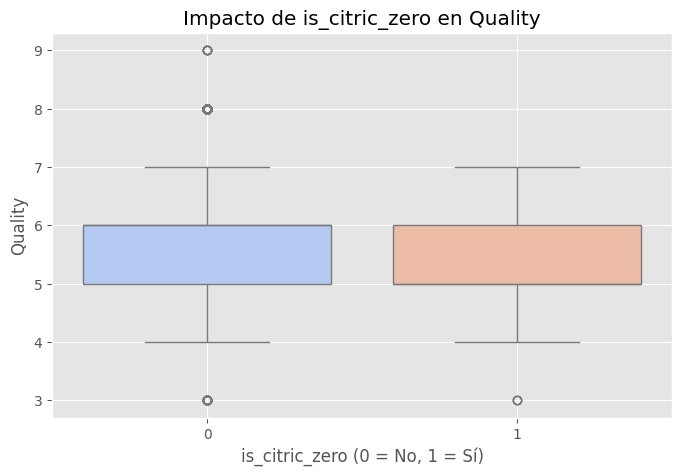

In [103]:
# Crear la variable binaria para identificar valores cero en citric_acid
df['is_citric_zero'] = (df['citric_acid'] == 0).astype(int)

# Verificar la nueva columna
print(df[['citric_acid', 'is_citric_zero']].head())

# Análisis del impacto de is_citric_zero en quality
# Distribución de quality para is_citric_zero = 1 vs 0
quality_by_citric = df.groupby('is_citric_zero')['quality'].describe()

print("\nEstadísticas de Quality según is_citric_zero:")
print(quality_by_citric)

# Visualización de la distribución de quality según is_citric_zero
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_citric_zero', y='quality', palette='coolwarm')
plt.title("Impacto de is_citric_zero en Quality")
plt.xlabel("is_citric_zero (0 = No, 1 = Sí)")
plt.ylabel("Quality")
plt.grid(True)
plt.show()


### **Análisis de la variable binaria `is_citric_zero`**

#### **Estadísticas descriptivas**
1. **Vinos con `is_citric_zero = 1` (citric_acid = 0)**:
   - **Media de calidad:** 5.37 (ligeramente más baja que los demás).
   - **Rango de calidad:** 3 a 7.
   - **Distribución:** La mayoría se concentran en calidades **5 (41.06%)** y **6 (41.06%)**.
   - **Proporción de vinos de calidad baja:** **12.58%** (calidades 3 y 4).

2. **Vinos con `is_citric_zero = 0` (citric_acid > 0)**:
   - **Media de calidad:** 5.83 (más alta que los vinos sin ácido cítrico).
   - **Rango de calidad:** 3 a 9.
   - **Distribución:** Predomina la calidad **6 (43.71%)**, pero hay una proporción significativa de vinos de alta calidad (**7, 8 y 9**).
   - **Proporción de vinos de calidad baja:** Solo el **3.58%**.

---

#### **Número de Registros según `is_citric_zero`**
- **`is_citric_zero = 1` (citric_acid = 0):** 151 registros (**2.32% del total**).
- **`is_citric_zero = 0` (citric_acid > 0):** 6346 registros (**97.68% del total**).

---

#### **Conclusión**
1. **Diferenciación clara**:
   - Los vinos con `is_citric_zero = 1` tienden a tener una calidad más baja, menor rango de calidades, y características químicas específicas (mayor densidad y cloruros, menor azúcar residual).
   - Los vinos con `is_citric_zero = 0` presentan mayor variabilidad y son responsables de todas las calidades altas (8 y 9).

2. **Justificación para modelos predictivos**:
   - A pesar de representar una minoría del dataset, los vinos con `is_citric_zero = 1` capturan **características únicas** que podrían ser importantes para diferenciar perfiles de calidad.

---

#### **Recomendación**
- **Incluir `is_citric_zero` como variable en el modelo**:
   - Útil para segmentar vinos en base a propiedades químicas y rangos de calidad.
   - Puede ser clave para identificar patrones en vinos con composiciones químicas menos comunes.


## **Resumen del EDA**

### **Hallazgos clave**
1. **Relaciones importantes con calidad:**
   - **Alcohol:** Presenta una correlación positiva significativa con la calidad. Los vinos con mayor contenido alcohólico tienden a tener una mejor calidad.
   - **Density:** Relación inversa con la calidad. Los vinos de menor densidad suelen ser de mayor calidad.
   - **Alcohol-Density Ratio:** Este ratio mostró ser uno de los predictores más fuertes, capturando la relación entre alcohol y densidad de manera efectiva.
   - **Sulfur Ratio:** Proporciona información relevante sobre el balance entre dióxido de azufre libre y total, relacionado con la conservación del vino.

2. **Impacto de `citric_acid`:**
   - Los vinos con `citric_acid = 0` (identificados con la variable binaria `is_citric_zero`) tienden a ser de menor calidad y tienen características únicas como:
     - Mayor densidad.
     - Menor azúcar residual.
     - Mayor concentración de cloruros.

3. **Distribuciones y outliers:**
   - Se identificaron valores extremos en variables como `chlorides`, `residual_sugar` y dióxido de azufre, que podrían necesitar tratamiento adicional durante el preprocesamiento.

4. **Balance de clases en la variable objetivo (`quality`):**
   - La calidad está desbalanceada, con la mayoría de los vinos concentrados en las categorías 5 y 6.
   - Las calidades altas (8 y 9) son escasas, lo que podría requerir técnicas para equilibrar las clases en el modelado.

5. **Duplicados en el dataset:**
   - Se detectaron posibles duplicados que podrían ser relevantes. Dado el desbalance de la variable objetivo, probaremos tanto eliminando duplicados como manteniéndolos para analizar el impacto en el modelo.

---

### **Transformaciones realizadas**
1. Variables combinadas:
   - Se crearon nuevas variables como `alcohol_density_ratio` y `sulfur_ratio`, que demostraron ser más predictivas que las variables originales.
2. Variable binaria:
   - Se añadió `is_citric_zero` para capturar el comportamiento distintivo de los vinos con `citric_acid = 0`.

---

### **Próximos pasos para el modelado**
1. **Preparación de datos:**
   - Normalizar/estandarizar variables numéricas como `alcohol`, `density`, y los ratios creados.
   - Considerar eliminar variables originales que no aporten información adicional significativa (ej., `free_sulfur_dioxide` y `total_sulfur_dioxide`).
   - Manejar el desbalance en la variable objetivo mediante técnicas como sobremuestreo (SMOTE) o submuestreo.
   - Evaluar el impacto de eliminar duplicados en los resultados del modelo.

2. **Selección de modelos:**
   - Probar algoritmos como árboles de decisión, random forests y modelos basados en gradiente boosting (ej., XGBoost).
   - Comparar su desempeño con modelos lineales como regresión logística o regresión lineal multinomial.

3. **Evaluación de modelos:**
   - Utilizar métricas como **accuracy**, **F1-score** y **Matriz de confusión** para evaluar el desempeño.
   - Incorporar validación cruzada para asegurar la generalización del modelo.

---

### **Conclusión**
El EDA ha identificado patrones clave y variables significativas que servirán como base sólida para el modelado. Ahora, el foco estará en preparar los datos finales, evaluar el impacto de eliminar duplicados y probar distintos modelos predictivos para determinar cuáles ofrecen el mejor desempeño en la predicción de la calidad del vino.
